# Load the libraries

In [1]:
library(data.table);
library(ggplot2);
library(repr)
library(reshape2)
##library(gplots)
library(pheatmap)
library(cowplot)
library(RColorBrewer)
library(sva)
library(ggExtra)
library(grid)
library(gridExtra)
source("helper_functions.R")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Warning message:
“package ‘sva’ was built under R version 3.6.1”Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Warning message:
“package ‘genefilter’ was built under R version 3.6.1”Loading required package: BiocParallel
Warning message:
“package ‘BiocParallel’ was built under R version 3.6.1”Warning message:
“package ‘ggExtra’ was built under R version 3.6.1”Warning message:
“package ‘nnls’ was built under R version 3.6.1”

# Load the necessary input

In [2]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=80)
name <- "CLUESImmVar_processed.V6.1";

## Load the covariates from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [3]:
## start with pdcs since there's one person without any
pdc_covs <- fread("v6.1.expr/v6.1.full.pDC.blind.covs.txt");
colnames(pdc_covs) <- sapply(colnames(pdc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
covs_gene_names <- pdc_covs$V1;
pdc_covs <- as.matrix(pdc_covs[,-1]);

cm_covs <- as.matrix(fread("v6.1.expr/v6.1.full.cM.blind.covs.txt")[,-1]);
colnames(cm_covs) <- sapply(colnames(cm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
cm_covs <- cm_covs[match(pdc_covs[,"sample"], cm_covs[,"sample"]),];

th_covs <- as.matrix(fread("v6.1.expr/v6.1.full.Th.blind.covs.txt")[,-1]);
colnames(th_covs) <- sapply(colnames(th_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
th_covs <- th_covs[match(pdc_covs[,"sample"], th_covs[,"sample"]),];

tc_covs <- as.matrix(fread("v6.1.expr/v6.1.full.Tc.blind.covs.txt")[,-1]);
colnames(tc_covs) <- sapply(colnames(tc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
tc_covs <- tc_covs[match(pdc_covs[,"sample"], tc_covs[,"sample"]),];

ncm_covs <- as.matrix(fread("v6.1.expr/v6.1.full.ncM.blind.covs.txt")[,-1]);
colnames(ncm_covs) <- sapply(colnames(ncm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
ncm_covs <- ncm_covs[match(pdc_covs[,"sample"], ncm_covs[,"sample"]),];

b_covs <- as.matrix(fread("v6.1.expr/v6.1.full.B.blind.covs.txt")[,-1]);
colnames(b_covs) <- sapply(colnames(b_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
b_covs <- b_covs[match(pdc_covs[,"sample"], b_covs[,"sample"]),];

nk_covs <- as.matrix(fread("v6.1.expr/v6.1.full.NK.blind.covs.txt")[,-1]);
colnames(nk_covs) <- sapply(colnames(nk_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
nk_covs <- nk_covs[match(pdc_covs[,"sample"], nk_covs[,"sample"]),];

cdc_covs <- as.matrix(fread("v6.1.expr/v6.1.full.cDC.blind.covs.txt")[,-1]);
colnames(cdc_covs) <- sapply(colnames(cdc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
cdc_covs <- cdc_covs[match(pdc_covs[,"sample"], cdc_covs[,"sample"]),];

pbmc_covs <- as.matrix(fread("v6.1.expr/v6.1.full.PBMC.blind.covs.txt")[,-1]);
colnames(pbmc_covs) <- sapply(colnames(pbmc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
pbmc_covs <- pbmc_covs[match(pdc_covs[,"sample"], pbmc_covs[,"sample"]),];

# pbmc_covs <- as.matrix(fread("v5.expr/v5.full.PBMC.blind.covs.txt")[,-1]);
# colnames(pbmc_covs) <- sapply(colnames(pbmc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

rownames(pbmc_covs) <- rownames(cm_covs) <- rownames(th_covs) <- rownames(tc_covs) <- rownames(ncm_covs) <- rownames(b_covs) <- rownames(nk_covs) <-rownames(cdc_covs) <- rownames(pdc_covs)<- covs_gene_names;


## Load the processed expression data from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [4]:
pdc_expr <- fread("v6.1.expr/v6.1.full.pDC.blind.expr.txt");
colnames(pdc_expr) <- sapply(colnames(pdc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
expr_gene_names <- pdc_expr$V1;
pdc_expr <- as.matrix(pdc_expr[,-1]);

th_expr <- as.matrix(fread("v6.1.expr/v6.1.full.Th.blind.expr.txt")[,-1]);
colnames(th_expr) <- sapply(colnames(th_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
th_expr <- th_expr[,colnames(pdc_expr)];

tc_expr <- as.matrix(fread("v6.1.expr/v6.1.full.Tc.blind.expr.txt")[,-1]);
colnames(tc_expr) <- sapply(colnames(tc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
tc_expr <- tc_expr[,colnames(pdc_expr)];

ncm_expr <- as.matrix(fread("v6.1.expr/v6.1.full.ncM.blind.expr.txt")[,-1]);
colnames(ncm_expr) <- sapply(colnames(ncm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
ncm_expr <- ncm_expr[,colnames(pdc_expr)];

b_expr <- as.matrix(fread("v6.1.expr/v6.1.full.B.blind.expr.txt")[,-1]);
colnames(b_expr) <- sapply(colnames(b_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
b_expr <- b_expr[,colnames(pdc_expr)];

nk_expr <- as.matrix(fread("v6.1.expr/v6.1.full.NK.blind.expr.txt")[,-1]);
colnames(nk_expr) <- sapply(colnames(nk_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
nk_expr <- nk_expr[,colnames(pdc_expr)];

cdc_expr <- as.matrix(fread("v6.1.expr/v6.1.full.cDC.blind.expr.txt")[,-1]);
colnames(cdc_expr) <- sapply(colnames(cdc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cdc_expr <- cdc_expr[,colnames(pdc_expr)];

cm_expr <- as.matrix(fread("v6.1.expr/v6.1.full.cM.blind.expr.txt")[,-1]);
colnames(cm_expr) <- sapply(colnames(cm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cm_expr <- cm_expr[,colnames(pdc_expr)];

pbmc_expr <- as.matrix(fread("v6.1.expr/v6.1.full.PBMC.blind.expr.txt")[,-1]);
colnames(pbmc_expr) <- sapply(colnames(pbmc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
pbmc_expr <- pbmc_expr[,colnames(pdc_expr)];

rownames(pbmc_expr) <- rownames(cm_expr) <- rownames(th_expr) <- rownames(tc_expr) <- rownames(ncm_expr) <- rownames(b_expr) <- rownames(nk_expr) <-rownames(cdc_expr) <-rownames(pdc_expr) <- expr_gene_names;

## do a quick filter for all zeros
any_zeros = unique(c(which(rowSums(pbmc_expr) ==0),
                     which(rowSums(cm_expr)==0),
                     which(rowSums(ncm_expr)==0),
                     which(rowSums(th_expr)==0),
                     which(rowSums(tc_expr)==0),
                     which(rowSums(b_expr)==0),
                     which(rowSums(nk_expr)==0),
                     which(rowSums(cdc_expr)==0),
                     which(rowSums(pdc_expr)==0)))
pbmc_expr <- pbmc_expr[-any_zeros,];
cm_expr <- cm_expr[-any_zeros,];
ncm_expr <- ncm_expr[-any_zeros,];
th_expr <- th_expr[-any_zeros,];
tc_expr <- tc_expr[-any_zeros,];
b_expr <- b_expr[-any_zeros,];
nk_expr <- nk_expr[-any_zeros,];
cdc_expr <- cdc_expr[-any_zeros,];
pdc_expr <- pdc_expr[-any_zeros,];
expr_gene_names <- expr_gene_names[-any_zeros];


Warning message in fread("v6.1.expr/v6.1.full.pDC.blind.expr.txt"):
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.expr/v6.1.full.Th.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.expr/v6.1.full.Tc.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. 

## Load the processed counts data from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [5]:
pdc_counts <- fread("v6.1.expr/v6.1.full.pDC.blind.counts.txt");
colnames(pdc_counts) <- sapply(colnames(pdc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
counts_gene_names <- pdc_counts$V1_NA;
pdc_counts <- as.matrix(pdc_counts[,-1]);
pdc_counts <- pdc_counts[match(expr_gene_names, counts_gene_names),]

pdc_expr_raw <- as.matrix(fread("v6.1.expr/v6.1.full.pDC.blind.expr.txt"))[,-1];
th_expr_raw <- as.matrix(fread("v6.1.expr/v6.1.full.Th.blind.expr.txt"))[,-1];
pdc_indices <- match(colnames(pdc_expr_raw), colnames(th_expr_raw));

th_counts <- as.matrix(fread("v6.1.expr/v6.1.full.Th.blind.counts.txt")[,-1]);
colnames(th_counts) <- sapply(colnames(th_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
th_counts <- th_counts[match(expr_gene_names, counts_gene_names),]
th_counts <- th_counts[,pdc_indices];

tc_counts <- as.matrix(fread("v6.1.expr/v6.1.full.Tc.blind.counts.txt")[,-1]);
colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
tc_counts <- tc_counts[match(expr_gene_names, counts_gene_names),]
tc_counts <- tc_counts[,pdc_indices];

ncm_counts <- as.matrix(fread("v6.1.expr/v6.1.full.ncM.blind.counts.txt")[,-1]);
colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
ncm_counts <- ncm_counts[match(expr_gene_names, counts_gene_names),]
ncm_counts <- ncm_counts[,pdc_indices];

b_counts <- as.matrix(fread("v6.1.expr/v6.1.full.B.blind.counts.txt")[,-1]);
colnames(b_counts) <- sapply(colnames(b_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
b_counts <- b_counts[match(expr_gene_names, counts_gene_names),]
b_counts <- b_counts[,pdc_indices];

nk_counts <- as.matrix(fread("v6.1.expr/v6.1.full.NK.blind.counts.txt")[,-1]);
colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
nk_counts <- nk_counts[match(expr_gene_names, counts_gene_names),]
nk_counts <- nk_counts[,pdc_indices];

cdc_counts <- as.matrix(fread("v6.1.expr/v6.1.full.cDC.blind.counts.txt")[,-1]);
colnames(cdc_counts) <- sapply(colnames(cdc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cdc_counts <- cdc_counts[match(expr_gene_names, counts_gene_names),]
cdc_counts <- cdc_counts[,pdc_indices];

cm_counts <- as.matrix(fread("v6.1.expr/v6.1.full.cM.blind.counts.txt")[,-1]);
colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cm_counts <- cm_counts[match(expr_gene_names, counts_gene_names),]
cm_counts <- cm_counts[,pdc_indices];

pbmc_counts <- as.matrix(fread("v6.1.expr/v6.1.full.PBMC.blind.counts.txt")[,-1]);
colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
pbmc_counts <- pbmc_counts[match(expr_gene_names, counts_gene_names),]
pbmc_counts <- pbmc_counts[,pdc_indices];

rownames(pbmc_counts) <- rownames(cm_counts) <- rownames(th_counts) <- rownames(tc_counts) <- rownames(ncm_counts) <- rownames(b_counts) <- rownames(nk_counts) <-rownames(cdc_counts) <-rownames(pdc_counts) <- expr_gene_names;
colnames(pbmc_counts) <- colnames(cm_counts) <- colnames(th_counts) <- colnames(tc_counts) <- colnames(ncm_counts) <- colnames(b_counts) <- colnames(nk_counts) <-colnames(cdc_counts) <-colnames(pdc_counts) <- colnames(pbmc_expr)

# ## do a quick filter for all zeros
# any_zeros = unique(c(which(rowSums(pbmc_counts) ==0),
#                      which(rowSums(cm_counts)==0),
#                      which(rowSums(ncm_counts)==0),
#                      which(rowSums(th_counts)==0),
#                      which(rowSums(tc_counts)==0),
#                      which(rowSums(b_counts)==0),
#                      which(rowSums(nk_counts)==0),
#                      which(rowSums(cdc_counts)==0),
#                      which(rowSums(pdc_counts)==0)))
# pbmc_counts <- pbmc_counts[-any_zeros,];
# cm_counts <- cm_counts[-any_zeros,];
# ncm_counts <- ncm_counts[-any_zeros,];
# th_counts <- th_counts[-any_zeros,];
# tc_counts <- tc_counts[-any_zeros,];
# b_counts <- b_counts[-any_zeros,];
# nk_counts <- nk_counts[-any_zeros,];
# cdc_counts <- cdc_counts[-any_zeros,];
# pdc_counts <- pdc_counts[-any_zeros,];
# ##counts_gene_names <- counts_gene_names[-any_zeros];


Warning message in fread("v6.1.expr/v6.1.full.pDC.blind.counts.txt"):
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.expr/v6.1.full.pDC.blind.expr.txt"):
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.expr/v6.1.full.Th.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an inde

## let's normalize counts in two ways: 1. by total number of counts per donor and 2. by number of counts per cell type per donor

In [6]:
pbmc_total <- apply(pbmc_counts, 2, sum)

pbmc_colSums <- colSums(pbmc_counts);
pbmc_expr <- t(sapply(1:nrow(pbmc_counts), function(x) {pbmc_counts[x,]/pbmc_colSums}))

cm_colSums <- colSums(cm_counts);
cm_expr_pbmc_counts <- t(sapply(1:nrow(cm_counts), function(x) {cm_counts[x,]/pbmc_colSums}))
cm_expr_ct_counts <- t(sapply(1:nrow(cm_counts), function(x) {cm_counts[x,]/cm_colSums}))

ncm_colSums <- colSums(ncm_counts);
ncm_expr_pbmc_counts <- t(sapply(1:nrow(ncm_counts), function(x) {ncm_counts[x,]/pbmc_colSums}))
ncm_expr_ct_counts <- t(sapply(1:nrow(ncm_counts), function(x) {ncm_counts[x,]/ncm_colSums}))

th_colSums <- colSums(th_counts);
th_expr_pbmc_counts <- t(sapply(1:nrow(th_counts), function(x) {th_counts[x,]/pbmc_colSums}))
th_expr_ct_counts <- t(sapply(1:nrow(th_counts), function(x) {th_counts[x,]/th_colSums}))

tc_colSums <- colSums(tc_counts);
tc_expr_pbmc_counts <- t(sapply(1:nrow(tc_counts), function(x) {tc_counts[x,]/pbmc_colSums}))
tc_expr_ct_counts <- t(sapply(1:nrow(tc_counts), function(x) {tc_counts[x,]/tc_colSums}))

b_colSums <- colSums(b_counts)
b_expr_pbmc_counts <- t(sapply(1:nrow(b_counts), function(x) {b_counts[x,]/pbmc_colSums}))
b_expr_ct_counts <- t(sapply(1:nrow(b_counts), function(x) {b_counts[x,]/b_colSums}))

nk_colSums <- colSums(nk_counts);
nk_expr_pbmc_counts <- t(sapply(1:nrow(nk_counts), function(x) {nk_counts[x,]/pbmc_colSums}))
nk_expr_ct_counts <- t(sapply(1:nrow(nk_counts), function(x) {nk_counts[x,]/nk_colSums}))

cdc_colSums <- colSums(cdc_counts);
cdc_expr_pbmc_counts <- t(sapply(1:nrow(cdc_counts), function(x) {cdc_counts[x,]/pbmc_colSums}))
cdc_expr_ct_counts <- t(sapply(1:nrow(cdc_counts), function(x) {cdc_counts[x,]/cdc_colSums}))

pdc_colSums <- colSums(pdc_counts);
pdc_expr_pbmc_counts <- t(sapply(1:nrow(pdc_counts), function(x) {pdc_counts[x,]/pbmc_colSums}))
pdc_expr_ct_counts <- t(sapply(1:nrow(pdc_counts), function(x) {pdc_counts[x,]/pdc_colSums}))

rownames(pbmc_expr) <- rownames(cm_expr_pbmc_counts) <- rownames(ncm_expr_pbmc_counts) <- rownames(th_expr_pbmc_counts) <- rownames(tc_expr_pbmc_counts) <- rownames(b_expr_pbmc_counts) <- rownames(nk_expr_pbmc_counts) <- rownames(cdc_expr_pbmc_counts) <- rownames(pdc_expr_pbmc_counts) <- expr_gene_names

rownames(cm_expr_ct_counts) <- rownames(ncm_expr_ct_counts) <- rownames(th_expr_ct_counts) <- rownames(tc_expr_ct_counts) <- rownames(b_expr_ct_counts) <- rownames(nk_expr_ct_counts) <- rownames(cdc_expr_ct_counts) <- rownames(pdc_expr_ct_counts) <- expr_gene_names

[,1]         [,2]         [,3]         [,4]        [,5]        
[1,] 1.385157e-08 5.479536e-09 4.441305e-10 8.81485e-09 3.362975e-09
     [,6]         [,7]         [,8]         [,9]        
[1,] 2.211594e-09 6.230739e-10 6.087297e-11 9.266481e-12

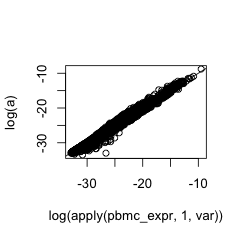

In [7]:
t(c(mean(apply(pbmc_expr,1,var),na.rm=T),mean(apply(cm_expr_pbmc_counts,1,var),na.rm=T),mean(apply(ncm_expr_pbmc_counts,1,var),na.rm=T),mean(apply(th_expr_pbmc_counts,1,var),na.rm=T),mean(apply(tc_expr_pbmc_counts,1,var),na.rm=T),mean(apply(b_expr_pbmc_counts,1,var),na.rm=T),mean(apply(nk_expr_pbmc_counts,1,var),na.rm=T),mean(apply(cdc_expr_pbmc_counts,1,var),na.rm=T),mean(apply(pdc_expr_pbmc_counts,1,var),na.rm=T)))

a <- apply(cm_expr_pbmc_counts,1,var)+apply(ncm_expr_pbmc_counts,1,var)+apply(th_expr_pbmc_counts,1,var)+apply(tc_expr_pbmc_counts,1,var)+apply(b_expr_pbmc_counts,1,var)+apply(nk_expr_pbmc_counts,1,var)+apply(cdc_expr_pbmc_counts,1,var)+apply(pdc_expr_pbmc_counts,1,var)

plot(log(apply(pbmc_expr,1,var)), log(a));
abline(a=0,b=1)

In [8]:
t(c(var(pbmc_expr["CD14",]),var(cm_expr_pbmc_counts["CD14",]),var(ncm_expr_pbmc_counts["CD14",]),var(th_expr_pbmc_counts["CD14",]),var(tc_expr_pbmc_counts["CD14",]),var(b_expr_pbmc_counts["CD14",]),var(cdc_expr_pbmc_counts["CD14",]),var(pdc_expr_pbmc_counts["CD14",])))
sum(var(cm_expr_pbmc_counts["CD14",]), var(ncm_expr_pbmc_counts["CD14",]), var(th_expr_pbmc_counts["CD14",]), var(tc_expr_pbmc_counts["CD14",]), var(b_expr_pbmc_counts["CD14",]), var(cdc_expr_pbmc_counts["CD14",]), var(pdc_expr_pbmc_counts["CD14",]))

[,1]         [,2]         [,3]         [,4]         [,5]       
[1,] 8.732243e-09 8.566226e-09 1.027497e-11 5.868275e-12 1.55566e-12
     [,6]         [,7]         [,8]        
[1,] 1.336083e-12 1.872565e-12 3.229542e-14

[1] 8.587166e-09

## filter samples

In [258]:
joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")
## let's remove the UCSF duplicate samples for now
ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

## let's get joined_ind_pivot into the same order as pbmc_expr
joined_pivot <- joined_pivot[match(ind_cov_batch[ucsf_samples_nodups],joined_ind_cov_batch),];

### all samples

In [260]:
cm_expr_pbmc_counts <- cm_expr_pbmc_counts[,ucsf_samples_nodups];
th_expr_pbmc_counts <- th_expr_pbmc_counts[,ucsf_samples_nodups];
tc_expr_pbmc_counts <- tc_expr_pbmc_counts[,ucsf_samples_nodups];
ncm_expr_pbmc_counts <- ncm_expr_pbmc_counts[,ucsf_samples_nodups];
b_expr_pbmc_counts <- b_expr_pbmc_counts[,ucsf_samples_nodups];
nk_expr_pbmc_counts <- nk_expr_pbmc_counts[,ucsf_samples_nodups];
cdc_expr_pbmc_counts <- cdc_expr_pbmc_counts[,ucsf_samples_nodups];
pdc_expr_pbmc_counts <- pdc_expr_pbmc_counts[,ucsf_samples_nodups];
pbmc_expr <- pbmc_expr[,ucsf_samples_nodups];

cm_expr_ct_counts <- cm_expr_ct_counts[,ucsf_samples_nodups];
th_expr_ct_counts <- th_expr_ct_counts[,ucsf_samples_nodups];
tc_expr_ct_counts <- tc_expr_ct_counts[,ucsf_samples_nodups];
ncm_expr_ct_counts <- ncm_expr_ct_counts[,ucsf_samples_nodups];
b_expr_ct_counts <- b_expr_ct_counts[,ucsf_samples_nodups];
nk_expr_ct_counts <- nk_expr_ct_counts[,ucsf_samples_nodups];
cdc_expr_ct_counts <- cdc_expr_ct_counts[,ucsf_samples_nodups];
pdc_expr_ct_counts <- pdc_expr_ct_counts[,ucsf_samples_nodups];

cm_covs <- cm_covs[ucsf_samples_nodups,];
th_covs <- th_covs[ucsf_samples_nodups,];
tc_covs <- tc_covs[ucsf_samples_nodups,];
ncm_covs <- ncm_covs[ucsf_samples_nodups,];
b_covs <- b_covs[ucsf_samples_nodups,];
nk_covs <- nk_covs[ucsf_samples_nodups,];
cdc_covs <- cdc_covs[ucsf_samples_nodups,];
pdc_covs <- pdc_covs[ucsf_samples_nodups,];
pbmc_covs <- pbmc_covs[ucsf_samples_nodups,];

### SLE

In [261]:
sle_indices <- setdiff((1:ncol(cm_expr_pbmc_counts)), grep("IGTB",colnames(pbmc_expr)))
sle_colnames <- colnames(pbmc_expr)[sle_indices]

cm_sle_expr_pbmc_counts <- cm_expr_pbmc_counts[,sle_indices]
th_sle_expr_pbmc_counts <- th_expr_pbmc_counts[,sle_indices]
tc_sle_expr_pbmc_counts <- tc_expr_pbmc_counts[,sle_indices]
ncm_sle_expr_pbmc_counts <- ncm_expr_pbmc_counts[,sle_indices]
b_sle_expr_pbmc_counts <- b_expr_pbmc_counts[,sle_indices]
nk_sle_expr_pbmc_counts <- nk_expr_pbmc_counts[,sle_indices]
cdc_sle_expr_pbmc_counts <- cdc_expr_pbmc_counts[,sle_indices]
pdc_sle_expr_pbmc_counts <- pdc_expr_pbmc_counts[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

cm_sle_expr_ct_counts <- cm_expr_ct_counts[,sle_indices]
th_sle_expr_ct_counts <- th_expr_ct_counts[,sle_indices]
tc_sle_expr_ct_counts <- tc_expr_ct_counts[,sle_indices]
ncm_sle_expr_ct_counts <- ncm_expr_ct_counts[,sle_indices]
b_sle_expr_ct_counts <- b_expr_ct_counts[,sle_indices]
nk_sle_expr_ct_counts <- nk_expr_ct_counts[,sle_indices]
cdc_sle_expr_ct_counts <- cdc_expr_ct_counts[,sle_indices]
pdc_sle_expr_ct_counts <- pdc_expr_ct_counts[,sle_indices]

### UCSF healthy

In [262]:
ucsf_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("lupus",pbmc_covs[,"batch"]))
ucsf_healthy_colnames <- paste(colnames(pbmc_expr)[ucsf_healthy_indices],"_ucsf",sep="")


cm_ucsf_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]

cm_ucsf_healthy_expr_ct_counts <- cm_expr_ct_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_ct_counts <- th_expr_ct_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_ct_counts <- tc_expr_ct_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_ct_counts <- ncm_expr_ct_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_ct_counts <- b_expr_ct_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_ct_counts <- nk_expr_ct_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_ct_counts <- cdc_expr_ct_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_ct_counts <- pdc_expr_ct_counts[,ucsf_healthy_indices]

### broad healthy

In [263]:
broad_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("immvar", pbmc_covs[,"batch"]))
broad_healthy_colnames <- paste(colnames(pbmc_expr)[broad_healthy_indices],"_broad",sep="")

cm_broad_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,broad_healthy_indices]
th_broad_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,broad_healthy_indices]
tc_broad_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,broad_healthy_indices]
b_broad_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,broad_healthy_indices]
nk_broad_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]

cm_broad_healthy_expr_ct_counts <- cm_expr_ct_counts[,broad_healthy_indices]
th_broad_healthy_expr_ct_counts <- th_expr_ct_counts[,broad_healthy_indices]
tc_broad_healthy_expr_ct_counts <- tc_expr_ct_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_ct_counts <- ncm_expr_ct_counts[,broad_healthy_indices]
b_broad_healthy_expr_ct_counts <- b_expr_ct_counts[,broad_healthy_indices]
nk_broad_healthy_expr_ct_counts <- nk_expr_ct_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_ct_counts <- cdc_expr_ct_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_ct_counts <- pdc_expr_ct_counts[,broad_healthy_indices]

In [264]:
pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))

cm_expr_pbmc_counts_std <- t(apply(cm_expr_pbmc_counts,1,standardize))
th_expr_pbmc_counts_std <- t(apply(th_expr_pbmc_counts,1,standardize))
b_expr_pbmc_counts_std <- t(apply(b_expr_pbmc_counts,1,standardize))
nk_expr_pbmc_counts_std <- t(apply(nk_expr_pbmc_counts,1,standardize))
ncm_expr_pbmc_counts_std <- t(apply(ncm_expr_pbmc_counts,1,standardize))
tc_expr_pbmc_counts_std <- t(apply(tc_expr_pbmc_counts,1,standardize))
cdc_expr_pbmc_counts_std <- t(apply(cdc_expr_pbmc_counts,1,standardize))
pdc_expr_pbmc_counts_std <- t(apply(pdc_expr_pbmc_counts,1,standardize))

cm_expr_ct_counts_std <- t(apply(cm_expr_ct_counts,1,standardize))
th_expr_ct_counts_std <- t(apply(th_expr_ct_counts,1,standardize))
b_expr_ct_counts_std <- t(apply(b_expr_ct_counts,1,standardize))
nk_expr_ct_counts_std <- t(apply(nk_expr_ct_counts,1,standardize))
ncm_expr_ct_counts_std <- t(apply(ncm_expr_ct_counts,1,standardize))
tc_expr_ct_counts_std <- t(apply(tc_expr_ct_counts,1,standardize))
cdc_expr_ct_counts_std <- t(apply(cdc_expr_ct_counts,1,standardize))
pdc_expr_ct_counts_std <- t(apply(pdc_expr_ct_counts,1,standardize))


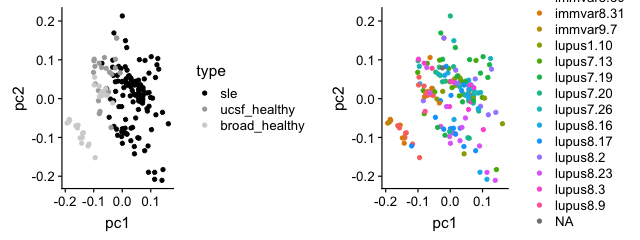

In [265]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

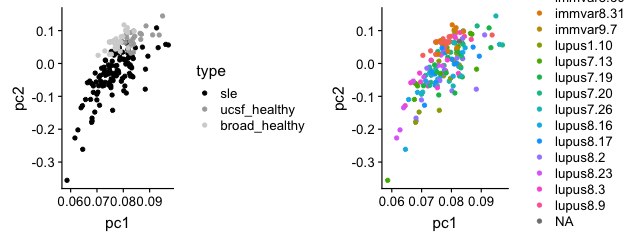

In [266]:
pbmc_expr_prcomp <- prcomp(pbmc_expr)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]


options(repr.plot.width = 8, repr.plot.height = 3)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

In [267]:
# pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(pbmc_deseq_sig_genes,rownames(pbmc_expr_std))),])

# df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
#            )
# df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

# options(repr.plot.width = 4, repr.plot.height = 3)
# ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

# ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

## Load the differentially expression results

In [268]:
pbmc_deseq <- fread("v6.1.deseq/v6.1..PBMC.deseq.txt")##as.data.frame()
th_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..Th.deseq.txt"))
tc_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..Tc.deseq.txt"))
cm_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..cM.deseq.txt"))
ncm_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..ncM.deseq.txt"))
b_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..B.deseq.txt"))
nk_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..NK.deseq.txt"))
cdc_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..cDC.deseq.txt"))
pdc_deseq <- as.data.frame(fread("v6.1.deseq/v6.1..pDC.deseq.txt"))

pbmc_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..PBMC.deseq.sig.txt",header=F))$V1
th_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..Th.deseq.sig.txt",header=F))$V1
tc_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..Tc.deseq.sig.txt",header=F))$V1
cm_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..cM.deseq.sig.txt",header=F))$V1
ncm_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..ncM.deseq.sig.txt",header=F))$V1
b_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..B.deseq.sig.txt",header=F))$V1
nk_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..NK.deseq.sig.txt",header=F))$V1
cdc_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..cDC.deseq.sig.txt",header=F))$V1
pdc_deseq_sig <- as.data.frame(fread("v6.1.deseq/v6.1..pDC.deseq.sig.txt",header=F))$V1
union_deseq_sig <- unique(c(pbmc_deseq_sig, cm_deseq_sig, th_deseq_sig, 
                            tc_deseq_sig, b_deseq_sig, ncm_deseq_sig, nk_deseq_sig, cdc_deseq_sig, pdc_deseq_sig));

Warning message in fread("v6.1.deseq/v6.1..PBMC.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.deseq/v6.1..Th.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.1.deseq/v6.1..Tc.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this g

In [269]:
pbmc_deseq_sig_genes <- pbmc_deseq$V1[intersect(which(pbmc_deseq$baseMean > 25), intersect(which(abs(pbmc_deseq$log2FoldChange)>1),which(pbmc_deseq$qval < 0.01)))]
cm_deseq_sig_genes <- cm_deseq$V1[intersect(which(cm_deseq$baseMean > 25), intersect(which(abs(cm_deseq$log2FoldChange)>1),which(cm_deseq$qval < 0.01)))]
th_deseq_sig_genes <- th_deseq$V1[intersect(which(th_deseq$baseMean > 25), intersect(which(abs(th_deseq$log2FoldChange)>1),which(th_deseq$qval < 0.01)))]
tc_deseq_sig_genes <- tc_deseq$V1[intersect(which(tc_deseq$baseMean > 25), intersect(which(abs(tc_deseq$log2FoldChange)>1),which(tc_deseq$qval < 0.01)))]
b_deseq_sig_genes <- b_deseq$V1[intersect(which(b_deseq$baseMean > 25), intersect(which(abs(b_deseq$log2FoldChange)>1),which(b_deseq$qval < 0.01)))]
ncm_deseq_sig_genes <- ncm_deseq$V1[intersect(which(ncm_deseq$baseMean > 25), intersect(which(abs(ncm_deseq$log2FoldChange)>1),which(ncm_deseq$qval < 0.01)))]
nk_deseq_sig_genes <- nk_deseq$V1[intersect(which(nk_deseq$baseMean > 25), intersect(which(abs(nk_deseq$log2FoldChange)>1),which(nk_deseq$qval < 0.01)))]
cdc_deseq_sig_genes <- cdc_deseq$V1[intersect(which(cdc_deseq$baseMean > 25), intersect(which(abs(cdc_deseq$log2FoldChange)>1),which(cdc_deseq$qval < 0.01)))]
pdc_deseq_sig_genes <- pdc_deseq$V1[intersect(which(pdc_deseq$baseMean > 25), intersect(which(abs(pdc_deseq$log2FoldChange)>1),which(pdc_deseq$qval < 0.01)))]

union_deseq_sig_genes <- unique(c(pbmc_deseq_sig_genes, cm_deseq_sig_genes, ncm_deseq_sig_genes, cdc_deseq_sig_genes, pdc_deseq_sig_genes, th_deseq_sig_genes, tc_deseq_sig_genes,  nk_deseq_sig_genes,b_deseq_sig_genes))
length(union_deseq_sig_genes)
length(pbmc_deseq_sig_genes)
length(intersect(pbmc_deseq_sig_genes, union_deseq_sig_genes))

deseq_sig_genes <- union_deseq_sig_genes

[1] 198

[1] 141

[1] 141

## Load the joined table and preprocess the expression and counts data

In [270]:
# joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")
# joined_pivot <- as.data.frame(joined_pivot);
# ## filter for ucsf healthy only
# ##joined_pivot <- joined_pivot[grep("lupus",joined_pivot$batch_cov),]

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")

# ##joined_pivot$batch_cov <- as.factor(joined_pivot$batch_cov)

# ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
# ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
# joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
# ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

# joined_pivot_filtered <- joined_pivot[match(c(colnames(pbmc_sle_expr),colnames(pbmc_ucsf_healthy_expr),colnames(pbmc_broad_healthy_expr)),joined_ind_cov_batch),]
joined_pivot_sle <- joined_pivot[match(colnames(pbmc_sle_expr), joined_ind_cov_batch),]
joined_pivot_ucsf_healthy <- joined_pivot[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch),]
joined_pivot_broad_healthy <- joined_pivot[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch),]

## get the cell type proportions

In [271]:
cm_prop = joined_pivot$"cM";##/joined_pivot_filtered$pbmc;
th_prop = joined_pivot$"Th";##/joined_pivot_filtered$pbmc;
b_prop = joined_pivot$"B";##/joined_pivot_filtered$pbmc;
nk_prop = joined_pivot$"NK";##/joined_pivot_filtered$pbmc;
ncm_prop = joined_pivot$"ncM";#/joined_pivot_filtered$pbmc;
tc_prop = joined_pivot$"Tc";#/joined_pivot_filtered$pbmc;
cdc_prop = joined_pivot$"cDC";#/joined_pivot_filtered$pbmc;
pdc_prop = joined_pivot$"pDC";#/joined_pivot_filtered$pbmc;


In [272]:
cm_prop = joined_pivot$"cM";##/joined_pivot_filtered$pbmc;
th_prop = joined_pivot$"Th";##/joined_pivot_filtered$pbmc;
b_prop = joined_pivot$"B";##/joined_pivot_filtered$pbmc;
nk_prop = joined_pivot$"NK";##/joined_pivot_filtered$pbmc;
ncm_prop = joined_pivot$"ncM";#/joined_pivot_filtered$pbmc;
tc_prop = joined_pivot$"Tc";#/joined_pivot_filtered$pbmc;
cdc_prop = joined_pivot$"cDC";#/joined_pivot_filtered$pbmc;
pdc_prop = joined_pivot$"pDC";#/joined_pivot_filtered$pbmc;

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")

# ## set the NAs to 0
# b_prop[which(is.na(b_prop))] <- 0;
# cdc_prop[which(is.na(cdc_prop))] <- 0;
# pdc_prop[which(is.na(pdc_prop))] <- 0;

cm_sle_prop = cm_prop[sle_indices]
th_sle_prop = th_prop[sle_indices]
b_sle_prop = b_prop[sle_indices]
nk_sle_prop = nk_prop[sle_indices]
ncm_sle_prop = ncm_prop[sle_indices]
tc_sle_prop = tc_prop[sle_indices]
cdc_sle_prop = cdc_prop[sle_indices]
pdc_sle_prop = pdc_prop[sle_indices]
names(cm_sle_prop) <- names(th_sle_prop) <- names(b_sle_prop) <- names(nk_sle_prop) <- names(ncm_sle_prop) <- names(tc_sle_prop) <- names(cdc_sle_prop) <- names(pdc_sle_prop) <- joined_ind_cov_batch[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]

cm_ucsf_healthy_prop = cm_prop[ucsf_healthy_indices]
th_ucsf_healthy_prop = th_prop[ucsf_healthy_indices]
b_ucsf_healthy_prop = b_prop[ucsf_healthy_indices]
nk_ucsf_healthy_prop = nk_prop[ucsf_healthy_indices]
ncm_ucsf_healthy_prop = ncm_prop[ucsf_healthy_indices]
tc_ucsf_healthy_prop = tc_prop[ucsf_healthy_indices]
cdc_ucsf_healthy_prop = cdc_prop[ucsf_healthy_indices]
pdc_ucsf_healthy_prop = pdc_prop[ucsf_healthy_indices]
names(cm_ucsf_healthy_prop) <- names(th_ucsf_healthy_prop) <- names(b_ucsf_healthy_prop) <- names(nk_ucsf_healthy_prop) <- names(ncm_ucsf_healthy_prop) <- names(tc_ucsf_healthy_prop) <- names(cdc_ucsf_healthy_prop) <- names(pdc_ucsf_healthy_prop)<- joined_ind_cov_batch[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]

cm_broad_healthy_prop = cm_prop[broad_healthy_indices]
th_broad_healthy_prop = th_prop[broad_healthy_indices]
b_broad_healthy_prop = b_prop[broad_healthy_indices]
nk_broad_healthy_prop = nk_prop[broad_healthy_indices]
ncm_broad_healthy_prop = ncm_prop[broad_healthy_indices]
tc_broad_healthy_prop = tc_prop[broad_healthy_indices]
cdc_broad_healthy_prop = cdc_prop[broad_healthy_indices]
pdc_broad_healthy_prop = pdc_prop[broad_healthy_indices]
names(cm_broad_healthy_prop) <- names(th_broad_healthy_prop) <- names(b_broad_healthy_prop) <- names(nk_broad_healthy_prop) <- names(ncm_broad_healthy_prop) <- names(tc_broad_healthy_prop) <- names(cdc_broad_healthy_prop)<- names(pdc_broad_healthy_prop)  <- joined_ind_cov_batch[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]


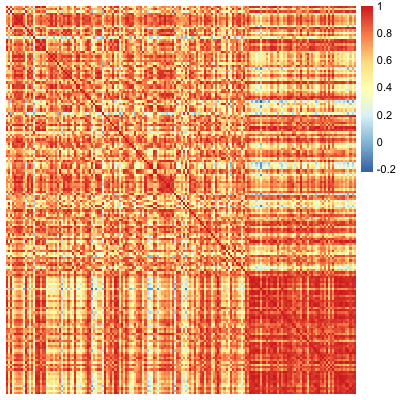

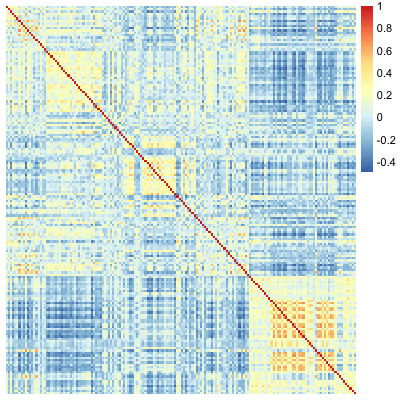

In [273]:
options(repr.plot.width = 5, repr.plot.height = 5)

a=pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, cdc_prop, pdc_prop))),cluster_rows=F,cluster_cols=F)
##options(repr.plot.width = 5, repr.plot.height = 5)
b=pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F, show_colnames=FALSE, show_rownames=FALSE)
##grid.arrange(a,b,ncol=2)

# Let's do some batch adjustments

## first, let's adjust cell type proportion

In [274]:
props <- as.matrix(data.frame(cM=cm_prop, Th=th_prop, B=b_prop, NK=nk_prop, ncM=ncm_prop, Tc=tc_prop, cDC=cdc_prop, pDC=pdc_prop));

props_sle <- as.matrix(data.frame(cM=cm_sle_prop, Th=th_sle_prop, B=b_sle_prop, NK=nk_sle_prop, ncM=ncm_sle_prop, Tc=tc_sle_prop, cDC=cdc_sle_prop, pDC=pdc_sle_prop));
props_ucsf_healthy <- as.matrix(data.frame(cM=cm_ucsf_healthy_prop, Th=th_ucsf_healthy_prop, B=b_ucsf_healthy_prop, NK=nk_ucsf_healthy_prop, ncM=ncm_ucsf_healthy_prop, Tc=tc_ucsf_healthy_prop, cDC=cdc_ucsf_healthy_prop, pDC=pdc_ucsf_healthy_prop));
props_broad_healthy <- as.matrix(data.frame(cM=cm_broad_healthy_prop, Th=th_broad_healthy_prop, B=b_broad_healthy_prop, NK=nk_broad_healthy_prop, ncM=ncm_broad_healthy_prop, Tc=tc_broad_healthy_prop, cDC=cdc_broad_healthy_prop, pDC=pdc_broad_healthy_prop));


## second, let's adjust cell type specific expression

In [275]:
# pbmc_mean <- t(lm(t(pbmc_expr)~1)$fitted)
# cm_mean <- t(lm(t(cm_expr)~1)$fitted)
# th_mean <- t(lm(t(th_expr)~1)$fitted)
# b_mean <- t(lm(t(b_expr)~1)$fitted)
# nk_mean <- t(lm(t(nk_expr)~1)$fitted)
# ncm_mean <- t(lm(t(ncm_expr)~1)$fitted)
# tc_mean <- t(lm(t(tc_expr)~1)$fitted)
# cdc_mean <- t(lm(t(cdc_expr)~1)$fitted)
# pdc_mean <- t(lm(t(pdc_expr)~1)$fitted)

##joined_pivot$seq_batch_cov <- grep("immvar",joined_pivot$batch_cov)

modcombat = model.matrix(~disease_cov, data=joined_pivot);
# modcombat = model.matrix(~1, data=joined_pivot);

# pbmc_expr <- ComBat(dat=pbmc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# cm_expr <-  ComBat(dat=cm_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# th_expr <-  ComBat(dat=th_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# b_expr <-  ComBat(dat=b_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# nk_expr <-  ComBat(dat=nk_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# ncm_expr <-  ComBat(dat=ncm_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# tc_expr <-  ComBat(dat=tc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# cdc_expr <-  ComBat(dat=cdc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# pdc_expr <-  ComBat(dat=pdc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)


## let's remake the exprs and standardized versions

### all first

In [276]:
exprs_pbmc_counts <- array(c(cm_expr_pbmc_counts, th_expr_pbmc_counts, b_expr_pbmc_counts, nk_expr_pbmc_counts, ncm_expr_pbmc_counts, tc_expr_pbmc_counts, cdc_expr_pbmc_counts, pdc_expr_pbmc_counts),
               c(nrow(cm_expr_pbmc_counts) , ncol(cm_expr_pbmc_counts), 8),
               list(rownames(cm_expr_pbmc_counts),colnames(cm_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_ct_counts <- array(c(cm_expr_ct_counts, th_expr_ct_counts, b_expr_ct_counts, nk_expr_ct_counts, ncm_expr_ct_counts, tc_expr_ct_counts, cdc_expr_ct_counts, pdc_expr_ct_counts),
               c(nrow(cm_expr_ct_counts) , ncol(cm_expr_ct_counts), 8),
               list(rownames(cm_expr_ct_counts),colnames(cm_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))

cm_expr_pbmc_counts_std <- t(apply(cm_expr_pbmc_counts,1,standardize))
th_expr_pbmc_counts_std <- t(apply(th_expr_pbmc_counts,1,standardize))
b_expr_pbmc_counts_std <- t(apply(b_expr_pbmc_counts,1,standardize))
nk_expr_pbmc_counts_std <- t(apply(nk_expr_pbmc_counts,1,standardize))
ncm_expr_pbmc_counts_std <- t(apply(ncm_expr_pbmc_counts,1,standardize))
tc_expr_pbmc_counts_std <- t(apply(tc_expr_pbmc_counts,1,standardize))
cdc_expr_pbmc_counts_std <- t(apply(cdc_expr_pbmc_counts,1,standardize))
pdc_expr_pbmc_counts_std <- t(apply(pdc_expr_pbmc_counts,1,standardize))

cm_expr_ct_counts_std <- t(apply(cm_expr_ct_counts,1,standardize))
th_expr_ct_counts_std <- t(apply(th_expr_ct_counts,1,standardize))
b_expr_ct_counts_std <- t(apply(b_expr_ct_counts,1,standardize))
nk_expr_ct_counts_std <- t(apply(nk_expr_ct_counts,1,standardize))
ncm_expr_ct_counts_std <- t(apply(ncm_expr_ct_counts,1,standardize))
tc_expr_ct_counts_std <- t(apply(tc_expr_ct_counts,1,standardize))
cdc_expr_ct_counts_std <- t(apply(cdc_expr_ct_counts,1,standardize))
pdc_expr_ct_counts_std <- t(apply(pdc_expr_ct_counts,1,standardize))

exprs_pbmc_counts_std <- array(c(cm_expr_pbmc_counts_std, th_expr_pbmc_counts_std, b_expr_pbmc_counts_std, nk_expr_pbmc_counts_std, ncm_expr_pbmc_counts_std, tc_expr_pbmc_counts_std, cdc_expr_pbmc_counts_std, pdc_expr_pbmc_counts_std),
               c(nrow(cm_expr_pbmc_counts_std) , ncol(cm_expr_pbmc_counts_std), 8),
               list(rownames(cm_expr_pbmc_counts_std),colnames(cm_expr_pbmc_counts_std),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_ct_counts_std <- array(c(cm_expr_ct_counts_std, th_expr_ct_counts_std, b_expr_ct_counts_std, nk_expr_ct_counts_std, ncm_expr_ct_counts_std, tc_expr_ct_counts_std, cdc_expr_ct_counts_std, pdc_expr_ct_counts_std),
               c(nrow(cm_expr_ct_counts_std) , ncol(cm_expr_ct_counts_std), 8),
               list(rownames(cm_expr_ct_counts_std),colnames(cm_expr_ct_counts_std),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))


### SLE

In [277]:
cm_sle_expr_pbmc_counts <- cm_expr_pbmc_counts[,sle_indices]
th_sle_expr_pbmc_counts <- th_expr_pbmc_counts[,sle_indices]
tc_sle_expr_pbmc_counts <- tc_expr_pbmc_counts[,sle_indices]
ncm_sle_expr_pbmc_counts <- ncm_expr_pbmc_counts[,sle_indices]
b_sle_expr_pbmc_counts <- b_expr_pbmc_counts[,sle_indices]
nk_sle_expr_pbmc_counts <- nk_expr_pbmc_counts[,sle_indices]
cdc_sle_expr_pbmc_counts <- cdc_expr_pbmc_counts[,sle_indices]
pdc_sle_expr_pbmc_counts <- pdc_expr_pbmc_counts[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

cm_sle_expr_ct_counts <- cm_expr_ct_counts[,sle_indices]
th_sle_expr_ct_counts <- th_expr_ct_counts[,sle_indices]
tc_sle_expr_ct_counts <- tc_expr_ct_counts[,sle_indices]
ncm_sle_expr_ct_counts <- ncm_expr_ct_counts[,sle_indices]
b_sle_expr_ct_counts <- b_expr_ct_counts[,sle_indices]
nk_sle_expr_ct_counts <- nk_expr_ct_counts[,sle_indices]
cdc_sle_expr_ct_counts <- cdc_expr_ct_counts[,sle_indices]
pdc_sle_expr_ct_counts <- pdc_expr_ct_counts[,sle_indices]

exprs_sle_pbmc_counts <- array(c(cm_sle_expr_pbmc_counts, th_sle_expr_pbmc_counts, b_sle_expr_pbmc_counts, nk_sle_expr_pbmc_counts, ncm_sle_expr_pbmc_counts, tc_sle_expr_pbmc_counts, cdc_sle_expr_pbmc_counts, pdc_sle_expr_pbmc_counts),
                       c(nrow(cm_sle_expr_pbmc_counts) , ncol(cm_sle_expr_pbmc_counts), 8),
                       list(rownames(cm_sle_expr_pbmc_counts),colnames(cm_sle_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_sle_ct_counts <- array(c(cm_sle_expr_ct_counts, th_sle_expr_ct_counts, b_sle_expr_ct_counts, nk_sle_expr_ct_counts, ncm_sle_expr_ct_counts, tc_sle_expr_ct_counts, cdc_sle_expr_ct_counts, pdc_sle_expr_ct_counts),
                       c(nrow(cm_sle_expr_ct_counts) , ncol(cm_sle_expr_ct_counts), 8),
                       list(rownames(cm_sle_expr_ct_counts),colnames(cm_sle_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_sle_expr_std <- t(apply(pbmc_sle_expr,1,standardize))
cm_sle_expr_pbmc_counts_std <- t(apply(cm_sle_expr_pbmc_counts,1,standardize))
th_sle_expr_pbmc_counts_std <- t(apply(th_sle_expr_pbmc_counts,1,standardize))
b_sle_expr_pbmc_counts_std <- t(apply(b_sle_expr_pbmc_counts,1,standardize))
nk_sle_expr_pbmc_counts_std <- t(apply(nk_sle_expr_pbmc_counts,1,standardize))
ncm_sle_expr_pbmc_counts_std <- t(apply(ncm_sle_expr_pbmc_counts,1,standardize))
tc_sle_expr_pbmc_counts_std <- t(apply(tc_sle_expr_pbmc_counts,1,standardize))
cdc_sle_expr_pbmc_counts_std <- t(apply(cdc_sle_expr_pbmc_counts,1,standardize))
pdc_sle_expr_pbmc_counts_std <- t(apply(pdc_sle_expr_pbmc_counts,1,standardize))

exprs_sle_std_pbmc_counts <- array(c(cm_sle_expr_pbmc_counts_std, th_sle_expr_pbmc_counts_std, b_sle_expr_pbmc_counts_std, nk_sle_expr_pbmc_counts_std, ncm_sle_expr_pbmc_counts_std, tc_sle_expr_pbmc_counts_std, cdc_sle_expr_pbmc_counts_std, pdc_sle_expr_pbmc_counts_std),
                       c(nrow(cm_sle_expr_pbmc_counts) , ncol(cm_sle_expr_pbmc_counts), 8),
                       list(rownames(cm_sle_expr_pbmc_counts),colnames(cm_sle_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

cm_sle_expr_ct_counts_std <- t(apply(cm_sle_expr_ct_counts,1,standardize))
th_sle_expr_ct_counts_std <- t(apply(th_sle_expr_ct_counts,1,standardize))
b_sle_expr_ct_counts_std <- t(apply(b_sle_expr_ct_counts,1,standardize))
nk_sle_expr_ct_counts_std <- t(apply(nk_sle_expr_ct_counts,1,standardize))
ncm_sle_expr_ct_counts_std <- t(apply(ncm_sle_expr_ct_counts,1,standardize))
tc_sle_expr_ct_counts_std <- t(apply(tc_sle_expr_ct_counts,1,standardize))
cdc_sle_expr_ct_counts_std <- t(apply(cdc_sle_expr_ct_counts,1,standardize))
pdc_sle_expr_ct_counts_std <- t(apply(pdc_sle_expr_ct_counts,1,standardize))

exprs_sle_std_ct_counts <- array(c(cm_sle_expr_ct_counts_std, th_sle_expr_ct_counts_std, b_sle_expr_ct_counts_std, nk_sle_expr_ct_counts_std, ncm_sle_expr_ct_counts_std, tc_sle_expr_ct_counts_std, cdc_sle_expr_ct_counts_std, pdc_sle_expr_ct_counts_std),
                       c(nrow(cm_sle_expr_ct_counts) , ncol(cm_sle_expr_ct_counts), 8),
                       list(rownames(cm_sle_expr_ct_counts),colnames(cm_sle_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

### UCSF healthy

In [278]:
cm_ucsf_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]

cm_ucsf_healthy_expr_ct_counts <- cm_expr_ct_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_ct_counts <- th_expr_ct_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_ct_counts <- tc_expr_ct_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_ct_counts <- ncm_expr_ct_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_ct_counts <- b_expr_ct_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_ct_counts <- nk_expr_ct_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_ct_counts <- cdc_expr_ct_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_ct_counts <- pdc_expr_ct_counts[,ucsf_healthy_indices]

exprs_ucsf_healthy_pbmc_counts <- array(c(cm_ucsf_healthy_expr_pbmc_counts, th_ucsf_healthy_expr_pbmc_counts, b_ucsf_healthy_expr_pbmc_counts, nk_ucsf_healthy_expr_pbmc_counts, ncm_ucsf_healthy_expr_pbmc_counts, tc_ucsf_healthy_expr_pbmc_counts, cdc_ucsf_healthy_expr_pbmc_counts, pdc_ucsf_healthy_expr_pbmc_counts),
                       c(nrow(cm_ucsf_healthy_expr_pbmc_counts) , ncol(cm_ucsf_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_pbmc_counts),colnames(cm_ucsf_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_ucsf_healthy_ct_counts <- array(c(cm_ucsf_healthy_expr_ct_counts, th_ucsf_healthy_expr_ct_counts, b_ucsf_healthy_expr_ct_counts, nk_ucsf_healthy_expr_ct_counts, ncm_ucsf_healthy_expr_ct_counts, tc_ucsf_healthy_expr_ct_counts, cdc_ucsf_healthy_expr_ct_counts, pdc_ucsf_healthy_expr_ct_counts),
                       c(nrow(cm_ucsf_healthy_expr_ct_counts) , ncol(cm_ucsf_healthy_expr_ct_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_ct_counts),colnames(cm_ucsf_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_ucsf_healthy_expr_std <- t(apply(pbmc_ucsf_healthy_expr,1,standardize))
cm_ucsf_healthy_expr_pbmc_counts_std <- t(apply(cm_ucsf_healthy_expr_pbmc_counts,1,standardize))
th_ucsf_healthy_expr_pbmc_counts_std <- t(apply(th_ucsf_healthy_expr_pbmc_counts,1,standardize))
b_ucsf_healthy_expr_pbmc_counts_std <- t(apply(b_ucsf_healthy_expr_pbmc_counts,1,standardize))
nk_ucsf_healthy_expr_pbmc_counts_std <- t(apply(nk_ucsf_healthy_expr_pbmc_counts,1,standardize))
ncm_ucsf_healthy_expr_pbmc_counts_std <- t(apply(ncm_ucsf_healthy_expr_pbmc_counts,1,standardize))
tc_ucsf_healthy_expr_pbmc_counts_std <- t(apply(tc_ucsf_healthy_expr_pbmc_counts,1,standardize))
cdc_ucsf_healthy_expr_pbmc_counts_std <- t(apply(cdc_ucsf_healthy_expr_pbmc_counts,1,standardize))
pdc_ucsf_healthy_expr_pbmc_counts_std <- t(apply(pdc_ucsf_healthy_expr_pbmc_counts,1,standardize))

exprs_ucsf_healthy_std_pbmc_counts <- array(c(cm_ucsf_healthy_expr_pbmc_counts_std, th_ucsf_healthy_expr_pbmc_counts_std, b_ucsf_healthy_expr_pbmc_counts_std, nk_ucsf_healthy_expr_pbmc_counts_std, ncm_ucsf_healthy_expr_pbmc_counts_std, tc_ucsf_healthy_expr_pbmc_counts_std, cdc_ucsf_healthy_expr_pbmc_counts_std, pdc_ucsf_healthy_expr_pbmc_counts_std),
                       c(nrow(cm_ucsf_healthy_expr_pbmc_counts) , ncol(cm_ucsf_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_pbmc_counts),colnames(cm_ucsf_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

cm_ucsf_healthy_expr_ct_counts_std <- t(apply(cm_ucsf_healthy_expr_ct_counts,1,standardize))
th_ucsf_healthy_expr_ct_counts_std <- t(apply(th_ucsf_healthy_expr_ct_counts,1,standardize))
b_ucsf_healthy_expr_ct_counts_std <- t(apply(b_ucsf_healthy_expr_ct_counts,1,standardize))
nk_ucsf_healthy_expr_ct_counts_std <- t(apply(nk_ucsf_healthy_expr_ct_counts,1,standardize))
ncm_ucsf_healthy_expr_ct_counts_std <- t(apply(ncm_ucsf_healthy_expr_ct_counts,1,standardize))
tc_ucsf_healthy_expr_ct_counts_std <- t(apply(tc_ucsf_healthy_expr_ct_counts,1,standardize))
cdc_ucsf_healthy_expr_ct_counts_std <- t(apply(cdc_ucsf_healthy_expr_ct_counts,1,standardize))
pdc_ucsf_healthy_expr_ct_counts_std <- t(apply(pdc_ucsf_healthy_expr_ct_counts,1,standardize))

exprs_ucsf_healthy_std_ct_counts <- array(c(cm_ucsf_healthy_expr_ct_counts_std, th_ucsf_healthy_expr_ct_counts_std, b_ucsf_healthy_expr_ct_counts_std, nk_ucsf_healthy_expr_ct_counts_std, ncm_ucsf_healthy_expr_ct_counts_std, tc_ucsf_healthy_expr_ct_counts_std, cdc_ucsf_healthy_expr_ct_counts_std, pdc_ucsf_healthy_expr_ct_counts_std),
                       c(nrow(cm_ucsf_healthy_expr_ct_counts) , ncol(cm_ucsf_healthy_expr_ct_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_ct_counts),colnames(cm_ucsf_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))


### broad healthy

In [279]:
cm_broad_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,broad_healthy_indices]
th_broad_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,broad_healthy_indices]
tc_broad_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,broad_healthy_indices]
b_broad_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,broad_healthy_indices]
nk_broad_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]

cm_broad_healthy_expr_ct_counts <- cm_expr_ct_counts[,broad_healthy_indices]
th_broad_healthy_expr_ct_counts <- th_expr_ct_counts[,broad_healthy_indices]
tc_broad_healthy_expr_ct_counts <- tc_expr_ct_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_ct_counts <- ncm_expr_ct_counts[,broad_healthy_indices]
b_broad_healthy_expr_ct_counts <- b_expr_ct_counts[,broad_healthy_indices]
nk_broad_healthy_expr_ct_counts <- nk_expr_ct_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_ct_counts <- cdc_expr_ct_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_ct_counts <- pdc_expr_ct_counts[,broad_healthy_indices]

exprs_broad_healthy_pbmc_counts <- array(c(cm_broad_healthy_expr_pbmc_counts, th_broad_healthy_expr_pbmc_counts, b_broad_healthy_expr_pbmc_counts, nk_broad_healthy_expr_pbmc_counts, ncm_broad_healthy_expr_pbmc_counts, tc_broad_healthy_expr_pbmc_counts, cdc_broad_healthy_expr_pbmc_counts, pdc_broad_healthy_expr_pbmc_counts),
                       c(nrow(cm_broad_healthy_expr_pbmc_counts) , ncol(cm_broad_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_broad_healthy_expr_pbmc_counts),colnames(cm_broad_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_broad_healthy_ct_counts <- array(c(cm_broad_healthy_expr_ct_counts, th_broad_healthy_expr_ct_counts, b_broad_healthy_expr_ct_counts, nk_broad_healthy_expr_ct_counts, ncm_broad_healthy_expr_ct_counts, tc_broad_healthy_expr_ct_counts, cdc_broad_healthy_expr_ct_counts, pdc_broad_healthy_expr_ct_counts),
                       c(nrow(cm_broad_healthy_expr_ct_counts) , ncol(cm_broad_healthy_expr_ct_counts), 8),
                       list(rownames(cm_broad_healthy_expr_ct_counts),colnames(cm_broad_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_broad_healthy_expr_std <- t(apply(pbmc_broad_healthy_expr,1,standardize))
cm_broad_healthy_expr_pbmc_counts_std <- t(apply(cm_broad_healthy_expr_pbmc_counts,1,standardize))
th_broad_healthy_expr_pbmc_counts_std <- t(apply(th_broad_healthy_expr_pbmc_counts,1,standardize))
b_broad_healthy_expr_pbmc_counts_std <- t(apply(b_broad_healthy_expr_pbmc_counts,1,standardize))
nk_broad_healthy_expr_pbmc_counts_std <- t(apply(nk_broad_healthy_expr_pbmc_counts,1,standardize))
ncm_broad_healthy_expr_pbmc_counts_std <- t(apply(ncm_broad_healthy_expr_pbmc_counts,1,standardize))
tc_broad_healthy_expr_pbmc_counts_std <- t(apply(tc_broad_healthy_expr_pbmc_counts,1,standardize))
cdc_broad_healthy_expr_pbmc_counts_std <- t(apply(cdc_broad_healthy_expr_pbmc_counts,1,standardize))
pdc_broad_healthy_expr_pbmc_counts_std <- t(apply(pdc_broad_healthy_expr_pbmc_counts,1,standardize))

exprs_broad_healthy_std_pbmc_counts <- array(c(cm_broad_healthy_expr_pbmc_counts_std, th_broad_healthy_expr_pbmc_counts_std, b_broad_healthy_expr_pbmc_counts_std, nk_broad_healthy_expr_pbmc_counts_std, ncm_broad_healthy_expr_pbmc_counts_std, tc_broad_healthy_expr_pbmc_counts_std, cdc_broad_healthy_expr_pbmc_counts_std, pdc_broad_healthy_expr_pbmc_counts_std),
                       c(nrow(cm_broad_healthy_expr_pbmc_counts) , ncol(cm_broad_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_broad_healthy_expr_pbmc_counts),colnames(cm_broad_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

cm_broad_healthy_expr_ct_counts_std <- t(apply(cm_broad_healthy_expr_ct_counts,1,standardize))
th_broad_healthy_expr_ct_counts_std <- t(apply(th_broad_healthy_expr_ct_counts,1,standardize))
b_broad_healthy_expr_ct_counts_std <- t(apply(b_broad_healthy_expr_ct_counts,1,standardize))
nk_broad_healthy_expr_ct_counts_std <- t(apply(nk_broad_healthy_expr_ct_counts,1,standardize))
ncm_broad_healthy_expr_ct_counts_std <- t(apply(ncm_broad_healthy_expr_ct_counts,1,standardize))
tc_broad_healthy_expr_ct_counts_std <- t(apply(tc_broad_healthy_expr_ct_counts,1,standardize))
cdc_broad_healthy_expr_ct_counts_std <- t(apply(cdc_broad_healthy_expr_ct_counts,1,standardize))
pdc_broad_healthy_expr_ct_counts_std <- t(apply(pdc_broad_healthy_expr_ct_counts,1,standardize))

exprs_broad_healthy_std_ct_counts <- array(c(cm_broad_healthy_expr_ct_counts_std, th_broad_healthy_expr_ct_counts_std, b_broad_healthy_expr_ct_counts_std, nk_broad_healthy_expr_ct_counts_std, ncm_broad_healthy_expr_ct_counts_std, tc_broad_healthy_expr_ct_counts_std, cdc_broad_healthy_expr_ct_counts_std, pdc_broad_healthy_expr_ct_counts_std),
                       c(nrow(cm_broad_healthy_expr_ct_counts) , ncol(cm_broad_healthy_expr_ct_counts), 8),
                       list(rownames(cm_broad_healthy_expr_ct_counts),colnames(cm_broad_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

## plot both after correcting for batch

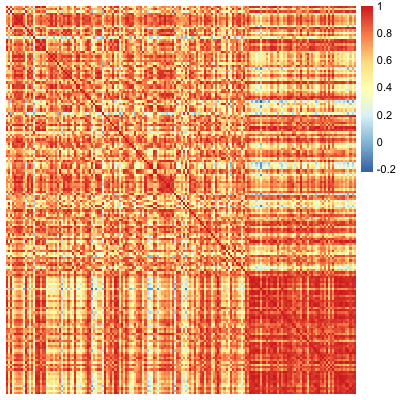

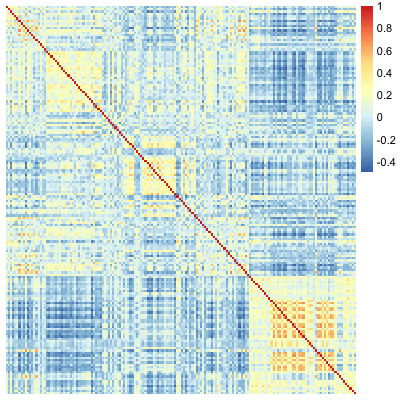

In [280]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, cdc_prop, pdc_prop))),cluster_rows=F,cluster_cols=F)
##options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F, show_colnames=FALSE, show_rownames=FALSE)

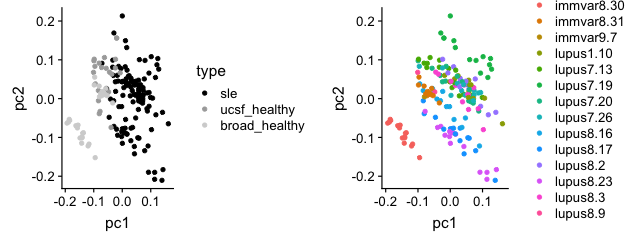

In [281]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

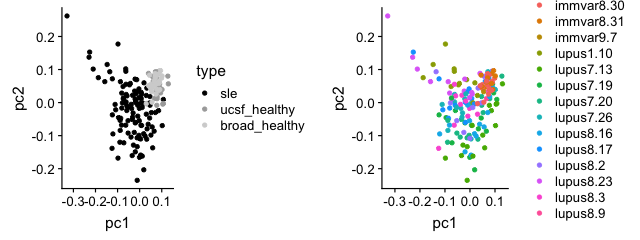

In [282]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(deseq_sig_genes,rownames(pbmc_expr_std))),])

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

In [283]:
t(c(cor(colMeans(cm_expr_pbmc_counts), props[,"cM"]),cor(colMeans(th_expr_pbmc_counts), props[,"Th"]),cor(colMeans(tc_expr_pbmc_counts), props[,"Tc"]),cor(colMeans(nk_expr_pbmc_counts), props[,"NK"]),cor(colMeans(ncm_expr_pbmc_counts), props[,"ncM"]),cor(colMeans(pdc_expr_pbmc_counts), props[,"pDC"]),cor(colMeans(cdc_expr_pbmc_counts), props[,"cDC"])))

[,1]     [,2]      [,3]     [,4]     [,5]      [,6]      [,7]     
[1,] 0.982014 0.9904002 0.977977 0.982003 0.9871372 0.9888227 0.9828541

In [284]:
# cor(colMeans(cm_expr_std), props[,"cM"])
# cor(colMeans(th_expr_std), props[,"Th"])
# cor(colMeans(tc_expr_std), props[,"Tc"])
# cor(colMeans(nk_expr_std), props[,"NK"])
# cor(colMeans(ncm_expr_std), props[,"ncM"])
# cor(colMeans(pdc_expr_std), props[,"pDC"])
# cor(colMeans(cdc_expr_std), props[,"cDC"])

In [285]:
cor(pbmc_expr["CD14",], props[,"cM"])
cor(pbmc_sle_expr["CD14",], props_sle[,"cM"])

cor(pbmc_expr_std["CD14",], props[,"cM"])
cor(pbmc_sle_expr_std["CD14",], props_sle[,"cM"])

[1] 0.7610929

[1] 0.7084972

[1] 0.7610929

[1] 0.7084972

# Figure 2A - heatmap

In [363]:
cell_types <- c("PBMC","cM","ncM", "cDC","pDC","T4","T8","NK","B")

pbmc_col_clust <- hclust(dist(t(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),]),method = "manhattan"), method="ward.D2")
pbmc_row_clust <- hclust(dist(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],method = "manhattan"), method="ward.D2")

all_expr_pbmc_counts_std <- data.frame(pbmc=pbmc_expr_std[,pbmc_col_clust$order],
                                   cm=cm_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   ncm=ncm_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   cdc=cdc_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   pdc=pdc_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   th=th_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   tc=tc_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   nk=nk_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   b=b_expr_pbmc_counts_std[,pbmc_col_clust$order])


all_expr_pbmc_counts <- data.frame(pbmc=pbmc_expr[,pbmc_col_clust$order],
                      cm=cm_expr_pbmc_counts[,pbmc_col_clust$order],
                      ncm=ncm_expr_pbmc_counts[,pbmc_col_clust$order],
                      cdc=cdc_expr_pbmc_counts[,pbmc_col_clust$order],
                       pdc=pdc_expr_pbmc_counts[,pbmc_col_clust$order],
                      th=th_expr_pbmc_counts[,pbmc_col_clust$order],
                      tc=tc_expr_pbmc_counts[,pbmc_col_clust$order],
                      nk=nk_expr_pbmc_counts[,pbmc_col_clust$order],
                      b=b_expr_pbmc_counts[,pbmc_col_clust$order]
                      )

all_expr_pbmc_counts_sig <- all_expr_pbmc_counts[match(deseq_sig_genes,expr_gene_names),]
all_expr_pbmc_counts_std_sig <- all_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),]
                                       
all_expr_ct_counts_std <- data.frame(pbmc=pbmc_expr_std[,pbmc_col_clust$order],
                                   cm=cm_expr_ct_counts_std[,pbmc_col_clust$order],
                                   ncm=ncm_expr_ct_counts_std[,pbmc_col_clust$order],
                                   cdc=cdc_expr_ct_counts_std[,pbmc_col_clust$order],
                                   pdc=pdc_expr_ct_counts_std[,pbmc_col_clust$order],
                                   th=th_expr_ct_counts_std[,pbmc_col_clust$order],
                                   tc=tc_expr_ct_counts_std[,pbmc_col_clust$order],
                                   nk=nk_expr_ct_counts_std[,pbmc_col_clust$order],
                                   b=b_expr_ct_counts_std[,pbmc_col_clust$order])


all_expr_ct_counts <- data.frame(pbmc=pbmc_expr[,pbmc_col_clust$order],
                      cm=cm_expr_ct_counts[,pbmc_col_clust$order],
                      ncm=ncm_expr_ct_counts[,pbmc_col_clust$order],
                      cdc=cdc_expr_ct_counts[,pbmc_col_clust$order],
                       pdc=pdc_expr_ct_counts[,pbmc_col_clust$order],
                      th=th_expr_ct_counts[,pbmc_col_clust$order],
                      tc=tc_expr_ct_counts[,pbmc_col_clust$order],
                      nk=nk_expr_ct_counts[,pbmc_col_clust$order],
                      b=b_expr_ct_counts[,pbmc_col_clust$order]
                      )

all_expr_ct_counts_sig <- all_expr_ct_counts[match(deseq_sig_genes,expr_gene_names),]
all_expr_ct_counts_std_sig <- all_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),]

                                     
                                     
ct_annotation_one <- data.frame(disease_pop_cov=joined_pivot$disease_pop_cov,
                           sledaiscore=joined_pivot$sledaiscore)
rownames(ct_annotation_one) <- colnames(pbmc_expr);


ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr_pbmc_counts))),
                           disease_pop_cov=joined_pivot$disease_pop_cov[pbmc_col_clust$order],
                           sledaiscore=joined_pivot$sledaiscore[pbmc_col_clust$order])
rownames(ct_annotation) <- colnames(all_expr_pbmc_counts_std);


In [287]:
# options(repr.plot.width = 16, repr.plot.height = 16)

# breaksList = seq(-2, 2, by = .1)
# pheatmap_out <- pheatmap(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
#          cluster_rows=T, cluster_cols=F,annotation_col = ct_annotation_one[pbmc_col_clust$order,],#annotation_row = kmeans_annotation,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), 
#                          cutree_rows=8, 
#                          scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",# Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList) # Sets the breaks of the color scale as in breaksList

In [364]:
ifn_crow <- read.table("ifn.lupus.crow.etal.txt")
crow_annotation <- matrix(nrow=nrow(all_expr_pbmc_counts_std_sig), ncol=1, 0);
crow_annotation[na.omit(match(ifn_crow$V1, rownames(all_expr_pbmc_counts_std_sig))),1] <- 1;
rownames(crow_annotation) <- rownames(all_expr_pbmc_counts_std_sig)
colnames(crow_annotation) <- "Crow"
crow_annotation <- as.data.frame(crow_annotation)
sum(crow_annotation$Crow)

[1] 25

In [365]:
pbmc_deseq_sig_annotation <- matrix(nrow=nrow(all_expr_pbmc_counts_std_sig), ncol=1, 0);
pbmc_deseq_sig_annotation[na.omit(match(pbmc_deseq_sig_genes, rownames(all_expr_pbmc_counts_std_sig))),1] <- 1;
rownames(pbmc_deseq_sig_annotation) <- rownames(all_expr_pbmc_counts_std_sig)
colnames(pbmc_deseq_sig_annotation) <- "PBMC Sig"
pbmc_deseq_sig_annotation <- as.data.frame(pbmc_deseq_sig_annotation)
row_annotations <- cbind(crow_annotation, pbmc_deseq_sig_annotation)
sum(row_annotations$Crow[row_annotations$"PBMC Sig"==1])

[1] 21

In [366]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2, 2, by = .2)

annotation_colors = list(
    type = c(PBMC="#000000", cM="#E58606", ncM="#5D69B1", cDC="#52BCA3", pDC="#99C945", T4="#CC61B0", T8="#24796C", NK="#DAA51B", B="#764E9F"),
    disease_pop_cov = c(healthyWHITE="#D82B29", sleWHITE="#1B78B6", sleASIAN="#F57F20")
)

# pheatmap_std_out <- pheatmap(all_expr_pbmc_counts_std,
#          cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors = annotation_colors,#annotation_row = kmeans_annotation,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
#                          cutree_rows=8, 
#                          scale="none",fontsize=2,clustering_method="ward.D",clustering_distance_row="manhattan", filename="expr_std_heatmap.png",
#                             width=10, height=10, dpi=600)
# options(repr.plot.width = 10, repr.plot.height = 4)



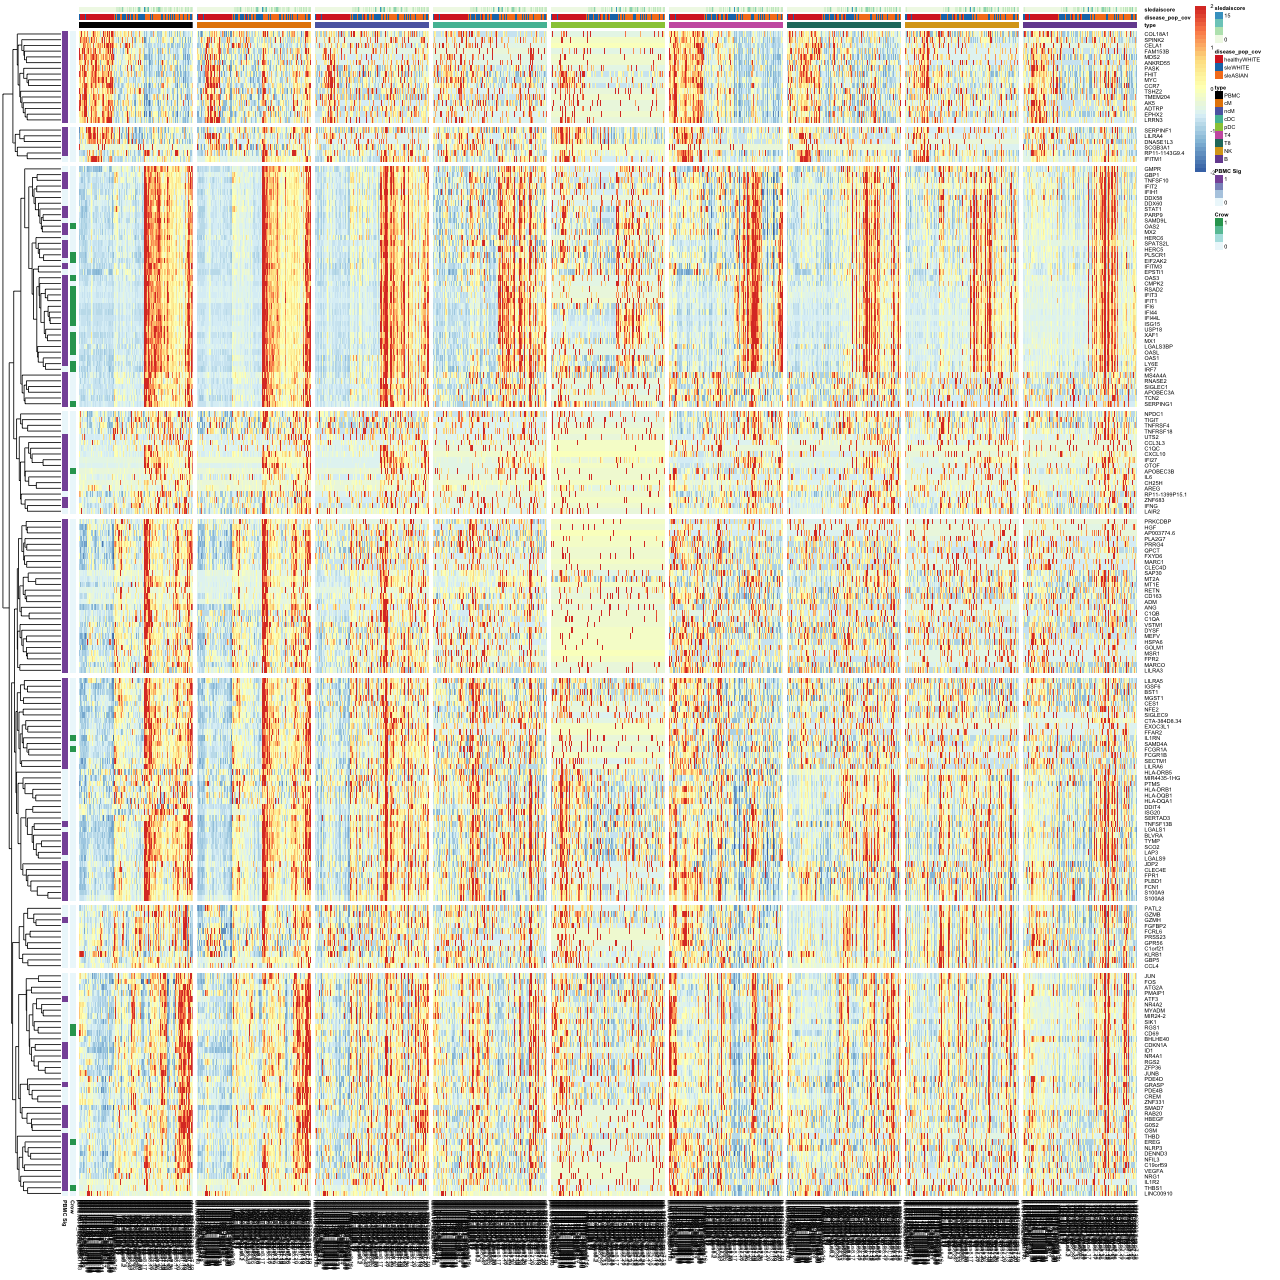

In [368]:
options(repr.plot.width = 16, repr.plot.height = 16)
breaksList = seq(-2, 2, by = .1)


mat <- t(as.matrix(apply(all_expr_pbmc_counts_std_sig,1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;

pheatmap_std_out <- pheatmap(mat,
         cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,#annotation_row = kmeans_annotation,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
                         cutree_rows=8, 
                         scale="none",fontsize=5,clustering_method="complete",clustering_distance_row="manhattan",
                            width=10, height=10)
options(repr.plot.width = 10, repr.plot.height = 4)



## first let's run clustering using pheatmap and save the ordering of genes

In [369]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# pheatmap_ct_counts_out <- pheatmap(log(all_expr_ct_counts_sig+1)[,-c(1:187)],
#          cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation[-c(1:187),], annotation_colors=annotation_colors,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*(length(cell_types)-1),ncol(cm_expr_ct_counts)),
#                          cutree_rows=10, 
#                          scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan")


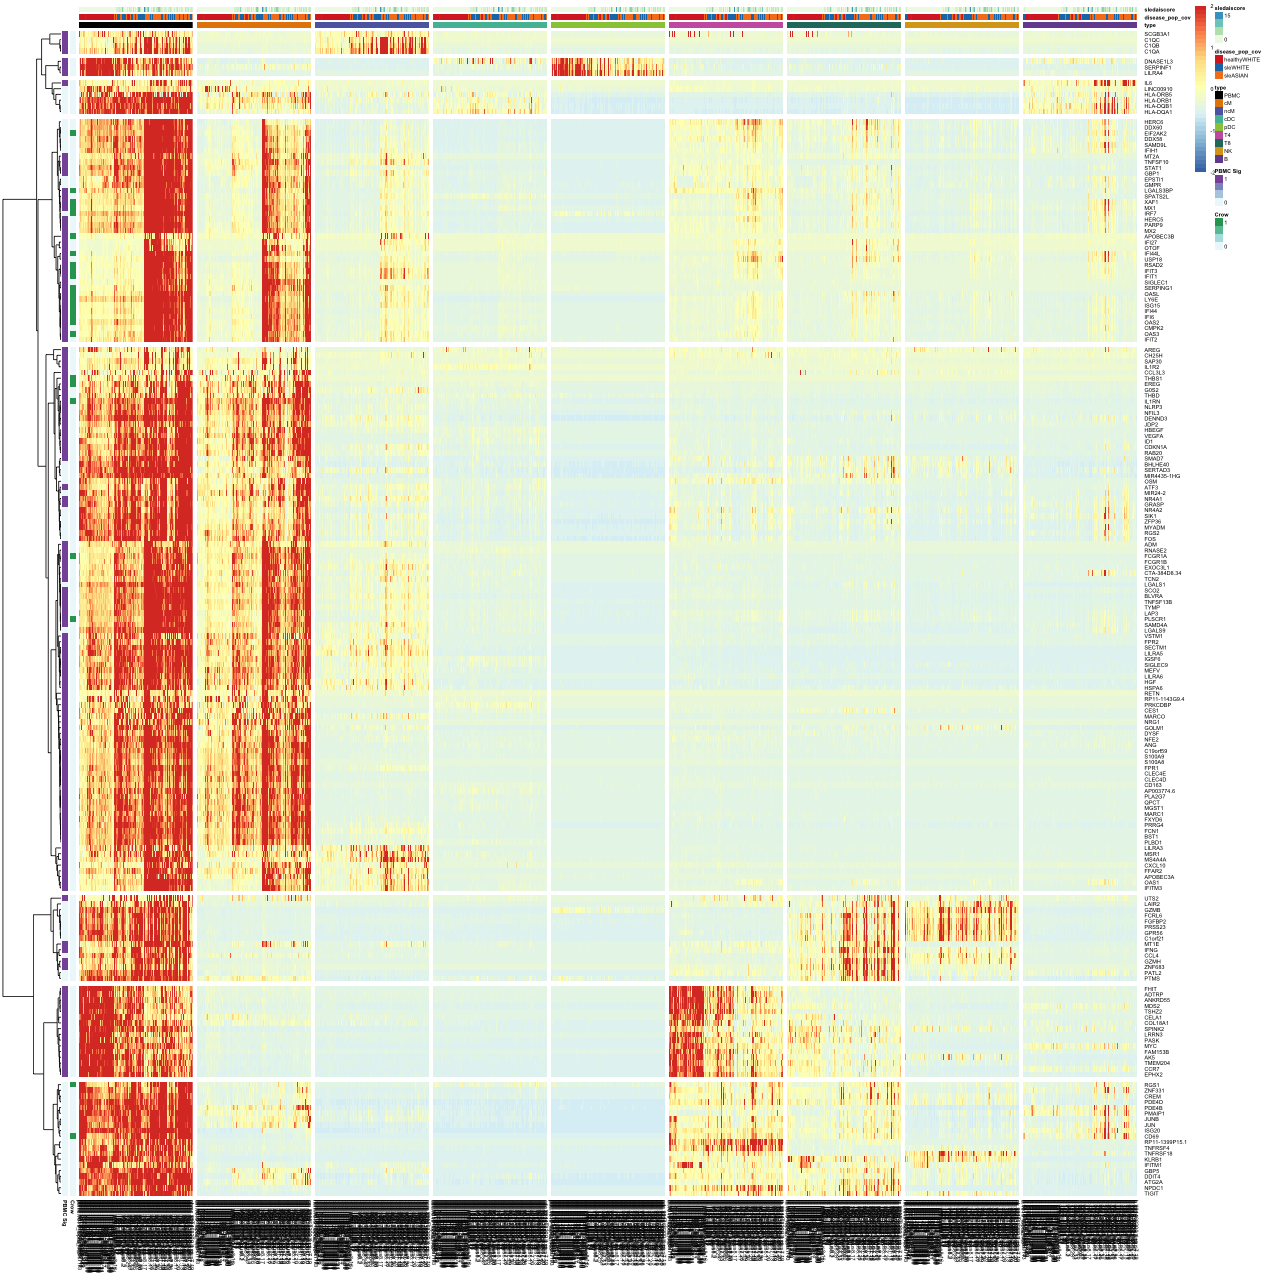

In [398]:
options(repr.plot.width = 16, repr.plot.height = 16)
breaksList = seq(-2, 2, by = .1)

mat <- t(as.matrix(apply(all_expr_pbmc_counts_sig,1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;

pheatmap_pbmc_counts_out <- pheatmap(mat,
         cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,#annotation_row = kmeans_annotation,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
                         cutree_rows=8, 
                         scale="none",fontsize=5,clustering_method="ward.D2",clustering_distance_row="correlation",
                            width=10, height=10)
options(repr.plot.width = 10, repr.plot.height = 4)


# pheatmap_pbmc_counts_out <- pheatmap(mat,
#          cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*(length(cell_types)-1),ncol(cm_expr_pbmc_counts)),
#                          cutree_rows=8,
#                          scale="row",fontsize=5,clustering_method="complete",clustering_distance_row="manhattan")

## now let's plot it by ordering the clusters in a reasonable way

In [399]:
cuttree_out_unordered <- cutree(pheatmap_pbmc_counts_out$tree_row, k = 8)
t(unique(cuttree_out_unordered[pheatmap_pbmc_counts_out$tree_row$order]))

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,] 6    3    7    4    2    5    1    8

In [400]:
cuttree_out_unordered[which(cuttree_out_unordered==6)] <- "ncM";
cuttree_out_unordered[which(cuttree_out_unordered==3)] <- "pDC";
cuttree_out_unordered[which(cuttree_out_unordered==7)] <- "B";
cuttree_out_unordered[which(cuttree_out_unordered==4)] <- "Pan";
cuttree_out_unordered[which(cuttree_out_unordered==2)] <- "Mono";
cuttree_out_unordered[which(cuttree_out_unordered==5)] <- "T8";
cuttree_out_unordered[which(cuttree_out_unordered==1)] <- "T4";
cuttree_out_unordered[which(cuttree_out_unordered==8)] <- "Lymph";

# cuttree_out[which(cuttree_out==1)] <- "T1";
# cuttree_out[which(cuttree_out==5)] <- "Mono";
# cuttree_out[which(cuttree_out==8)] <- "T2";
# cuttree_out[which(cuttree_out==2)] <- "Mye1";
# cuttree_out[which(cuttree_out==6)] <- "Pan";
# cuttree_out[which(cuttree_out==3)] <- "Lymph";
# cuttree_out[which(cuttree_out==4)] <- "Mye2";
cuttree_out_unordered <- factor(cuttree_out_unordered, levels=c("Pan","Mono","ncM","pDC","T4","T8","Lymph","B"), ordered=T)
cuttree_out <- cuttree_out_unordered[order(cuttree_out_unordered)];

##cuttree_out <- cuttree_out[pheatmap_pbmc_counts_out$tree_row$order];


# cuttree_out[which(cuttree_out==7)] <- "T3";
# cuttree_out[which(cuttree_out==1)] <- "T1";
# cuttree_out[which(cuttree_out==5)] <- "Mono";
# cuttree_out[which(cuttree_out==8)] <- "T2";
# cuttree_out[which(cuttree_out==2)] <- "Mye1";
# cuttree_out[which(cuttree_out==6)] <- "Pan";
# cuttree_out[which(cuttree_out==3)] <- "Lymph";
# cuttree_out[which(cuttree_out==4)] <- "Mye2";

cuttree_gene_names <- names(cuttree_out);
cuttree_out <- data.frame(cuttree_gene_names,cuttree_out)
colnames(cuttree_out) <- c("gene","cluster")
cuttree_out <- as.data.frame(cuttree_out);
##cuttree_out[,"cluster"] <- factor(cuttree_out[,"cluster"], levels=unique(as.character(cuttree_out[,"cluster"])))
cuttree_out[,"gene"] <- as.character(cuttree_out[,"gene"])
write.table(cuttree_out, file="diffexp.annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

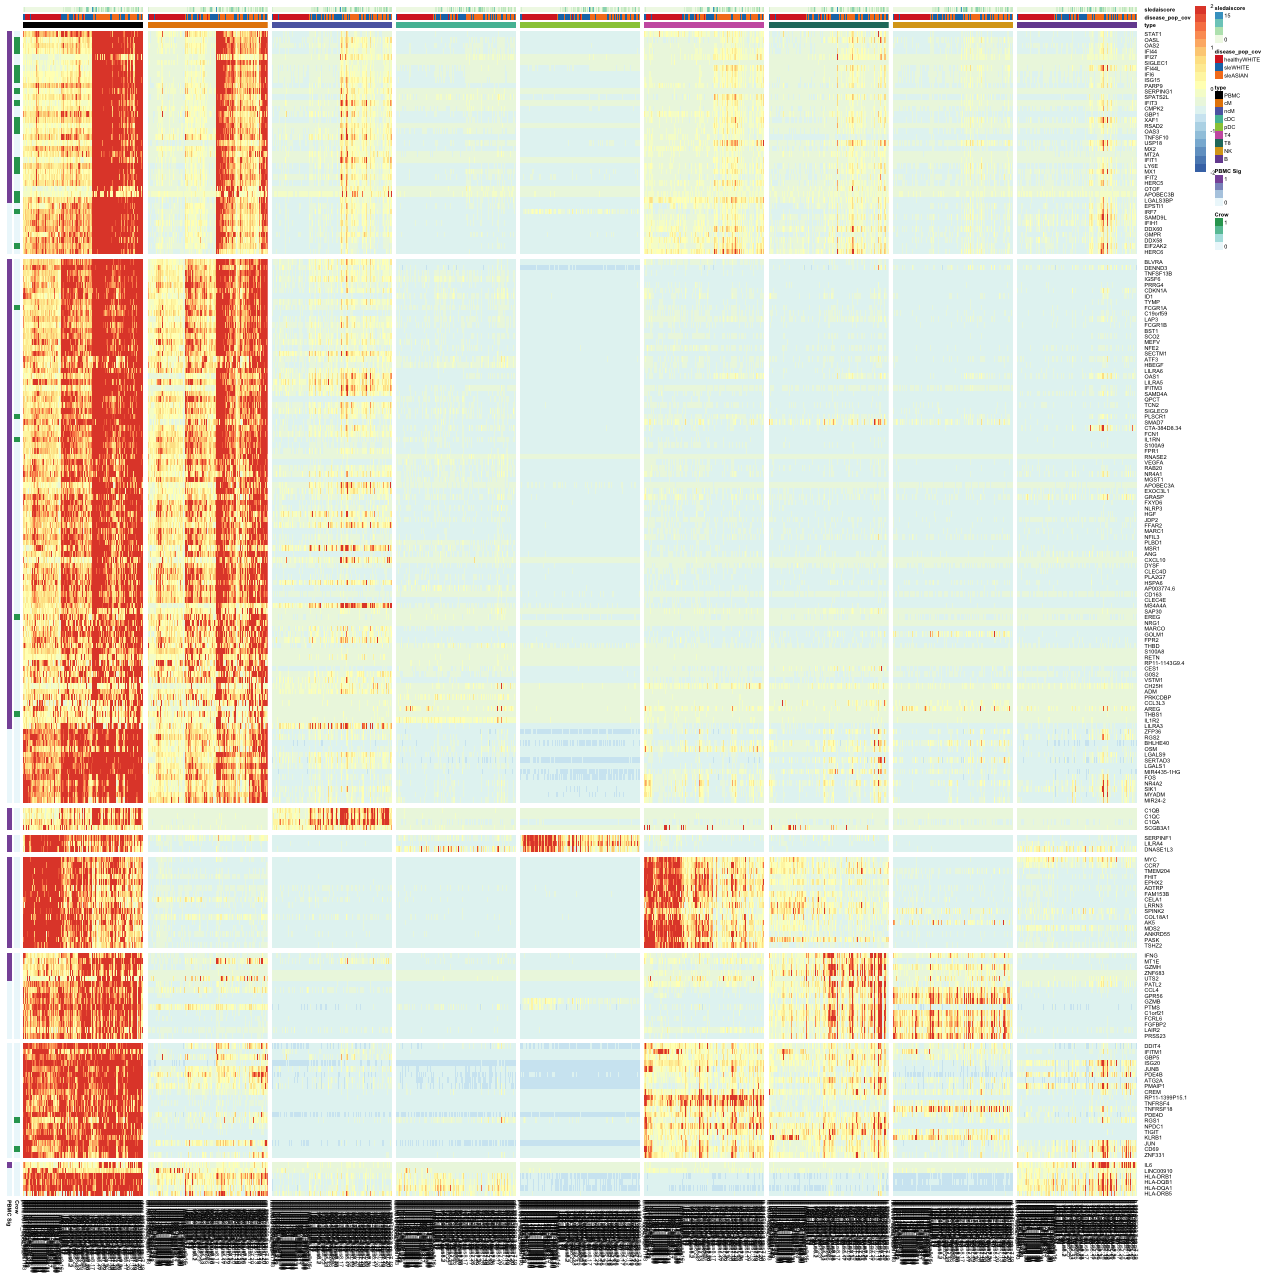

In [401]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2.8, 2.8, by = .2)

options(repr.plot.width = 16, repr.plot.height = 16)
min = -2;
max = 2;
breaksList = c(seq(-2, 2, by = .2))

# logged <- log(all_expr_pbmc_counts_sig+1)[cuttree_out$gene,];
# logged[which(logged>max)] = max;
# logged[which(logged<min)] = min;

mat <- t(as.matrix(apply(all_expr_pbmc_counts_sig[cuttree_out$gene,],1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;

pheatmap_pbmc_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
        gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                         scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan")

pheatmap_pbmc_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
      gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                   scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",filename="expr_pbmc_counts_heatmap.png")


options(repr.plot.width = 10, repr.plot.height = 4)

In [297]:
length(na.omit(match(rownames(row_annotations)[row_annotations$Crow==1],cuttree_out$gene[cuttree_out$cluster=="Pan"])))

[1] 17

In [298]:
length(na.omit(match(rownames(row_annotations)[row_annotations$Crow==1],cuttree_out$gene[cuttree_out$cluster=="Mono"])))

[1] 4

In [299]:
length(na.omit(match(rownames(row_annotations)[row_annotations$Crow==1],cuttree_out$gene)))

[1] 25

In [300]:
cuttree_out$gene[cuttree_out$cluster=="T8_1"]

[1] "DDIT4"          "IFITM1"         "ISG20"          "JUNB"          
 [5] "PDE4B"          "ATG2A"          "PMAIP1"         "CREM"          
 [9] "RP11-1399P15.1" "TNFRSF4"        "TNFRSF18"       "PDE4D"         
[13] "RGS1"           "NPDC1"          "TIGIT"          "KLRB1"         
[17] "JUN"            "CD69"           "ZNF331"

In [301]:
cuttree_out$gene[cuttree_out$cluster=="T8_2"]

[1] "IFNG"    "MT1E"    "GZMH"    "ZNF683"  "UTS2"    "GBP5"    "PATL2"  
 [8] "CCL4"    "GPR56"   "GZMB"    "PTMS"    "C1orf21" "FCRL6"   "FGFBP2" 
[15] "LAIR2"   "PRSS23"

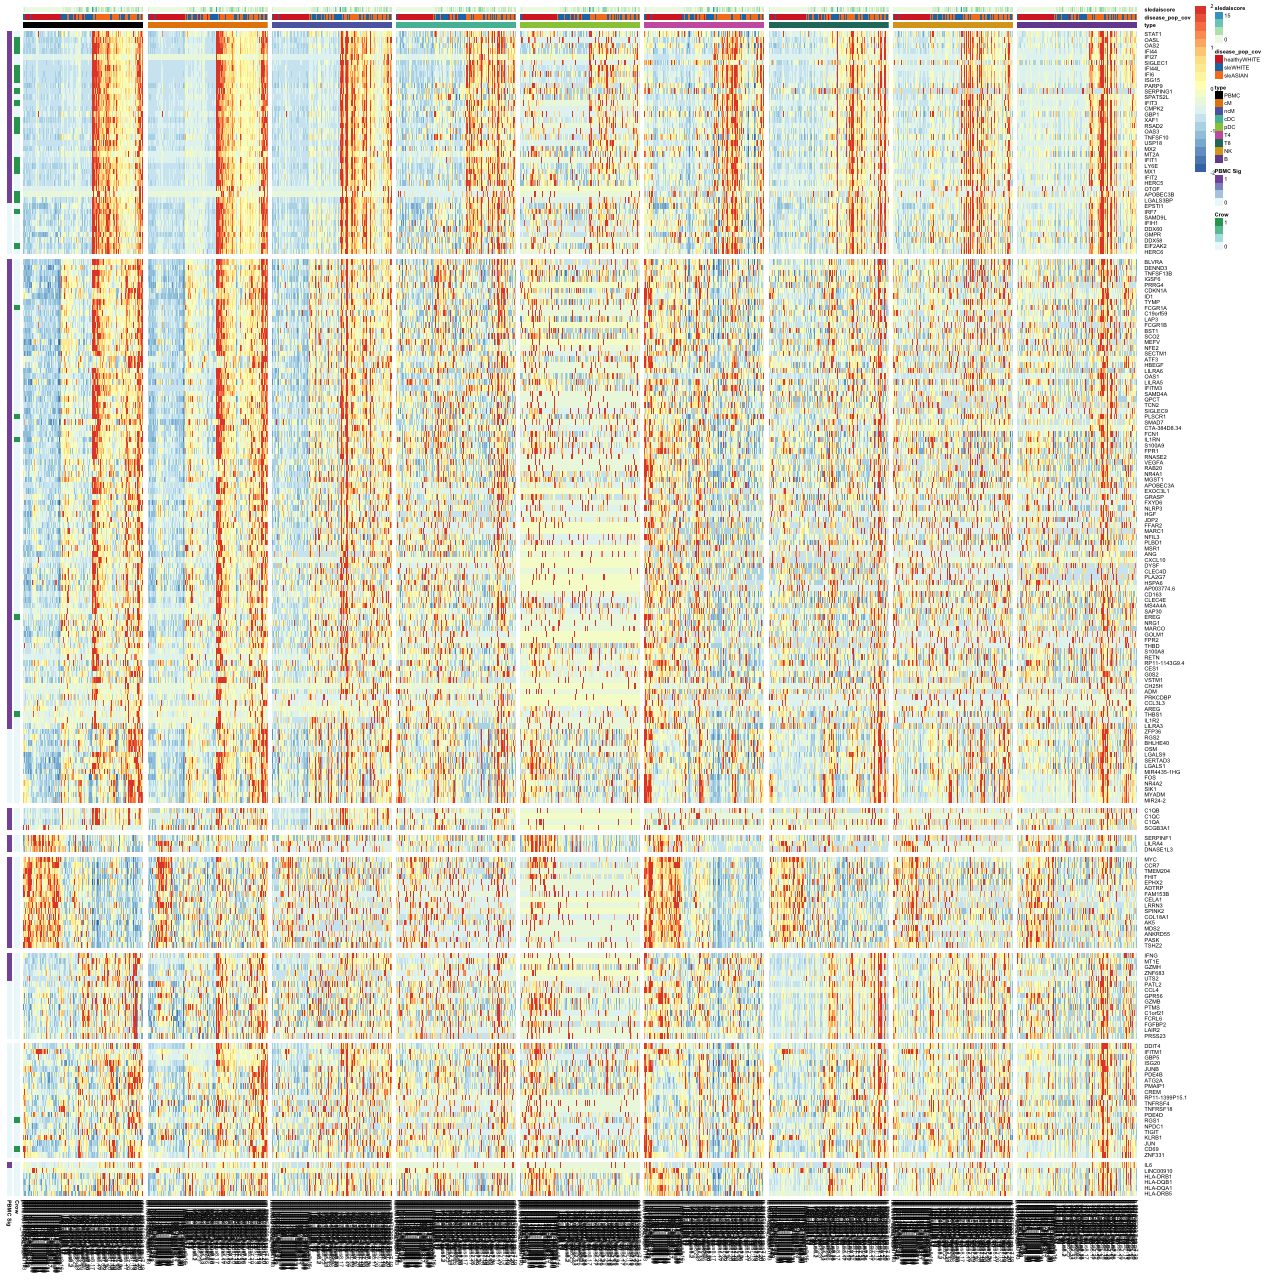

In [402]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2.8, 2.8, by = .2)

options(repr.plot.width = 16, repr.plot.height = 16)
breaksList = seq(-2, 2, by = .2)


mat <- t(as.matrix(apply(all_expr_pbmc_counts_std_sig[cuttree_out$gene,],1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;


pheatmap_ct_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*length(cell_types),ncol(cm_expr_ct_counts)),
                         gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                         scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan")

pheatmap_ct_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*length(cell_types),ncol(cm_expr_ct_counts)),
                         gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                         scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",filename="expr_ct_counts_heatmap.png")
options(repr.plot.width = 10, repr.plot.height = 4)

In [303]:
# # options(repr.plot.width = 16, repr.plot.height = 16)
# # breaksList = seq(-2.8, 2.8, by = .2)

# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2, 2, by = .2)

# pheatmap_ct_counts_out <- pheatmap(props,
#          cluster_rows=pheatmap_pbmc_counts_out$tree_row, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*length(cell_types),ncol(cm_expr_ct_counts)),
#                          cutree_rows=15, 
#                          scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan")

# pheatmap_ct_counts_out <- pheatmap(props,
#          cluster_rows=pheatmap_pbmc_counts_out$tree_row, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*length(cell_types),ncol(cm_expr_ct_counts)),
#                          cutree_rows=15, 
#                          scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",filename="props_heatmap.png")
# options(repr.plot.width = 10, repr.plot.height = 4)

## make some volcano plots

In [403]:
options(repr.plot.width = 4, repr.plot.height = 4)
pbmc_deseq$ifn=pbmc_deseq$V1 %in% ifn_crow$V1
pbmc_deseq$sig=rep("cnot significant",nrow(pbmc_deseq))
pbmc_deseq$sig[match(deseq_sig_genes, pbmc_deseq$V1)]="bct_sig";
pbmc_deseq$sig[match(pbmc_deseq_sig_genes, pbmc_deseq$V1)]="apbmc_sig";

pbmc_deseq <- pbmc_deseq[order(pbmc_deseq$sig,decreasing=T),]
# !(abs(pbmc_deseq$log2FoldChange)>1) & (which(pbmc_deseq$qval < 0.01))

lim=max(abs(pbmc_deseq$log2FoldChange)) + 0.2
min_lim=-lim

##pdf(paste(ct, '.volcano.pdf', sep=''), useDingbats=F)
g = ggplot(pbmc_deseq, aes(x=log2FoldChange, y=-log10(pvalue), color=sig))+ theme_linedraw()+theme(legend.position="none") + xlim(-4.5, 4.5) + geom_point()+geom_point(data=pbmc_deseq[pbmc_deseq$ifn,],
             pch=21, fill=NA, size=4, colour="black", stroke=1)+scale_color_grey()+scale_fill_grey()
ggsave(g, filename="pbmc_deseq.png", width=3, height=3, dpi=300)
##dev.off()


Warning message:
“Removed 1 rows containing missing values (geom_point).”

## More principled way to cut the tree and label the specific signatures

In [404]:
# cuttree_out <- cutree(pheatmap_pbmc_counts_out$tree_row, k = 10)
# cuttree_out <- cuttree_out[pheatmap_pbmc_counts_out$tree_row$order];
# # cuttree_out[which(cuttree_out==7)] <- "T3";
# # cuttree_out[which(cuttree_out==1)] <- "T1";
# # cuttree_out[which(cuttree_out==5)] <- "Mono";
# # cuttree_out[which(cuttree_out==8)] <- "T2";
# # cuttree_out[which(cuttree_out==2)] <- "Mye1";
# # cuttree_out[which(cuttree_out==6)] <- "Pan";
# # cuttree_out[which(cuttree_out==3)] <- "Lymph";
# # cuttree_out[which(cuttree_out==4)] <- "Mye2";

# cuttree_gene_names <- names(cuttree_out);
# cuttree_out <- cbind(cuttree_gene_names,cuttree_out)
# colnames(cuttree_out) <- c("gene","cluster")
# cuttree_out <- as.data.frame(cuttree_out);
# cuttree_out[,"cluster"] <- factor(cuttree_out[,"cluster"], levels=unique(as.character(cuttree_out[,"cluster"])))
# write.table(cuttree_out, file="diffexp.annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

In [405]:
# cuttree_out <- cutree(pheatmap_std_out$tree_row, k = 8)
# cuttree_out <- cuttree_out[pheatmap_std_out$tree_row$order];
# cuttree_out[which(cuttree_out==7)] <- "T3";
# cuttree_out[which(cuttree_out==1)] <- "T1";
# cuttree_out[which(cuttree_out==5)] <- "Mono";
# cuttree_out[which(cuttree_out==8)] <- "T2";
# cuttree_out[which(cuttree_out==2)] <- "Mye1";
# cuttree_out[which(cuttree_out==6)] <- "Pan";
# cuttree_out[which(cuttree_out==3)] <- "Lymph";
# cuttree_out[which(cuttree_out==4)] <- "Mye2";

# cuttree_gene_names <- names(cuttree_out);
# cuttree_out <- cbind(cuttree_gene_names,cuttree_out)
# colnames(cuttree_out) <- c("gene","cluster")
# cuttree_out <- as.data.frame(cuttree_out);
# cuttree_out[,"cluster"] <- factor(cuttree_out[,"cluster"], levels=unique(as.character(cuttree_out[,"cluster"])))
# write.table(cuttree_out, file="diffexp.annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

In [406]:
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Pan"]), file="Pan.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Mye2"]), file="Mye2.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Mye1"]), file="Mye1.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Mono"]), file="Mono.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="T1"]), file="T1.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="T2"]), file="T2.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="T3"]), file="T3.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Lymph"]), file="Lymph.txt", row.names=F, col.names=F, quote=F, sep=",")

# write.table(as.character(cuttree_out$gene), file="All.txt", row.names=F, col.names=F, quote=F, sep=",")



# Figure 2B - correlogram to show coexpressed genes

In [407]:
# no_pbmc_cor <- cor(t(all_expr_sig[,-c(1,ncol(pbmc_expr))]))
# options(repr.plot.width = 6, repr.plot.height = 6)
# pheatmap(no_pbmc_cor,
#          cluster_rows=pheatmap_out$tree_row, cluster_cols=pheatmap_out$tree_row, #annotation_row = kmeans_annotation,
#          fontsize=3)
# options(repr.plot.width = 4, repr.plot.height = 4)

In [408]:
# cor(joined_pivot$sledaiscore, joined_pivot$cM)
# cor(joined_pivot_sle$sledaiscore, joined_pivot_sle$cM)
# cor(joined_pivot_sle$sledaiscore[which(joined_pivot_sle$disease_pop_cov=="sleWHITE")], joined_pivot_sle$cM[which(joined_pivot_sle$disease_pop_cov=="sleWHITE")])
# cor(joined_pivot_sle$sledaiscore[which(joined_pivot_sle$disease_pop_cov=="sleASIAN")], joined_pivot_sle$cM[which(joined_pivot_sle$disease_pop_cov=="sleASIAN")])
# cor(joined_pivot_sle$sledaiscore, colMeans(pbmc_sle_expr_std[match(deseq_sig_genes,rownames(pbmc_sle_expr_std)),]))
# cor(joined_pivot_sle$sledaiscore, colMeans(pbmc_sle_expr_std[match(cuttree_out$gene[cuttree_out$cluster=="Pan"],rownames(pbmc_sle_expr_std)),]))
# cor(joined_pivot_sle$sledaiscore, colMeans(cm_sle_expr_std[match(cuttree_out$gene[cuttree_out$cluster=="Pan"],rownames(pbmc_sle_expr_std)),]))
# cor(joined_pivot_sle$sledaiscore, colMeans(pbmc_sle_expr_std[match(cuttree_out$gene,rownames(pbmc_sle_expr_std)),]))
# cor(joined_pivot_sle$sledaiscore, colMeans(pbmc_sle_expr_std[match(cuttree_out$gene[cuttree_out$cluster=="Lymph"],rownames(pbmc_sle_expr_std)),]))


# cor(joined_pivot_sle$sledaiscore[which(joined_pivot_sle$disease_pop_cov=="sleWHITE")], colMeans(cm_sle_expr_std[match(cuttree_out$gene[cuttree_out$cluster=="Pan"],rownames(pbmc_sle_expr_std)),])[which(joined_pivot_sle$disease_pop_cov=="sleWHITE")])
# cor(joined_pivot_sle$sledaiscore[which(joined_pivot_sle$disease_pop_cov=="sleASIAN")], colMeans(cm_sle_expr_std[match(cuttree_out$gene[cuttree_out$cluster=="Pan"],rownames(pbmc_sle_expr_std)),])[which(joined_pivot_sle$disease_pop_cov=="sleASIAN")])

# Figure 2C: Proportion of variance explained


First, we are going to estimate proportion of variance explained by cell type proportion

This will be a multiple regression

\begin{equation*}
e_i = -1 + b_1\times p_1 + b_2\times p_2 + ... + b_n\times p_n
\end{equation*}

Next, we are going to estimate proportion of variance explained by cell type specific expression

This will be a multiple regression


\begin{equation*}
e_i = -1 + b_1\times e_1 + b_2\times e_2 + ... + b_n\times e_n
\end{equation*}

calculate adjusted r_2 and also the cell type specific r2

Y_i = %mono*mono_i + %other*other_i + err
Or
Y_i = %mono*mono_i
log(Y_i) = log(%mono)+log(mono_i)+err


## Let's define some useful functions

## Processing all - now, let's fit with -1 but we need to standardize the outcome

In [409]:
# i = 347;

# expr <- pbmc_expr;
# props <- props;
# exprs <- exprs;
# expr_res <- pbmc_expr;
# cov_prop_mat <- cov(props);

# model <- lm(expr[i,]~props-1)
# coef = summary(model)$coef[,1];
# expr_res[i,] <- residuals(model);

# vars_prop = NULL;
        
# for(j in 1:ncol(props)) {
#             var_j_prop = sum(cov_prop_mat[j,]*coef[j]*coef);
#             vars_prop <- c(vars_prop, var_j_prop);
#         }
        
#         r2s_prop = vars_prop/sum(vars_prop);
        
#         r2_prop = sum(vars_prop)/var(expr[i,]);
#         r2_prop_adj = r2_prop-(1-r2_prop)*(ncol(props))/(ncol(expr)-ncol(props)-1);

#         cov_expr_mat <- cov(exprs[i,,]);
        
#         vars_expr <- NULL;
#         covars_expr <- NULL;
        
#         for(j in 1:dim(exprs)[[3]]) {
#             var_j_expr = diag(cov_expr_mat)[[j]]; ##sum(cov_expr_mat[j,]);
#             covar_j_expr = sum(cov_expr_mat[j,])-diag(cov_expr_mat)[[j]];
#             vars_expr <- c(vars_expr, var_j_expr);
#             covars_expr <- c(covars_expr, covar_j_expr)
#         }
        
#         if(i == 1){
#             print(cov_expr_mat);
#             print(var_j_expr)};
        
#         r2s_expr = vars_expr/sum(vars_expr);
#         r2_expr = sum(vars_expr)/var(expr_res[i,]);
#         r2_expr_adj = r2_expr-(1-r2_expr)*dim(exprs)[[3]]/(ncol(expr)-dim(exprs)[[3]]-1);
    
#         r2s_covar_expr = covars_expr/sum(covars_expr);
#         r2_covar_expr = sum(covars_expr)/var(expr_res[i,]);
#         r2_covar_expr_adj = r2_covar_expr-(1-r2_covar_expr)*dim(exprs)[[3]]/(ncol(expr)-dim(exprs)[[3]]-1);
    
# var(expr[i,])
# t(vars_expr)
# t(covars_expr)
# sum(t(vars_expr))/var(expr[i,])
# sum(t(covars_expr))/var(expr[i,])
# sum(t(covars_expr))/var(expr[i,])

# sum(cov_expr_mat[j,])

In [410]:
# source("helper_functions.R")
# output_prop_expr_noint_noah <- model_prop_expr_noah(pbmc_expr, props, exprs);
# # output_prop_noint <- model_prop(pbmc_expr_std, props);
# # output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);
# output_prop_noint_noah <- output_prop_expr_noint_noah[[1]];
# output_expr_noint_noah <- output_prop_expr_noint_noah[[2]];
# output_covar_expr_noint_noah <- output_prop_expr_noint_noah[[3]];

In [411]:
# mean(output_prop_noint_noah[,"total r2"])
# mean(output_expr_noint_noah[,"total r2"])
# mean(output_covar_expr_noint_noah[,"total r2"])

In [412]:
# t(output_expr_noint_noah[347,])

# write.table(pbmc_expr["CD14",],file="pbmc.counts");
# write.table(props, file="cell.props")
# write.table(exprs["CD14",,], file="ct.counts")
# write.table(pbmc_total[match(colnames(exprs),names(pbmc_total))], file="cell.counts")

In [506]:
source("helper_functions.R")
output_prop_expr_noint <- model_prop_expr_noah(pbmc_expr, props, exprs_pbmc_counts);
# output_prop_noint <- model_prop(pbmc_expr_std, props);
# output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);
output_prop_noint <- output_prop_expr_noint[[1]];
output_expr_noint <- output_prop_expr_noint[[4]];
output_expr_pbmc_count_noint <- output_prop_expr_noint[[7]];


In [507]:
head(output_expr_pbmc_count_noint,20)

cM         Th         B          NK         ncM        
RP11-34P13.7   28.643763 23.3723877 13.9065882  3.3244008  8.35918971
AL627309.1     88.860057  0.6610447  0.3247898  0.8490839  6.37756626
AP006222.2     21.781365 15.5666594 11.3896286  9.6309550  9.88914094
RP4-669L17.10  23.843058 30.0840554 12.5578414  6.7863843  5.59706213
RP11-206L10.3  60.092956 11.5471333  6.3017062  1.8184616  9.09506692
RP11-206L10.2  38.246301 21.5341824  9.5306956  5.2314975  5.52593304
RP11-206L10.9  15.293605 27.6103539 12.4203906 10.5649099  2.92502465
FAM87B         45.540232 18.5863978  4.2578009  2.5814281 12.29378971
LINC00115      30.077492 18.6227649 11.8669996  8.0265271  9.52082177
FAM41C         16.727740 25.5526152 23.2795696  5.8777419  3.74310767
NOC2L         -12.099835 44.9916725 23.6098231 14.1451346  2.15820625
KLHL17         41.714608 17.2642084  9.8004917  3.9021165  6.55969488
PLEKHN1        50.989638 24.8551756  1.1880032  3.1566112  1.10110252
RP11-54O7.17   51.588592  1.1139277  0.9982216  0.3128655 39.67889961
HES4           19.007481  1.1486577  0.4856434  1.7100782 76.22348362
ISG15          57.308417  6.6952558  3.6865268  3.0186325 14.29914058
AGRN           76.520532  1.3020979  4.9815693  1.0494356  4.79303716
C1orf159       21.049022 25.0968050 10.1353623 12.4525438  6.67156461
TTLL10          1.838992 33.4055017 25.4912505 27.7771098  0.46518276
TNFRSF18        0.384936 22.0459678  2.0369360 69.7168840 -0.01136243
              Tc         cDC         pDC         total r2  adj r2   
RP11-34P13.7  15.7935298  1.88823240  0.87983810  96.16793  95.97015
AL627309.1     1.3633034  0.44660139  0.22263094  99.10508  99.05889
AP006222.2    16.5599470  2.25677953  0.46403474  87.53851  86.89534
RP4-669L17.10 13.6930274  2.84248916  0.86394015  96.26786  96.07523
RP11-206L10.3  6.7773783  0.64744966  1.99524508  98.27540  98.18639
RP11-206L10.2 14.3482648  3.40250734  0.81492281  98.63430  98.56382
RP11-206L10.9 20.5363543  4.45654351  2.79182136  96.59900  96.42347
FAM87B        11.1261752  5.87622802  0.00000000 100.26205 100.27558
LINC00115     15.8921482  2.57355221  0.32144114  96.90175  96.74184
FAM41C        17.7747284  1.55117501  2.41859589  96.92527  96.76658
NOC2L         23.4092130 -0.23997484  0.62785180  96.60209  96.42672
KLHL17        19.0472406  2.64566101  0.19581565 101.12984 101.18815
PLEKHN1       13.4167375  2.20461535 -0.01923643  96.89265  96.73227
RP11-54O7.17   3.3189844  1.39782413  1.18425566  99.59357  99.57259
HES4           0.4664901  0.17681436  0.15625556  99.37490  99.34264
ISG15          7.0315049  1.72743142  0.29721912  94.06413  93.75776
AGRN           6.2315835  1.73459632  0.30166399  96.91452  96.75526
C1orf159      21.7285759  0.98589100  0.98312461  99.10289  99.05659
TTLL10         4.5716559  0.78716498  0.29111053  94.62797  94.35070
TNFRSF18       1.8909139 -0.07376541  0.05202813  96.04254  95.83828

In [508]:
# output_prop_expr_noint_prop_rand <- model_prop_expr_noah(pbmc_expr, props[sample(1:nrow(props)),], exprs);
# # output_prop_noint <- model_prop(pbmc_expr_std, props);
# # output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);
# output_prop_noint_prop_rand <- output_prop_expr_noint_prop_rand[[1]];
# output_expr_noint_prop_rand <- output_prop_expr_noint_prop_rand[[2]];
# mean(output_prop_noint_prop_rand[,"adj prop_expr r2"])

In [509]:
# output_prop_expr_noint_expr_rand <- model_prop_expr_noah(pbmc_expr, props, exprs[,sample(dimnames(exprs)[[2]]),]);
# # output_prop_noint <- model_prop(pbmc_expr_std, props);
# # output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);
# output_prop_noint_expr_rand <- output_prop_expr_noint_expr_rand[[1]];
# output_expr_noint_expr_rand <- output_prop_expr_noint_expr_rand[[2]];
# mean(output_prop_noint_expr_rand[,"adj prop_expr r2"])

In [510]:
# output_prop_expr_noint_both_rand <- model_prop_expr_noah(pbmc_expr[,sample(colnames(pbmc_expr))], props, exprs);
# # output_prop_noint <- model_prop(pbmc_expr_std, props);
# # output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);
# output_prop_noint_both_rand <- output_prop_expr_noint_both_rand[[1]];
# output_expr_noint_both_rand <- output_prop_expr_noint_both_rand[[2]];
# mean(output_prop_noint_both_rand[,"adj prop_expr r2"])

## testing out nnls fit

In [511]:
# model_lm <- lm(pbmc_expr_std[407,]~props+exprs_std[407,,]-1)
# ##model_nnls <- nnls(cbind(props,exprs_std[407,,]), pbmc_expr_std[407,])
# model_nnls <- nnls(cbind(props), pbmc_expr_std[407,])

# cov_mat <- cov(cbind(props, exprs_std[407,,]));

# vars_lm <- NULL;
# coef = summary(model_lm)$coef[,1]
# for(j in 1:(ncol(props)+dim(exprs)[[3]])) {
#             var_j = sum(cov_mat[j,]*coef[j]*coef);
#             vars_lm <- c(vars_lm, var_j);
#         }

# vars_nnls <- NULL;
# coef = model_nnls$x
# # for(j in 1:(ncol(props)+dim(exprs)[[3]])) {
# #             var_j = sum(cov_mat[j,]*coef[j]*coef);
# #             vars_nnls <- c(vars_nnls, var_j);
# #         }

# for(j in 1:(ncol(props))) {
#             var_j = sum(cov_mat[j,]*coef[j]*coef);
#             vars_nnls <- c(vars_nnls, var_j);
#         }

# vars_lm/sum(vars_lm)*100

## Processing SLE

In [512]:
output_sle_prop_expr_noint <- model_prop_expr_noah(pbmc_sle_expr, props_sle, exprs_sle_pbmc_counts);
# output_sle_prop_noint <- model_prop(pbmc_sle_expr_std, props_sle);
# output_sle_expr_noint <- model_expr(pbmc_sle_expr_std, exprs_sle_std);
output_sle_prop_noint <- output_sle_prop_expr_noint[[1]];
output_sle_expr_noint <- output_sle_prop_expr_noint[[4]];
output_sle_expr_pbmc_count_noint <- output_sle_prop_expr_noint[[7]];

In [513]:
# output_sle_prop_noint_small <- model_prop(pbmc_sle_expr_std[1:100,], props_sle);
# output_sle_expr_noint_small <- model_expr(pbmc_sle_expr_std[1:100,], exprs_sle_std);

### Downsampled SLE to 46 samples

In [514]:
dim(props_sle)

[1] 114   8

In [515]:
## including dc analysis
##N <- 22;
samples_asian <- which(joined_pivot$disease_pop_cov=="sleASIAN")
samples_white <- which(joined_pivot$disease_pop_cov=="sleWHITE")

## including dc analysis
output_sle_asian_prop_expr_noint <- model_prop_expr_noah(pbmc_expr[,samples_asian], props[samples_asian,], exprs_pbmc_counts[,samples_asian,]);
# output_sle_asian_prop_noint <- model_prop(pbmc_sle_expr_std[,samples_asian], props_sle[samples_asian,]);
# output_sle_asian_expr_noint <- model_expr(pbmc_sle_expr_std[,samples_asian], exprs_sle_std[,samples_asian,]);
output_sle_asian_prop_noint <- output_sle_asian_prop_expr_noint[[1]];
output_sle_asian_expr_noint <- output_sle_asian_prop_expr_noint[[4]];
output_sle_asian_expr_pbmc_count_noint <- output_sle_asian_prop_expr_noint[[7]];

output_sle_white_prop_expr_noint <- model_prop_expr_noah(pbmc_expr[,samples_white], props[samples_white,], exprs_pbmc_counts[,samples_white,]);
# output_sle_white_prop_noint <- model_prop(pbmc_sle_expr_std[,samples_white], props_sle[samples_white,]);
# output_sle_white_expr_noint <- model_expr(pbmc_sle_expr_std[,samples_white], exprs_sle_std[,samples_white,]);
output_sle_white_prop_noint <- output_sle_white_prop_expr_noint[[1]];
output_sle_white_expr_noint <- output_sle_white_prop_expr_noint[[4]];
output_sle_white_expr_pbmc_count_noint <- output_sle_white_prop_expr_noint[[7]];

# samples <- sample(1:ncol(pbmc_sle_expr_std), N)
# output_sle_down_prop_noint <- model_prop(pbmc_sle_expr_std[,samples], props_sle[samples,]);
# output_sle_down_expr_noint <- model_expr(pbmc_sle_expr_std[,samples], exprs_sle_std[,samples,]);


In [516]:
# test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^IL6$",expr_gene_names)[1])
# test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^ERAP2$",expr_gene_names)[1])
# test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^CD3E$",expr_gene_names)[1])
# test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^UTS2$",expr_gene_names)[1])


In [517]:
samples_asian

[1]   4   5   6   7  12  14  20  21  22  24  26  27  30  32  33  34  35  36  37
[20]  41  42  46  47  48  50  52  55  56  57  58  59  60  65  66  67  69  70  71
[39]  72  74  81  87  89  90  91  92  94  97  98 101 102 104 105 107 108 110 111
[58] 112 113 114

In [518]:
broad_healthy_indices

[1] 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
[20] 144 147 148 149 150 151 152 153 154

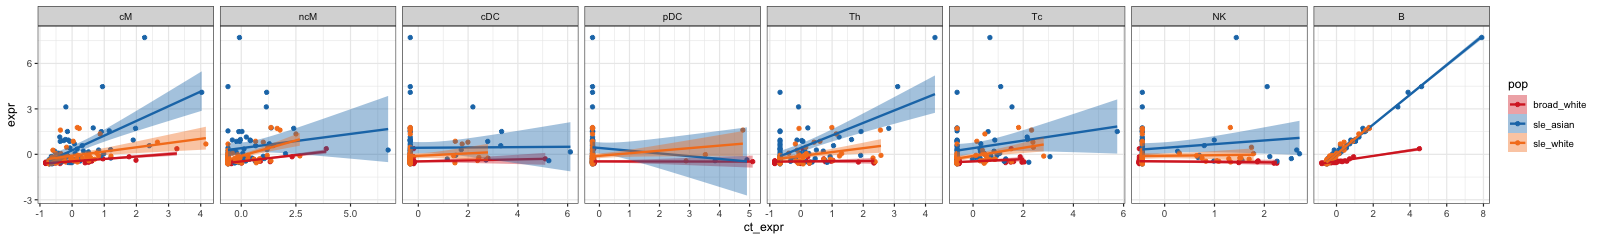

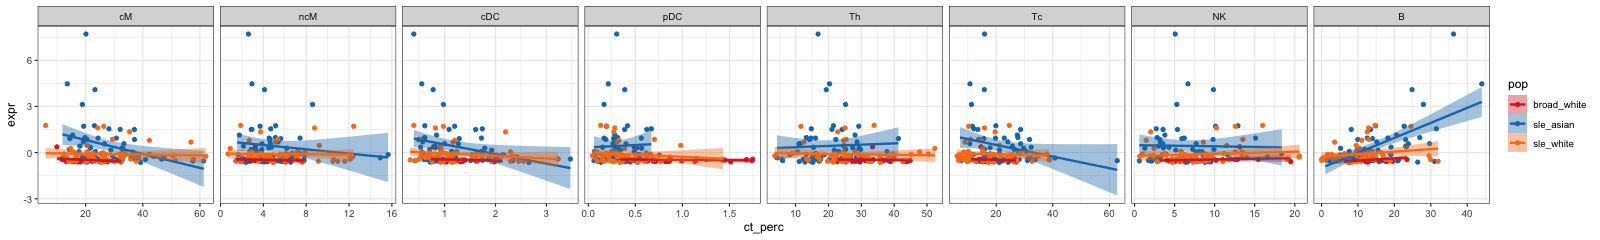

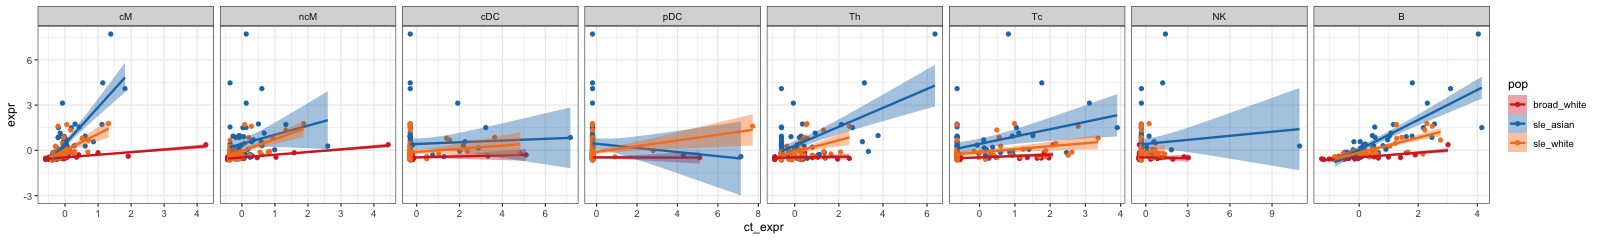

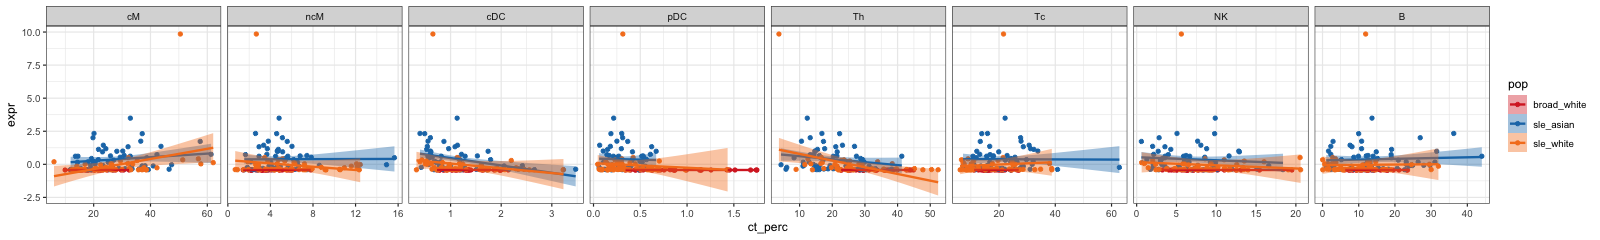

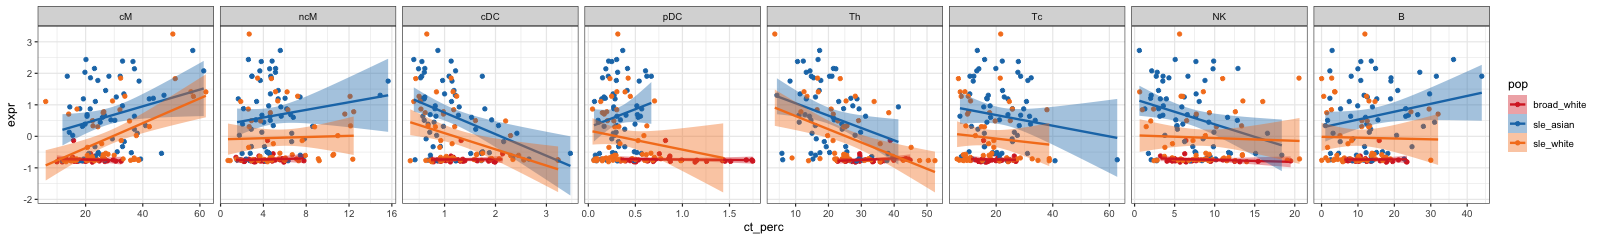

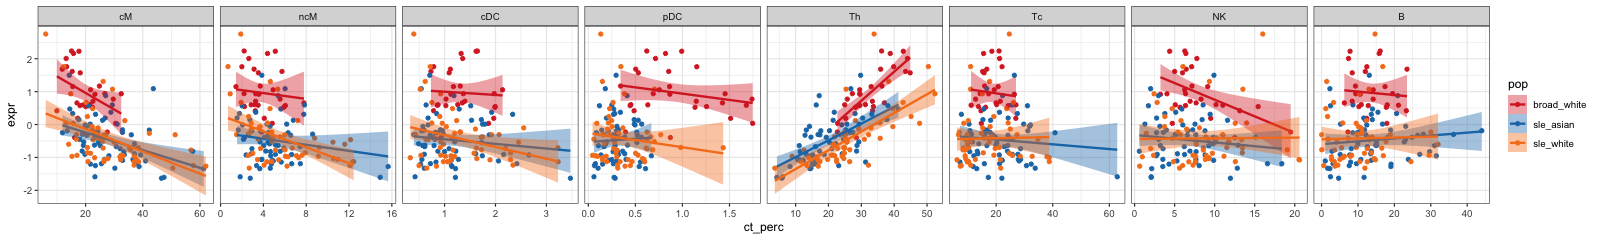

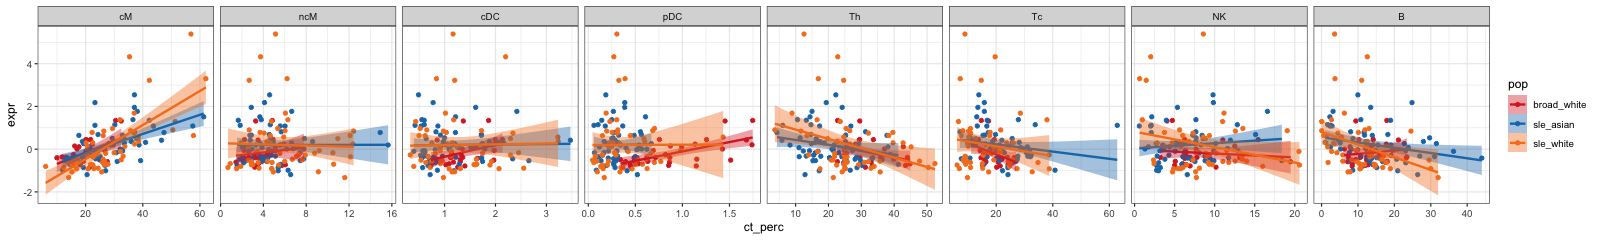

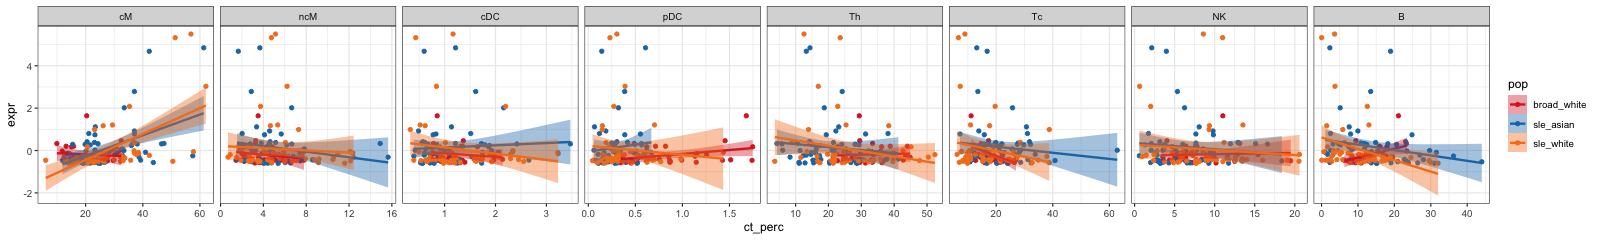

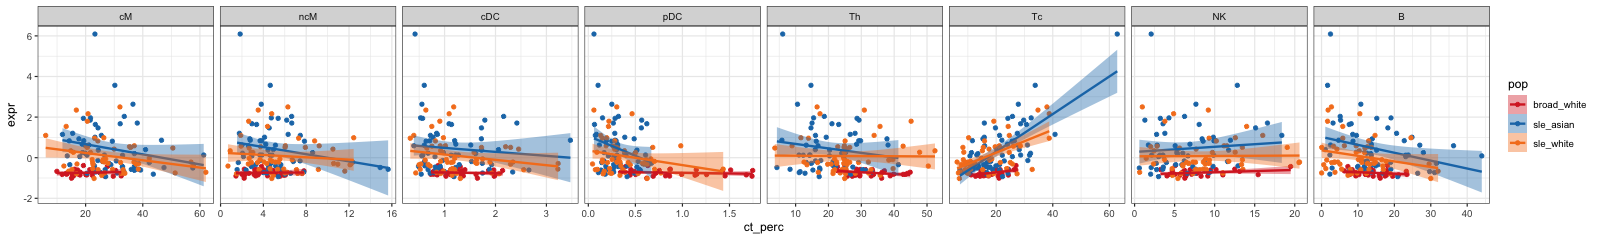

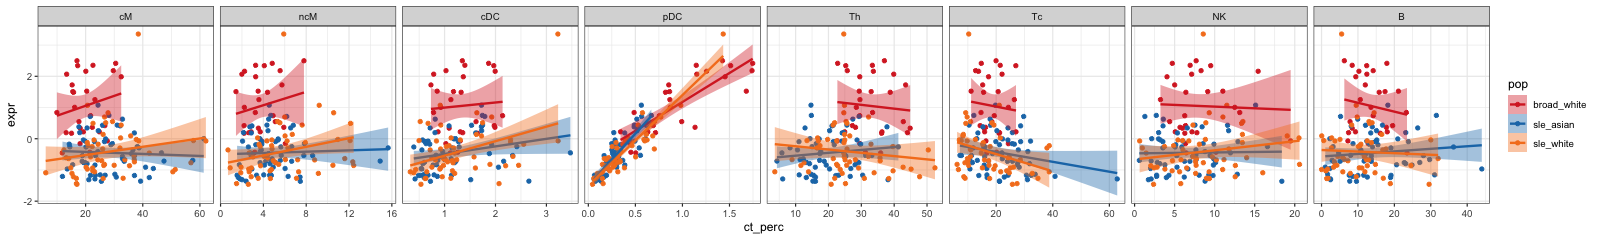

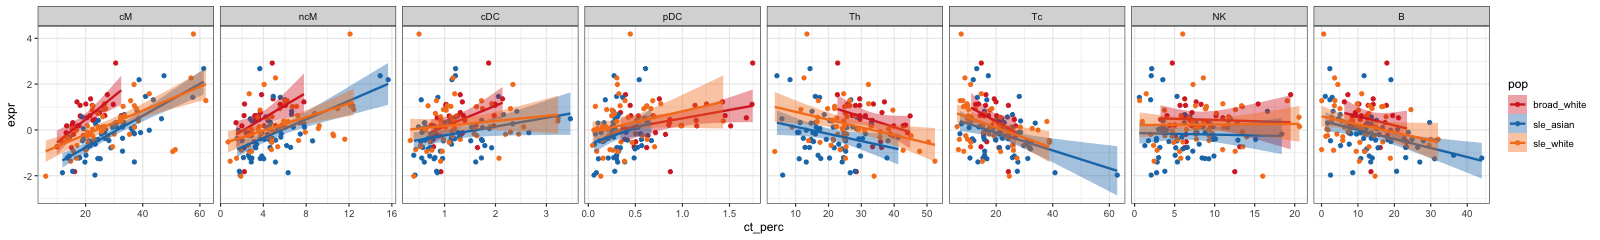

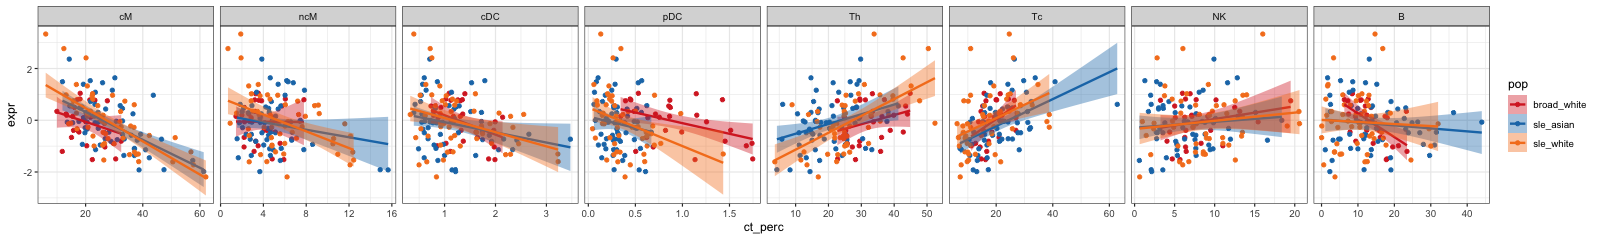

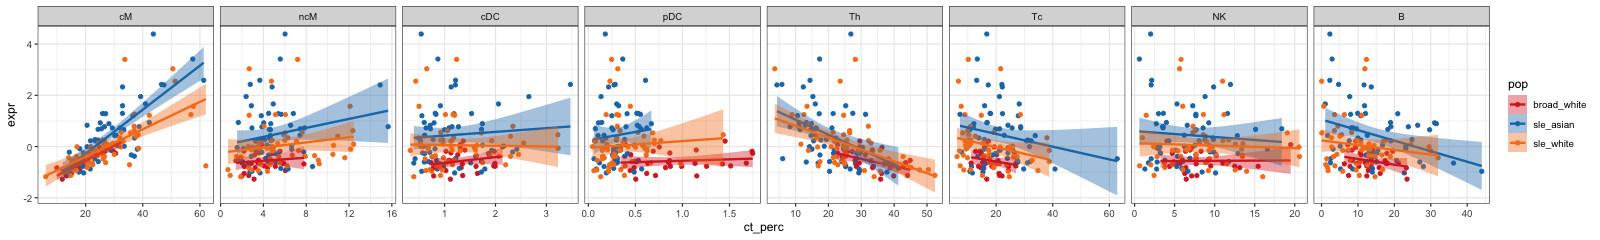

In [519]:
source("helper_functions.R")
options(repr.plot.width = 20, repr.plot.height = 3)
props_all = rbind(data.frame(props_broad_healthy,pop="broad_white"),
                  data.frame(props[samples_asian,],pop="sle_asian"),
                  data.frame(props[samples_white,],pop="sle_white"))

exprs_all_pbmc_counts = list(exprs_broad_healthy_std_pbmc_counts, exprs_pbmc_counts_std[,samples_asian,], exprs_pbmc_counts_std[,samples_white,])
exprs_all_ct_counts = list(exprs_broad_healthy_std_ct_counts, exprs_ct_counts_std[,samples_asian,], exprs_ct_counts_std[,samples_white,])

##expr_all = cbind(pbmc_broad_healthy_expr, pbmc_expr[,c(samples_asian,samples_white)])
expr_all = pbmc_expr_std[,c(broad_healthy_indices, samples_asian, samples_white)]

il6 <- plot_single_gene_expr(expr_all, exprs_all_pbmc_counts, grep("^IL6$",expr_gene_names)[1])
ggsave(il6, file="IL6_all.png",width=11, height=1.75)

il6 <- plot_single_gene_prop(expr_all, props_all, grep("^IL6$",expr_gene_names)[1])
ggsave(il6, file="IL6_prop.png",width=11, height=1.75)

il6 <- plot_single_gene_expr(expr_all, exprs_all_ct_counts, grep("^IL6$",expr_gene_names)[1])
ggsave(il6, file="IL6_expr.png",width=11, height=1.75)

## ifi27 asian vs cau differences
ifi27 <- plot_single_gene_prop(expr_all, props_all, grep("^IFI27$",expr_gene_names)[1])
ggsave(ifi27, file="IFI27.png",width=11, height=2)
ifi44l <- plot_single_gene_prop(expr_all, props_all, grep("^IFI44L$",expr_gene_names)[1])
ggsave(ifi44l, file="IFI44L.png",width=11, height=2)
ccr7 <- plot_single_gene_prop(expr_all, props_all, grep("^CCR7$",expr_gene_names)[1])
ggsave(ccr7, file="CCR7.png",width=11, height=2)
nlrp3 <- plot_single_gene_prop(expr_all, props_all, grep("^NLRP3$",expr_gene_names)[1])
ggsave(nlrp3, file="NLRP3.png", width=11, height=2)
thbs1 <- plot_single_gene_prop(expr_all, props_all, grep("^THBS1$",expr_gene_names)[1])
ggsave(thbs1, file="THBS1.png", width=11, height=2)
ifng <- plot_single_gene_prop(expr_all, props_all, grep("^IFNG$",expr_gene_names)[1])
ggsave(ifng, file="IFNG.png",width=11, height=2)
lilra4 <- plot_single_gene_prop(expr_all, props_all, grep("^LILRA4$",expr_gene_names)[1])
ggsave(lilra4, file="LILRA4.png",width=11, height=2)
cd4 <- plot_single_gene_prop(expr_all, props_all, grep("^CD4$",expr_gene_names)[1])
ggsave(cd4, file="CD4.png",width=11, height=2)
lck <- plot_single_gene_prop(expr_all, props_all, grep("^LCK$",expr_gene_names)[1])
ggsave(lck, file="LCK.png",width=11, height=2)
cd14 <- plot_single_gene_prop(expr_all, props_all, grep("^CD14$",expr_gene_names)[1])
ggsave(cd14, file="CD14.png",width=11, height=2)


## Processing UCSF healthy

In [520]:
output_ucsf_healthy_prop_expr_noint <- model_prop_expr_noah(pbmc_ucsf_healthy_expr, props_ucsf_healthy, exprs_ucsf_healthy_pbmc_counts);
# output_ucsf_healthy_prop_noint <- model_prop(pbmc_ucsf_healthy_expr_std, props_ucsf_healthy);
# output_ucsf_healthy_expr_noint <- model_expr(pbmc_ucsf_healthy_expr_std, exprs_ucsf_healthy_std);
output_ucsf_healthy_prop_noint <- output_ucsf_healthy_prop_expr_noint[[1]]
output_ucsf_healthy_expr_noint <- output_ucsf_healthy_prop_expr_noint[[4]]
output_ucsf_healthy_expr_pbmc_count_noint <- output_ucsf_healthy_prop_expr_noint[[7]]

## Processing Broad healthy

In [521]:
output_broad_healthy_prop_expr_noint <- model_prop_expr_noah(pbmc_broad_healthy_expr, props_broad_healthy, exprs_broad_healthy_pbmc_counts);
# output_broad_healthy_prop_noint <- model_prop(pbmc_broad_healthy_expr_std, props_broad_healthy);
# output_broad_healthy_expr_noint <- model_expr(pbmc_broad_healthy_expr_std, exprs_broad_healthy_std);
output_broad_healthy_prop_noint <- output_broad_healthy_prop_expr_noint[[1]];
output_broad_healthy_expr_noint <- output_broad_healthy_prop_expr_noint[[4]];
output_broad_healthy_expr_pbmc_count_noint <- output_broad_healthy_prop_expr_noint[[7]];


## matching ucsf and broad

In [522]:
# a <- match(sapply(rownames(props_ucsf_healthy),function(x){strsplit(x,"_")[[1]][[1]]}), sapply(rownames(props_broad_healthy), function(x) {strsplit(x,"_")[[1]][[1]]}))

# props_ucsf_healthy_matched <- props_ucsf_healthy[!is.na(a),]
# props_broad_healthy_matched <- props_broad_healthy[na.omit(a),]

# pbmc_ucsf_healthy_expr_matched <- pbmc_ucsf_healthy_expr[,!is.na(a)]
# pbmc_broad_healthy_expr_matched <- pbmc_broad_healthy_expr[,na.omit(a)]

# pbmc_ucsf_healthy_expr_std_matched <- pbmc_ucsf_healthy_expr_std[,!is.na(a)]
# pbmc_broad_healthy_expr_std_matched <- pbmc_broad_healthy_expr_std[,na.omit(a)]

# exprs_ucsf_healthy_std_matched <- exprs_ucsf_healthy_std[,!is.na(a),]
# exprs_broad_healthy_std_matched <- exprs_broad_healthy_std[,na.omit(a),]

# exprs_ucsf_healthy_matched <- exprs_ucsf_healthy[,!is.na(a),]
# exprs_broad_healthy_matched <- exprs_broad_healthy[,na.omit(a),]


# output_ucsf_healthy_prop_expr_noint_matched <- model_prop_expr_noah(pbmc_ucsf_healthy_expr_matched, props_ucsf_healthy_matched,exprs_ucsf_healthy_matched);
# # output_ucsf_healthy_prop_noint_matched <- model_prop(pbmc_ucsf_healthy_expr_std_matched, props_ucsf_healthy_matched);
# # output_ucsf_healthy_expr_noint_matched <- model_expr(pbmc_ucsf_healthy_expr_std_matched, exprs_ucsf_healthy_std_matched);
# output_ucsf_healthy_prop_noint_matched <- output_ucsf_healthy_prop_expr_noint_matched[[1]]
# output_ucsf_healthy_expr_noint_matched <- output_ucsf_healthy_prop_expr_noint_matched[[2]]

# output_broad_healthy_prop_expr_noint_matched <- model_prop_expr_noah(pbmc_broad_healthy_expr_std_matched, props_broad_healthy_matched, exprs_broad_healthy_std_matched);
# # output_broad_healthy_prop_noint_matched <- model_prop(pbmc_broad_healthy_expr_std_matched, props_broad_healthy_matched);
# # output_broad_healthy_expr_noint_matched <- model_expr(pbmc_broad_healthy_expr_std_matched, exprs_broad_healthy_std_matched);
# output_broad_healthy_prop_noint_matched <- output_broad_healthy_prop_expr_noint_matched[[1]];
# output_broad_healthy_expr_noint_matched <- output_broad_healthy_prop_expr_noint_matched[[2]];


## Summarize and plotting results

Warning message:
“Removed 7 rows containing missing values (geom_point).”

cor        prop_mean expr_mean sum_mean
all           -0.9428096 25.39391  70.99943  96.39334
sle           -0.9171224 22.19466  73.45520  95.64986
sle_asian     -0.9078326 25.27816  70.43754  95.71569
sle_white     -0.9474171 29.18968  67.46792  96.65761
ucsf_healthy  -0.9543947 42.77459  55.95788  98.73246
broad_healthy -0.9706000 42.14397  56.62617  98.77014

cM        Th         B        NK        ncM      Tc       
all_prop            7.893462  1.4836139 3.158709  2.170695 2.393004  1.713838
all_expr           18.318791 18.0733040 8.854377  5.282121 4.724637 12.387028
sle_prop            6.841811  1.3418061 3.937339  2.467598 2.364447  2.325706
sle_expr           21.589581 15.7576920 8.917354  5.381736 5.486678 13.194057
sle_asian_prop      6.151948  2.7738579 4.406231  2.413248 2.851377  2.878090
sle_asian_expr     20.561638 13.4217814 9.915224  4.776884 4.841243 13.897756
sle_white_prop      8.750045  1.7367057 3.869803  5.215851 3.315087  1.777798
sle_white_expr     19.896511 16.2531721 6.592224  5.482405 5.515277 10.711182
ucsf_healthy_prop   7.612394  0.6308150 5.073758 10.143063 5.453517  3.913944
ucsf_healthy_expr   9.492645 19.4274740 6.318271  4.443335 3.202062  9.248473
broad_healthy_prop  7.699331  0.8450328 6.389031  5.348683 5.663378  3.603221
broad_healthy_expr 12.133865 16.6774008 7.441545  4.095129 3.283533  9.760401
                   cDC      pDC       total.r2 adj.r2   total.prop_expr.r2
all_prop           1.015684 5.5649006 25.39391 21.54327 96.39334          
all_expr           2.330488 1.0286878 70.99943 69.50263 96.39334          
sle_prop           1.722388 1.1935632 22.19466 16.26663 95.64986          
sle_expr           2.349020 0.7790840 73.45520 71.43274 95.64986          
sle_asian_prop     2.045318 1.7580869 25.27816 13.55708 95.71569          
sle_asian_expr     2.227331 0.7956796 70.43754 65.80029 95.71569          
sle_white_prop     2.336767 2.1876261 29.18968 16.60118 96.65761          
sle_white_expr     2.210172 0.8069806 67.46792 61.68444 96.65761          
ucsf_healthy_prop  5.144307 4.8027896 42.77459  7.55895 98.73246          
ucsf_healthy_expr  2.441248 1.3843680 55.95788 28.85503 98.73246          
broad_healthy_prop 4.044528 8.5507632 42.14397 17.78353 98.77014          
broad_healthy_expr 1.824704 1.4095958 56.62617 38.36351 98.77014          
                   adj.prop_expr.r2
all_prop           91.04590        
all_expr           91.04590        
sle_prop           87.69937        
sle_expr           87.69937        
sle_asian_prop     79.35737        
sle_asian_expr     79.35737        
sle_white_prop     78.28563        
sle_white_expr     78.28563        
ucsf_healthy_prop  36.41398        
ucsf_healthy_expr  36.41398        
broad_healthy_prop 56.14704        
broad_healthy_expr 56.14704

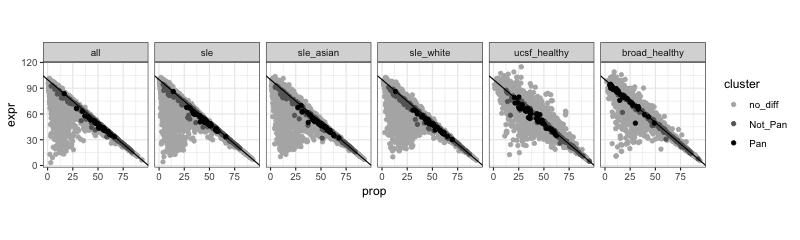

In [523]:
output_noint_df <- data.frame(prop=output_prop_noint[,"total r2"], expr=output_expr_noint[,"total r2"], type="all")
output_noint_df$cluster <- "no_diff";
output_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_noint_df <- data.frame(prop=output_sle_prop_noint[,"total r2"], expr=output_sle_expr_noint[,"total r2"], type="sle")
output_sle_noint_df$cluster <- "no_diff";
output_sle_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_noint_df))] <- as.character(cuttree_out[,"cluster"]);

# output_sle_down_noint_df <- data.frame(prop=output_sle_down_prop_noint[,"total r2"], expr=output_sle_down_expr_noint[,"total r2"], type="sle_down")
# output_sle_down_noint_df$cluster <- "no_diff";
# output_sle_down_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_down_noint_df))] <- cuttree_out[,"cluster"];

output_sle_asian_noint_df <- data.frame(prop=output_sle_asian_prop_noint[,"total r2"], expr=output_sle_asian_expr_noint[,"total r2"], type="sle_asian")
output_sle_asian_noint_df$cluster <- "no_diff";
output_sle_asian_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_asian_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_white_noint_df <- data.frame(prop=output_sle_white_prop_noint[,"total r2"], expr=output_sle_white_expr_noint[,"total r2"], type="sle_white")
output_sle_white_noint_df$cluster <- "no_diff";
output_sle_white_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_white_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_ucsf_healthy_noint_df <- data.frame(prop=output_ucsf_healthy_prop_noint[,"total r2"], expr=output_ucsf_healthy_expr_noint[,"total r2"], type="ucsf_healthy")
output_ucsf_healthy_noint_df$cluster <- "no_diff";
output_ucsf_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_ucsf_healthy_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_broad_healthy_noint_df <- data.frame(prop=output_broad_healthy_prop_noint[,"total r2"], expr=output_broad_healthy_expr_noint[,"total r2"], type="broad_healthy")
output_broad_healthy_noint_df$cluster <- "no_diff";
output_broad_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_broad_healthy_noint_df))] <- as.character(cuttree_out[,"cluster"]);

# output_ucsf_healthy_noint_matched_df <- data.frame(prop=output_ucsf_healthy_prop_noint_matched[,"total r2"], expr=output_ucsf_healthy_expr_noint_matched[,"total r2"], type="ucsf_healthy_matched")
# output_ucsf_healthy_noint_matched_df$cluster <- "no_diff";
# output_ucsf_healthy_noint_matched_df$cluster[match(cuttree_out[,"gene"],rownames(output_ucsf_healthy_noint_matched_df))] <- as.character(cuttree_out[,"cluster"]);

# output_broad_healthy_noint_matched_df <- data.frame(prop=output_broad_healthy_prop_noint_matched[,"total r2"], expr=output_broad_healthy_expr_noint_matched[,"total r2"], type="broad_healthy_matched")
# output_broad_healthy_noint_matched_df$cluster <- "no_diff";
# output_broad_healthy_noint_matched_df$cluster[match(cuttree_out[,"gene"],rownames(output_broad_healthy_noint_matched_df))] <- as.character(cuttree_out[,"cluster"]);

df <- rbind(output_noint_df, output_sle_noint_df, 
            output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_ucsf_healthy_noint_df, output_broad_healthy_noint_df)
# ,
#             output_ucsf_healthy_noint_matched_df, output_broad_healthy_noint_matched_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 10, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "Pan")] <- "Not_Pan";
df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","Not_Pan","Pan"));
df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)

# ggplot(aes(prop, expr,color=(cluster=="Pan")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Pan'),
#              aes(x = prop, y = expr, color = (cluster=="Pan")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Mye1")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Mye1'),
#              aes(x = prop, y = expr, color = (cluster=="Mye1")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Mye2")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Mye2'),
#              aes(x = prop, y = expr, color = (cluster=="Mye2")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Mono")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Mono'),
#              aes(x = prop, y = expr, color = (cluster=="Mono")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="T1")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'T1'),
#              aes(x = prop, y = expr, color = (cluster=="T1")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="T2")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'T2'),
#              aes(x = prop, y = expr, color = (cluster=="T2")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="T3")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'T3'),
#              aes(x = prop, y = expr, color = (cluster=="T3")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Lymph")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Lymph'),
#              aes(x = prop, y = expr, color = (cluster=="Lymph")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)

df2 <- data.frame(cor=c(cor(output_prop_noint[,"total r2"], output_expr_noint[,"total r2"]),
                        cor(output_sle_prop_noint[,"total r2"], output_sle_expr_noint[,"total r2"]),
                        ##cor(output_sle_down_prop_noint[,"total r2"], output_sle_down_expr_noint[,"total r2"]),
                        cor(output_sle_asian_prop_noint[,"total r2"], output_sle_asian_expr_noint[,"total r2"]),
                        cor(output_sle_white_prop_noint[,"total r2"], output_sle_white_expr_noint[,"total r2"], use='complete.obs'),
                        cor(output_ucsf_healthy_prop_noint[,"total r2"], output_ucsf_healthy_expr_noint[,"total r2"], use='complete.obs'),
                        cor(output_broad_healthy_prop_noint[,"total r2"], output_broad_healthy_expr_noint[,"total r2"], use='complete.obs')),
#                         cor(output_ucsf_healthy_prop_noint_matched[,"total r2"], output_ucsf_healthy_expr_noint_matched[,"total r2"]),
#                         cor(output_broad_healthy_prop_noint_matched[,"total r2"], output_broad_healthy_expr_noint_matched[,"total r2"])),
                  prop_mean=c(mean(output_prop_noint[,"total r2"]), mean(output_sle_prop_noint[,"total r2"]),
                              mean(output_sle_asian_prop_noint[,"total r2"]), mean(output_sle_white_prop_noint[,"total r2"], na.rm=T),
                              mean(output_ucsf_healthy_prop_noint[,"total r2"],na.rm=T), mean(output_broad_healthy_prop_noint[,"total r2"], na.rm=T)),
#                               mean(output_ucsf_healthy_prop_noint_matched[,"total r2"]), mean(output_broad_healthy_prop_noint_matched[,"total r2"])),
                  expr_mean=c(mean(output_expr_noint[,"total r2"]), mean(output_sle_expr_noint[,"total r2"]),
                              mean(output_sle_asian_expr_noint[,"total r2"]), mean(output_sle_white_expr_noint[,"total r2"],na.rm=T),
                              mean(output_ucsf_healthy_expr_noint[,"total r2"],na.rm=T), mean(output_broad_healthy_expr_noint[,"total r2"],na.rm=T)),
#                               mean(output_ucsf_healthy_expr_noint_matched[,"total r2"]), mean(output_broad_healthy_expr_noint_matched[,"total r2"])),
                  sum_mean = c(mean(output_prop_noint[,"total r2"]+output_expr_noint[,"total r2"]), 
                               mean(output_sle_prop_noint[,"total r2"]+output_sle_expr_noint[,"total r2"]), 
                               mean(output_sle_asian_prop_noint[,"total r2"]+output_sle_asian_expr_noint[,"total r2"]), 
                               mean(output_sle_white_prop_noint[,"total r2"]+output_sle_white_expr_noint[,"total r2"],na.rm=T), 
                               mean(output_ucsf_healthy_prop_noint[,"total r2"]+output_ucsf_healthy_expr_noint[,"total r2"],na.rm=T),
                               mean(output_broad_healthy_prop_noint[,"total r2"]+output_broad_healthy_expr_noint[,"total r2"],na.rm=T)))
#                                mean(output_ucsf_healthy_prop_noint_matched[,"total r2"]+output_ucsf_healthy_expr_noint_matched[,"total r2"]),
#                                mean(output_broad_healthy_prop_noint_matched[,"total r2"]+output_broad_healthy_expr_noint_matched[,"total r2"])))
rownames(df2) <- c("all", "sle", "sle_asian","sle_white", "ucsf_healthy", "broad_healthy")##, "ucsf_healthy_matched", "broad_healthy_matched")

df2

df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_expr_noint,2,mean,na.rm=T))))
#             data.frame(t(apply(output_ucsf_healthy_prop_noint_matched,2,mean,na.rm=T))),
#             data.frame(t(apply(output_ucsf_healthy_expr_noint_matched,2,mean,na.rm=T))),
#             data.frame(t(apply(output_broad_healthy_prop_noint_matched,2,mean,na.rm=T))),
#             data.frame(t(apply(output_broad_healthy_expr_noint_matched,2,mean,na.rm=T))))

rownames(df3) <- c("all_prop", "all_expr", "sle_prop", "sle_expr", 
                   "sle_asian_prop", "sle_asian_expr", "sle_white_prop", "sle_white_expr", 
                   "ucsf_healthy_prop", "ucsf_healthy_expr","broad_healthy_prop", "broad_healthy_expr")
##                  "ucsf_healthy_matched_prop", "ucsf_healthy_matched_expr","broad_healthy_matched_prop", "broad_healthy_matched_expr")

df3

Warning message:
“Removed 7 rows containing missing values (geom_point).”

cor        prop_mean expr_mean sum_mean
all           -0.9428096 21.54327  69.50263  91.04590
sle           -0.9171224 16.26663  71.43274  87.69937
sle_asian     -0.9078326 13.55708  65.80029  79.35737
sle_white     -0.9474171 16.60118  61.68444  78.28563
ucsf_healthy  -0.9543947  7.55895  28.85503  36.41398
broad_healthy -0.9706000 17.78353  38.36351  56.14704

cM        Th         B        NK        ncM      Tc       
all_prop            7.893462  1.4836139 3.158709  2.170695 2.393004  1.713838
all_expr           18.318791 18.0733040 8.854377  5.282121 4.724637 12.387028
sle_prop            6.841811  1.3418061 3.937339  2.467598 2.364447  2.325706
sle_expr           21.589581 15.7576920 8.917354  5.381736 5.486678 13.194057
sle_asian_prop      6.151948  2.7738579 4.406231  2.413248 2.851377  2.878090
sle_asian_expr     20.561638 13.4217814 9.915224  4.776884 4.841243 13.897756
sle_white_prop      8.750045  1.7367057 3.869803  5.215851 3.315087  1.777798
sle_white_expr     19.896511 16.2531721 6.592224  5.482405 5.515277 10.711182
ucsf_healthy_prop   7.612394  0.6308150 5.073758 10.143063 5.453517  3.913944
ucsf_healthy_expr   9.492645 19.4274740 6.318271  4.443335 3.202062  9.248473
broad_healthy_prop  7.699331  0.8450328 6.389031  5.348683 5.663378  3.603221
broad_healthy_expr 12.133865 16.6774008 7.441545  4.095129 3.283533  9.760401
                   cDC      pDC       total.r2 adj.r2   total.prop_expr.r2
all_prop           1.015684 5.5649006 25.39391 21.54327 96.39334          
all_expr           2.330488 1.0286878 70.99943 69.50263 96.39334          
sle_prop           1.722388 1.1935632 22.19466 16.26663 95.64986          
sle_expr           2.349020 0.7790840 73.45520 71.43274 95.64986          
sle_asian_prop     2.045318 1.7580869 25.27816 13.55708 95.71569          
sle_asian_expr     2.227331 0.7956796 70.43754 65.80029 95.71569          
sle_white_prop     2.336767 2.1876261 29.18968 16.60118 96.65761          
sle_white_expr     2.210172 0.8069806 67.46792 61.68444 96.65761          
ucsf_healthy_prop  5.144307 4.8027896 42.77459  7.55895 98.73246          
ucsf_healthy_expr  2.441248 1.3843680 55.95788 28.85503 98.73246          
broad_healthy_prop 4.044528 8.5507632 42.14397 17.78353 98.77014          
broad_healthy_expr 1.824704 1.4095958 56.62617 38.36351 98.77014          
                   adj.prop_expr.r2
all_prop           91.04590        
all_expr           91.04590        
sle_prop           87.69937        
sle_expr           87.69937        
sle_asian_prop     79.35737        
sle_asian_expr     79.35737        
sle_white_prop     78.28563        
sle_white_expr     78.28563        
ucsf_healthy_prop  36.41398        
ucsf_healthy_expr  36.41398        
broad_healthy_prop 56.14704        
broad_healthy_expr 56.14704

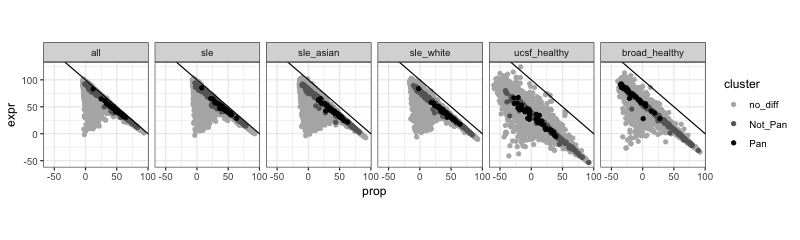

In [555]:
output_noint_df <- data.frame(prop=output_prop_noint[,"adj r2"], expr=output_expr_noint[,"adj r2"], type="all")
output_noint_df$cluster <- "no_diff";
output_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_noint_df <- data.frame(prop=output_sle_prop_noint[,"adj r2"], expr=output_sle_expr_noint[,"adj r2"], type="sle")
output_sle_noint_df$cluster <- "no_diff";
output_sle_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_noint_df))] <- as.character(cuttree_out[,"cluster"]);

# output_sle_down_noint_df <- data.frame(prop=output_sle_down_prop_noint[,"adj r2"], expr=output_sle_down_expr_noint[,"adj r2"], type="sle_down")
# output_sle_down_noint_df$cluster <- "no_diff";
# output_sle_down_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_down_noint_df))] <- cuttree_out[,"cluster"];

output_sle_asian_noint_df <- data.frame(prop=output_sle_asian_prop_noint[,"adj r2"], expr=output_sle_asian_expr_noint[,"adj r2"], type="sle_asian")
output_sle_asian_noint_df$cluster <- "no_diff";
output_sle_asian_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_asian_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_white_noint_df <- data.frame(prop=output_sle_white_prop_noint[,"adj r2"], expr=output_sle_white_expr_noint[,"adj r2"], type="sle_white")
output_sle_white_noint_df$cluster <- "no_diff";
output_sle_white_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_white_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_ucsf_healthy_noint_df <- data.frame(prop=output_ucsf_healthy_prop_noint[,"adj r2"], expr=output_ucsf_healthy_expr_noint[,"adj r2"], type="ucsf_healthy")
output_ucsf_healthy_noint_df$cluster <- "no_diff";
output_ucsf_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_ucsf_healthy_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_broad_healthy_noint_df <- data.frame(prop=output_broad_healthy_prop_noint[,"adj r2"], expr=output_broad_healthy_expr_noint[,"adj r2"], type="broad_healthy")
output_broad_healthy_noint_df$cluster <- "no_diff";
output_broad_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_broad_healthy_noint_df))] <- as.character(cuttree_out[,"cluster"]);

# output_ucsf_healthy_noint_matched_df <- data.frame(prop=output_ucsf_healthy_prop_noint_matched[,"adj r2"], expr=output_ucsf_healthy_expr_noint_matched[,"adj r2"], type="ucsf_healthy_matched")
# output_ucsf_healthy_noint_matched_df$cluster <- "no_diff";
# output_ucsf_healthy_noint_matched_df$cluster[match(cuttree_out[,"gene"],rownames(output_ucsf_healthy_noint_matched_df))] <- as.character(cuttree_out[,"cluster"]);

# output_broad_healthy_noint_matched_df <- data.frame(prop=output_broad_healthy_prop_noint_matched[,"adj r2"], expr=output_broad_healthy_expr_noint_matched[,"adj r2"], type="broad_healthy_matched")
# output_broad_healthy_noint_matched_df$cluster <- "no_diff";
# output_broad_healthy_noint_matched_df$cluster[match(cuttree_out[,"gene"],rownames(output_broad_healthy_noint_matched_df))] <- as.character(cuttree_out[,"cluster"]);

df <- rbind(output_noint_df, output_sle_noint_df, 
            output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_ucsf_healthy_noint_df, output_broad_healthy_noint_df)
# ,
#             output_ucsf_healthy_noint_matched_df, output_broad_healthy_noint_matched_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 10, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "Pan")] <- "Not_Pan";
df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","Not_Pan","Pan"));
df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)

# ggplot(aes(prop, expr,color=(cluster=="Pan")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Pan'),
#              aes(x = prop, y = expr, color = (cluster=="Pan")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Mye1")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Mye1'),
#              aes(x = prop, y = expr, color = (cluster=="Mye1")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Mye2")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Mye2'),
#              aes(x = prop, y = expr, color = (cluster=="Mye2")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Mono")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Mono'),
#              aes(x = prop, y = expr, color = (cluster=="Mono")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="T1")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'T1'),
#              aes(x = prop, y = expr, color = (cluster=="T1")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="T2")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'T2'),
#              aes(x = prop, y = expr, color = (cluster=="T2")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="T3")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'T3'),
#              aes(x = prop, y = expr, color = (cluster=="T3")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Lymph")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Lymph'),
#              aes(x = prop, y = expr, color = (cluster=="Lymph")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)

df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]),
                        cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]),
                        ##cor(output_sle_down_prop_noint[,"adj r2"], output_sle_down_expr_noint[,"adj r2"]),
                        cor(output_sle_asian_prop_noint[,"adj r2"], output_sle_asian_expr_noint[,"adj r2"]),
                        cor(output_sle_white_prop_noint[,"adj r2"], output_sle_white_expr_noint[,"adj r2"], use='complete.obs'),
                        cor(output_ucsf_healthy_prop_noint[,"adj r2"], output_ucsf_healthy_expr_noint[,"adj r2"], use='complete.obs'),
                        cor(output_broad_healthy_prop_noint[,"adj r2"], output_broad_healthy_expr_noint[,"adj r2"], use='complete.obs')),
#                         cor(output_ucsf_healthy_prop_noint_matched[,"adj r2"], output_ucsf_healthy_expr_noint_matched[,"adj r2"]),
#                         cor(output_broad_healthy_prop_noint_matched[,"adj r2"], output_broad_healthy_expr_noint_matched[,"adj r2"])),
                  prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]),
                              mean(output_sle_asian_prop_noint[,"adj r2"]), mean(output_sle_white_prop_noint[,"adj r2"], na.rm=T),
                              mean(output_ucsf_healthy_prop_noint[,"adj r2"],na.rm=T), mean(output_broad_healthy_prop_noint[,"adj r2"], na.rm=T)),
#                               mean(output_ucsf_healthy_prop_noint_matched[,"adj r2"]), mean(output_broad_healthy_prop_noint_matched[,"adj r2"])),
                  expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]),
                              mean(output_sle_asian_expr_noint[,"adj r2"]), mean(output_sle_white_expr_noint[,"adj r2"],na.rm=T),
                              mean(output_ucsf_healthy_expr_noint[,"adj r2"],na.rm=T), mean(output_broad_healthy_expr_noint[,"adj r2"],na.rm=T)),
#                               mean(output_ucsf_healthy_expr_noint_matched[,"adj r2"]), mean(output_broad_healthy_expr_noint_matched[,"adj r2"])),
                  sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), 
                               mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), 
                               mean(output_sle_asian_prop_noint[,"adj r2"]+output_sle_asian_expr_noint[,"adj r2"]), 
                               mean(output_sle_white_prop_noint[,"adj r2"]+output_sle_white_expr_noint[,"adj r2"],na.rm=T), 
                               mean(output_ucsf_healthy_prop_noint[,"adj r2"]+output_ucsf_healthy_expr_noint[,"adj r2"],na.rm=T),
                               mean(output_broad_healthy_prop_noint[,"adj r2"]+output_broad_healthy_expr_noint[,"adj r2"],na.rm=T)))
#                                mean(output_ucsf_healthy_prop_noint_matched[,"adj r2"]+output_ucsf_healthy_expr_noint_matched[,"adj r2"]),
#                                mean(output_broad_healthy_prop_noint_matched[,"adj r2"]+output_broad_healthy_expr_noint_matched[,"adj r2"])))
rownames(df2) <- c("all", "sle", "sle_asian","sle_white", "ucsf_healthy", "broad_healthy")##, "ucsf_healthy_matched", "broad_healthy_matched")

df2

df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_expr_noint,2,mean,na.rm=T))))
#             data.frame(t(apply(output_ucsf_healthy_prop_noint_matched,2,mean,na.rm=T))),
#             data.frame(t(apply(output_ucsf_healthy_expr_noint_matched,2,mean,na.rm=T))),
#             data.frame(t(apply(output_broad_healthy_prop_noint_matched,2,mean,na.rm=T))),
#             data.frame(t(apply(output_broad_healthy_expr_noint_matched,2,mean,na.rm=T))))

rownames(df3) <- c("all_prop", "all_expr", "sle_prop", "sle_expr", 
                   "sle_asian_prop", "sle_asian_expr", "sle_white_prop", "sle_white_expr", 
                   "ucsf_healthy_prop", "ucsf_healthy_expr","broad_healthy_prop", "broad_healthy_expr")
##                  "ucsf_healthy_matched_prop", "ucsf_healthy_matched_expr","broad_healthy_matched_prop", "broad_healthy_matched_expr")

df3

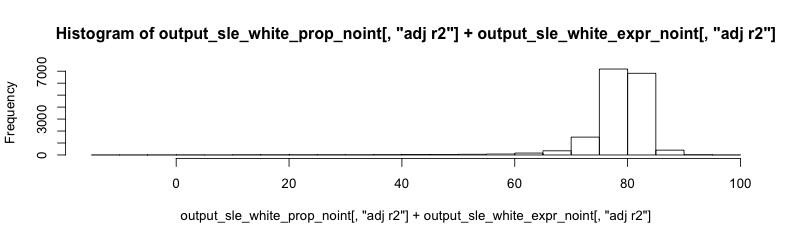

In [524]:
hist(output_sle_white_prop_noint[,"adj r2"]+output_sle_white_expr_noint[,"adj r2"])

In [525]:
df <- rbind(output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_broad_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 3, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster2 <- as.character(df_all_ifn$cluster);


In [526]:
df <- rbind(output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_broad_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 3, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);

df_all_ifn$cluster2 <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster2[which(df_all_ifn$cluster2 != "no_diff" & df_all_ifn$cluster == "Pan")] <- "pan";
df_all_ifn$cluster2[which(df_all_ifn$cluster2 != "no_diff" & df_all_ifn$cluster != "Pan")] <- "no_pan";
df_all_ifn$cluster2 <- factor(df_all_ifn$cluster2, levels=c("no_diff","no_pan","pan"));

##df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff")] <- "diff";
##df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","diff"));

df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]

##ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)

sle_asian_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))
ggsave("sle_asian_diff_no_diff_histogram.png", sle_asian_p, dpi=300, height=3, width=3)

sle_asian_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave("sle_asian_cluster_histogram.png", sle_asian_p, dpi=300, height=3, width=3)

sle_white_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))##+scale_color_manual(values=c("gray70", "black"))+scale_fill_manual(values=c("gray70", "black"))
ggsave("sle_white_diff_no_diff_histogram.png", sle_white_p, dpi=300, height=3, width=3)

sle_white_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave("sle_white_cluster_histogram.png", sle_white_p, dpi=300, height=3, width=3)

broad_white_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))##+scale_color_manual(values=c("gray70", "black"))+scale_fill_manual(values=c("gray70", "black"))
ggsave("broad_white_diff_no_diff_histogram.png", broad_white_p, dpi=300, height=3, width=3)


broad_white_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave("broad_white_cluster_histogram.png", broad_white_p, dpi=300, height=3, width=3)

# sle_asian_p = ggplot(aes(prop, expr, color=cluster), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_point()+
#                 theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+xlim(-10,100)+ylim(-10,100)+theme(aspect.ratio=1, legend.position="none")
# ggsave("sle_asian_plot.png", ggMarginal(sle_asian_p, type="histogram"),dpi = 300, height=3, width=3)

# sle_white_p = ggplot(aes(prop, expr, color=cluster), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_point()+
#                 theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+xlim(-10,100)+ylim(-10,100)+theme(aspect.ratio=1, legend.position="none")
# ggsave("sle_white_plot.png", ggMarginal(sle_white_p, type="histogram"),dpi = 300, height=3, width=3)

# broad_white_p = ggplot(aes(prop, expr, color=cluster), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_point()+
#                 theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+xlim(-10,100)+ylim(-10,100)+theme(aspect.ratio=1, legend.position="none")
# ggsave("broad_white_plot.png", ggMarginal(broad_white_p, type="histogram"), dpi = 300, height=3, width=3)


Warning message:
“Removed 6 rows containing non-finite values (stat_density).”Warning message:
“Removed 6 rows containing non-finite values (stat_density).”

In [527]:
# mean(df_all_ifn$prop[intersect(grep("healthy",df_all_ifn$type), which(df_all_ifn$cluster=="1"))])

In [528]:
# colMeans(output_prop_noint[match(pbmc_deseq_sig_genes,rownames(output_prop_noint)),],na.rm=T)


In [529]:
# output_prop_noint[match("IFI6",rownames(output_prop_noint)),]
# output_expr_noint[match("IFI6",rownames(output_expr_noint)),]

In [530]:
rst_sle <- NULL;
rst_ctrl <- NULL;
rst_sle_asian <- NULL;
rst_sle_white <- NULL;
rst <- NULL;

for ( i in unique(df_all_ifn[,"cluster"])) {
    print(i);
    
        rst <- rbind(rst,
                     c(colMeans(output_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_prop_noint)),],na.rm=T),cluster=i))

    rst_sle <- rbind(rst_sle,
                     c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_prop_noint)),],na.rm=T),cluster=i))
    
     rst_sle_asian <- rbind(rst_sle_asian,
                     c(colMeans(output_sle_asian_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_asian_prop_noint)),],na.rm=T),cluster=i))
    
       rst_sle_white <- rbind(rst_sle_white,
                     c(colMeans(output_sle_white_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_white_prop_noint)),],na.rm=T),cluster=i))
    
    rst_ctrl <- rbind(rst_ctrl,
                      c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_broad_healthy_prop_noint)),],na.rm=T),cluster=i))
}

rst <- rbind(rst, 
                 c(colMeans(output_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_prop_noint)),],na.rm=T),cluster="diff"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_prop_noint)),],na.rm=T),cluster="diff"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_asian_prop_noint)),],na.rm=T),cluster="diff"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_white_prop_noint)),],na.rm=T),cluster="diff"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                            rownames(output_broad_healthy_prop_noint)),],na.rm=T),cluster="diff"))

rst <- rbind(rst, 
                 c(colMeans(output_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_asian_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_white_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                            rownames(output_broad_healthy_prop_noint)),],na.rm=T),cluster="cell_type"))

rst <- rbind(rst, 
                 c(colMeans(output_prop_noint),cluster="all"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_prop_noint),cluster="all"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_prop_noint),cluster="all"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_prop_noint),cluster="all"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_prop_noint),cluster="all"))

# rst_sle <- rbind(rst_sle,
#                  c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="no_diff")],
#                                                                  rownames(output_sle_prop_noint)),],na.rm=T), cluster="no_diff"))
                 
# rst_ctrl <- rbind(rst_ctrl,
#                   c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="no_diff")],
#                                                                                   rownames(output_broad_healthy_prop_noint)),],na.rm=T), cluster="no_diff"))
rst
rst_sle
rst_ctrl

[1] "B"
[1] "Lymph"
[1] "Mono"
[1] "ncM"
[1] "no_diff"
[1] "Pan"
[1] "pDC"
[1] "T4"
[1] "T8"


cM                Th                B                  
 [1,] 3.93097752917949  2.00345125160049  17.33987195543     
 [2,] 2.25219984581124  -1.21597441614528 2.51454414802966   
 [3,] 42.3078135431558  1.44041955030874  -0.518455358917244 
 [4,] 12.5827075958866  3.09993713592614  -0.0275405520082947
 [5,] 7.65952740694544  1.44160275821053  3.1843272685203    
 [6,] 31.3626888791924  2.0504573247873   1.9170680728259    
 [7,] 0.111663684560373 1.37821345281029  0.0221899507904467 
 [8,] 2.7587457295134   42.0953726906811  0.378362520706166  
 [9,] 1.78886183253064  6.27559977034035  1.05251135167722   
[10,] 27.4376550281667  4.99345081131753  1.0183858014497    
[11,] 26.4749108760284  5.71531713820231  0.79795430092346   
[12,] 7.89346224977709  1.48361386421502  3.15870860600656   
      NK                  ncM               Tc                 
 [1,] -0.0142314197883771 3.71773837016266  -0.317133142880049 
 [2,] 2.60063649831728    0.443517306468874 4.6635379398303    
 [3,] 0.203290066301478   3.07344983461477  0.00312250976447671
 [4,] 0.67519233230829    6.58324110170358  1.30998804618783   
 [5,] 2.17960014368992    2.39487532251549  1.70264353863564   
 [6,] 0.621129618172407   1.72442407556164  0.308944133208906  
 [7,] 0.551568424001337   0.183437546008843 -0.926857393876965 
 [8,] 0.471213264057963   1.29740266579421  -0.0230463304769884
 [9,] 11.6748075597451    0.320927268103188 27.9139093495679   
[10,] 1.42667148018849    2.23668019345837  2.64905403293487   
[11,] 1.62425721992828    2.36232792048964  3.22304325362237   
[12,] 2.17069453584205    2.39300419733309  1.71383764125638   
      cDC               pDC              total r2         adj r2          
 [1,] 2.63726087633941  4.78147742147329 34.0794128415169 30.6770599559178
 [2,] 2.58239025079086  7.53837839991888 21.3792299730218 17.321383778081 
 [3,] 1.43204961183589  2.8396661545355  50.7813559115995 48.2410387973594
 [4,] 2.52082299697172  3.21585998909628 29.9602086460722 26.3452516729662
 [5,] 0.988675968736123 5.57475455409862 25.126006961352  21.2615428045186
 [6,] 9.83787476807287  3.0459000274385  50.8684868992599 48.332666868254 
 [7,] 3.04469514899607  67.1953113958355 71.5602222091259 70.0923627102421
 [8,] 0.559904250601969 7.0680381916966  54.6059929825744 52.2630764913525
 [9,] 2.16738530187195  2.88617315458561 54.0801755884219 51.7101201349211
[10,] 3.27212032487723  4.74164343842431 47.7756611108172 45.0802113616981
[11,] 1.66165225390471  5.1575805014963  47.0170434645954 44.2824392563165
[12,] 1.0156844503679   5.56490055165516 25.3939060964533 21.5432689917541
      total prop_expr r2 adj prop_expr r2 cluster  
 [1,] 99.2575812729174   94.0579725644228 B        
 [2,] 95.4231174713961   90.0256009537907 Lymph    
 [3,] 99.1125873780916   93.9054951137351 Mono     
 [4,] 98.9181634765388   93.7010364301666 ncM      
 [5,] 96.3718250312031   91.0232740650716 no_diff  
 [6,] 97.6881955657829   92.407586304662  Pan      
 [7,] 100.017099607594   94.8566918454058 pDC      
 [8,] 97.5097884870427   92.219971118632  T4       
 [9,] 97.0906648314861   91.7792152744016 T8       
[10,] 98.1908273032504   92.9361603253536 diff     
[11,] 98.3141143331952   93.065810556844  cell_type
[12,] 96.3933401118402   91.0458996014836 all

cM                Th                B                   
 [1,] 1.65592125173654  1.33058538927628  22.4855087382312    
 [2,] -1.36250644091401 4.20411295208438  3.04054541983712    
 [3,] 37.6864587359734  2.0239863197189   -0.722144968527986  
 [4,] 10.2670931721706  3.72551484794644  -0.00254024914761488
 [5,] 6.64416046730715  1.29513709813225  3.96720486378748    
 [6,] 25.4005658804306  2.67026209293161  2.82947167685768    
 [7,] 0.931460994299612 0.167975758647815 0.083473935740716   
 [8,] 0.56926192166021  35.4672525141094  1.79396273499909    
 [9,] 1.18121606189789  4.42064445635648  1.27624457635775    
[10,] 23.3545971479445  5.24078983390809  1.44220665368386    
[11,] 22.852755760731   5.87129663829854  1.1019341008299     
[12,] 6.84181079363727  1.34180610898551  3.93733929356045    
      NK                  ncM                 Tc                
 [1,] -0.0540167927825624 2.53223770987752    -1.02431098167019 
 [2,] 2.47402545381793    1.40071094909807    5.13808334321133  
 [3,] 0.325053432594086   2.89966193193945    -0.374949155541259
 [4,] 1.87590924928022    5.36383346122795    1.52582504380957  
 [5,] 2.47877929414621    2.36923154158022    2.32091690739788  
 [6,] 0.553918564587613   0.90944186787974    -0.194431871618964
 [7,] 0.752126087888425   0.680723603524516   -2.12317367257381 
 [8,] 0.997890131378477   0.740367981201201   0.120229382831224 
 [9,] 11.7503420648865    -0.0317466131142109 32.30889568614    
[10,] 1.53343786248059    1.9647017918221     2.7257761251493   
[11,] 1.77369731290717    2.22353913165702    3.44205355831888  
[12,] 2.46759783635231    2.36444678109921    2.32570556481214  
      cDC              pDC               total r2         adj r2          
 [1,] 3.48917560892374 0.46113440618656  30.876235329779  25.6096627834765
 [2,] 3.29221829783145 0.886219400484464 19.0734093754507 12.9075738992946
 [3,] 1.73245891851622 0.44443653156717  44.01496174624   39.749435022144 
 [4,] 2.81861890219851 0.658426229680188 26.2326806571658 20.6123134691404
 [5,] 1.69112960088313 1.19178868120265  21.958348454437  16.0123178604893
 [6,] 13.3464659242974 0.050464892782777 45.5661590281485 41.4188187636265
 [7,] 5.80372100729988 60.8136577541333  67.1099654689604 64.6040580761193
 [8,] 1.2433136861589  0.355337717185356 41.2876160695239 36.8142915795829
 [9,] 2.51003302396042 0.68255926763855  54.0981885241233 50.6009076497708
[10,] 4.33386030750229 1.34181447694385  41.9371841994346 37.5133506146296
[11,] 2.12322119394877 1.65856060136072  41.047058298052  36.5554055969512
[12,] 1.72238770601518 1.19356317986195  22.194657264324  16.2666311511297
      total prop_expr r2 adj prop_expr r2 cluster  
 [1,] 99.0010716802231   91.3059152368115 B        
 [2,] 94.9152248879944   86.9087658318416 Lymph    
 [3,] 98.8941886218883   91.1908887073655 Mono     
 [4,] 98.5699106997051   90.8419038958731 ncM      
 [5,] 95.6237691909289   87.6712944626187 no_diff  
 [6,] 97.3938058491962   89.576191056754  Pan      
 [7,] 99.766664967076    92.1298394407579 pDC      
 [8,] 96.0365573685436   88.1155331680517 T4       
 [9,] 96.9633905228947   89.1129821817819 T8       
[10,] 97.8294580226234   90.045035776728  diff     
[11,] 97.936316102898    90.1600354250236 cell_type
[12,] 95.6498579835618   87.6993709727856 all

cM                Th                 B                NK               
 [1,] 4.98417180594186  3.15514819195425   14.6301794408499 2.18213313343304 
 [2,] 0.141208176909566 5.46337234873561   9.89951288712654 9.71985183501678 
 [3,] 28.9982980797343  -0.261256973792416 2.51360813820742 2.79362802660516 
 [4,] 4.33895176382531  0.149791924070655  3.20218456454147 0.856271060017317
 [5,] 7.61821158922785  0.807945426513361  6.42498446639573 5.35676517553443 
 [6,] 1.34964006652697  2.32876096601969   1.84653560743056 1.30423905235797 
 [7,] 1.16483909526234  -1.05333454740383  1.70606584241688 0.177294629587267
 [8,] -2.01886051412099 34.0052668713147   1.56681406504321 2.82502863257338 
 [9,] 2.47405459824306  2.99133602094474   2.06208712324289 23.4993815265564 
[10,] 14.474054796121   3.94239432121315   3.38639527213069 4.67372712231685 
[11,] 17.6932508618704  4.33819118192098   3.76409669932129 5.50020532815582 
[12,] NaN               NaN                NaN              NaN              
      ncM                 Tc                cDC                pDC             
 [1,] 6.3906503803049     0.655462735588895 6.26804386991455   2.17593445176672
 [2,] 4.0913415213897     4.46968021884419  5.93581414045518   9.98536133072413
 [3,] 4.58766467507194    2.91785449434429  4.76652670808242   8.69381291093064
 [4,] 20.211297929911     2.12486894399101  4.58432095973837   5.12268550762454
 [5,] 5.68088102432429    3.59756571939938  4.0481924729137    8.56251721847174
 [6,] 3.38016912366356    4.78107922435448  1.01058787864013   2.23890210256542
 [7,] -0.0709366212162909 2.57707829402127  -0.326459365687097 66.2864855190389
 [8,] 3.02001776795443    2.33250995883511  2.75777855638373   4.63947150237132
 [9,] 1.00897506426217    13.0947330041522  2.01202173779826   5.27419017870365
[10,] 4.20157962005826    4.07553794224557  3.73848585492117   7.56912544025079
[11,] 4.40305766634375    3.90248064663395  4.40759290570708   8.87653871175852
[12,] NaN                 NaN               NaN                NaN             
      total r2         adj r2            total prop_expr r2 adj prop_expr r2
 [1,] 40.4417240097541 15.3645551717558  99.2048330407784   56.7647627421587
 [2,] 49.7061424592017 28.5297813893919  98.3957258290982   55.6149788097711
 [3,] 55.0101360591838 36.0670354525243  99.7219001298609   57.4995422898024
 [4,] 40.5903726537197 15.5757927184438  98.9809209008964   56.446571806537 
 [5,] 42.0970630927805 17.716879131846   98.7678643501536   56.1438072344287
 [6,] 18.2399140215588 -16.1853853377849 98.0480946767305   55.1209766458801
 [7,] 70.4610328460195 58.0235729917119  100.085020421215   58.0155553354103
 [8,] 49.1280268403548 27.7082486678727  96.96609402554     53.5833967731358
 [9,] 52.4167792539034 32.3817389397574  99.0615685297588   56.5611763317626
[10,] 46.0613003692575 23.3502689457869  98.9604014988796   56.4174126563026
[11,] 52.8854140017118 33.04769358138    99.1841748703501   56.7354063947081
[12,] NaN              NaN               NaN                NaN             
      cluster  
 [1,] B        
 [2,] Lymph    
 [3,] Mono     
 [4,] ncM      
 [5,] no_diff  
 [6,] Pan      
 [7,] pDC      
 [8,] T4       
 [9,] T8       
[10,] diff     
[11,] cell_type
[12,] all

In [531]:
rst_sle <- NULL;
rst_ctrl <- NULL;
rst_sle_asian <- NULL;
rst_sle_white <- NULL;
rst <- NULL;

for ( i in unique(df_all_ifn[,"cluster"])) {
    print(i);
    
        rst <- rbind(rst,
                     c(colMeans(output_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_expr_noint)),],na.rm=T),cluster=i))

    rst_sle <- rbind(rst_sle,
                     c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_expr_noint)),],na.rm=T),cluster=i))
    
     rst_sle_asian <- rbind(rst_sle_asian,
                     c(colMeans(output_sle_asian_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_asian_expr_noint)),],na.rm=T),cluster=i))
    
       rst_sle_white <- rbind(rst_sle_white,
                     c(colMeans(output_sle_white_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_white_expr_noint)),],na.rm=T),cluster=i))
    
    rst_ctrl <- rbind(rst_ctrl,
                      c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_broad_healthy_expr_noint)),],na.rm=T),cluster=i))
}

rst <- rbind(rst, 
                 c(colMeans(output_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_expr_noint)),],na.rm=T),cluster="diff"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_expr_noint)),],na.rm=T),cluster="diff"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_asian_expr_noint)),],na.rm=T),cluster="diff"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_white_expr_noint)),],na.rm=T),cluster="diff"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                            rownames(output_broad_healthy_expr_noint)),],na.rm=T),cluster="diff"))

rst <- rbind(rst, 
                 c(colMeans(output_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_asian_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_white_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                            rownames(output_broad_healthy_expr_noint)),],na.rm=T),cluster="cell_type"))

rst <- rbind(rst, 
                 c(colMeans(output_expr_noint),cluster="all"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_expr_noint),cluster="all"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_expr_noint),cluster="all"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_expr_noint),cluster="all"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_expr_noint),cluster="all"))

# rst_sle <- rbind(rst_sle,
#                  c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="no_diff")],
#                                                                  rownames(output_sle_expr_noint)),],na.rm=T), cluster="no_diff"))
                 
# rst_ctrl <- rbind(rst_ctrl,
#                   c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="no_diff")],
#                                                                                   rownames(output_broad_healthy_expr_noint)),],na.rm=T), cluster="no_diff"))
rst
rst_sle
rst_ctrl

[1] "B"
[1] "Lymph"
[1] "Mono"
[1] "ncM"
[1] "no_diff"
[1] "Pan"
[1] "pDC"
[1] "T4"
[1] "T8"


cM                Th                B                  NK                
 [1,] 26.4148236676133  0.764878850038926 20.8818417170849   0.541777751044607 
 [2,] 10.4905097065631  26.2652972258399  7.78265298281528   7.38352142878992  
 [3,] 35.5457719684453  1.58925735101868  1.39697697148179   1.07617271640215  
 [4,] 0.442305381903796 12.0680544950702  0.0534157446611634 0.134504504890005 
 [5,] 18.2489740911015  18.203020770834   8.92581067210247   5.31459628624804  
 [6,] 24.7326169461587  5.17173329135939  3.02001792275207   1.86128879503335  
 [7,] 0.794931872062769 0.525990738465267 2.99808916168354   0.0495554119667939
 [8,] 1.18148049095851  28.5651750455702  1.47618328389089   1.63327506059945  
 [9,] 3.28406316700626  2.8849273291087   0.483532983954238  10.405447001525   
[10,] 24.1517080128468  7.23605638983966  2.88645191415242   2.56893210300251  
[11,] 24.0092209159967  7.74239979135368  2.85369044034496   2.74250498986287  
[12,] 18.3187913740469  18.073303987833   8.8543773964708    5.28212068838169  
      ncM               Tc                cDC               pDC               
 [1,] 5.47744861667295  1.51755795476476  8.81133692955979  0.768502944621304 
 [2,] 2.16594776887079  17.7721423682397  1.64597847113539  0.53783754612011  
 [3,] 4.9652963552622   1.87570511521083  1.68731118787285  0.194739800798344 
 [4,] 47.0537778806296  9.09712320239313  0.130790434482699 -0.022016813563858
 [5,] 4.72176121026479  12.458154030836   2.33841646674014  1.03508454172413  
 [6,] 5.92730358682987  4.53692561165729  1.23736814478556  0.33245436794672  
 [7,] 0.123670647037972 0.855405432341092 8.16151549401063  14.9477186409005  
 [8,] 0.332538832910001 9.42930822020991  0.197502534286455 0.0883320360428964
 [9,] 0.672282720467293 24.4371352219249  0.518869621580134 0.324231197497597 
[10,] 4.9648617490451   6.44475226692866  1.66813285144885  0.494270905169147 
[11,] 4.72879110958845  6.91270974841032  1.77379211912097  0.533961753921818 
[12,] 4.72463659298154  12.3870277734134  2.33048838096788  1.02868782129176  
      total r2         adj r2           total prop_expr r2 adj prop_expr r2
 [1,] 65.1781684314005 63.3809126085051 99.2575812729174   94.0579725644228
 [2,] 74.0438874983742 72.7042171757097 95.4231174713961   90.0256009537907
 [3,] 48.3312314664922 45.6644563163756 99.1125873780916   93.9054951137351
 [4,] 68.9579548304666 67.3557847572004 98.9181634765388   93.7010364301666
 [5,] 71.2458180698511 69.761731260553  96.3718250312031   91.0232740650716
 [6,] 46.819708666523  44.074919436408  97.6881955657829   92.407586304662 
 [7,] 28.4568773984686 24.7643291351637 100.017099607594   94.8566918454058
 [8,] 42.9037955044683 39.9568946272795 97.5097884870427   92.219971118632 
 [9,] 43.0104892430642 40.0690951394804 97.0906648314861   91.7792152744016
[10,] 50.4151661924332 47.8559489636555 98.1908273032504   92.9361603253536
[11,] 51.2970708685998 48.7833713005276 98.3141143331952   93.065810556844 
[12,] 70.999434015387  69.5026306097295 96.3933401118402   91.0458996014836
      cluster  
 [1,] B        
 [2,] Lymph    
 [3,] Mono     
 [4,] ncM      
 [5,] no_diff  
 [6,] Pan      
 [7,] pDC      
 [8,] T4       
 [9,] T8       
[10,] diff     
[11,] cell_type
[12,] all

cM               Th               B                  NK                
 [1,] 25.8018430672909 1.3264220336264  23.2465839644502   1.55880247232412  
 [2,] 11.9212374344131 25.6164856128637 8.24354385088663   7.27037491328571  
 [3,] 40.6880272602195 1.66396563246486 1.58700085639892   1.14081237623831  
 [4,] 0.583652329981   9.23765424144589 0.0388547559930418 0.163956777238661 
 [5,] 21.5210522027654 15.8544800197559 8.98544725619629   5.41440269253211  
 [6,] 27.1762919818576 5.71464288290144 3.31361412027904   2.11350717710289  
 [7,] 2.7047167214678  1.28202470234587 3.4420428140492    0.0490858439547911
 [8,] 1.77804782883308 33.707067526315  2.30071351508222   2.37863328718043  
 [9,] 3.397385665296   2.5073707347343  0.506265911936385  9.38574496908137  
[10,] 27.314808554699  7.67149689136983 3.22845133959442   2.65258414404665  
[11,] 27.3487843178488 8.15147995005076 3.20756235565291   2.78481056990078  
[12,] 21.5895805037023 15.7576920472696 8.91735375610745   5.38173602152852  
      ncM               Tc               cDC               pDC                
 [1,] 5.90677518384249  1.98067764388944 7.7094389272646   0.594293057755886  
 [2,] 2.57515572120177  18.2039583975749 1.77779883418497  0.233260748132921  
 [3,] 5.72533878412569  2.13670978705853 1.78665818448548  0.150713994657062  
 [4,] 53.3882839375422  8.75945282703772 0.161345250387833 0.00402992291293672
 [5,] 5.48439759362405  13.2658256546432 2.35599355268126  0.783821764293622  
 [6,] 6.69903608810212  5.08836871877833 1.4799742832559   0.242211568770315  
 [7,] 0.247952308763711 2.69106384589554 8.13722341385859  14.10258984778     
 [8,] 0.435408203978027 13.7095608613388 0.413872526388976 0.0256375499031286 
 [9,] 0.713447135250691 25.6906479033528 0.587146098716641 0.0771935804031758 
[10,] 5.67716458799941  7.19808453937019 1.76641584831559  0.383267917793668  
[11,] 5.42651686155912  7.71556200479839 1.83667510012269  0.417866644912604  
[12,] 5.48667763334247  13.1940566737099 2.34902005295221  0.779084030625343  
      total r2         adj r2           total prop_expr r2 adj prop_expr r2
 [1,] 68.124836350444  65.696252453335  99.0010716802231   91.3059152368115
 [2,] 75.8418155125437 74.001191932547  94.9152248879944   86.9087658318416
 [3,] 54.8792268756483 51.4414536852216 98.8941886218883   91.1908887073655
 [4,] 72.3372300425393 70.2295904267328 98.5699106997051   90.8419038958731
 [5,] 73.6654207364919 71.6589766021294 95.6237691909289   87.6712944626187
 [6,] 51.8276468210477 48.1573722931275 97.3938058491962   89.576191056754 
 [7,] 32.6566994981155 27.5257813646386 99.766664967076    92.1298394407579
 [8,] 54.7489412990197 51.3012415884688 96.0365573685436   88.1155331680517
 [9,] 42.8652019987713 38.5120745320111 96.9633905228947   89.1129821817819
[10,] 55.8922738231888 52.5316851620984 97.8294580226234   90.045035776728 
[11,] 56.889257804846  53.6046298280724 97.936316102898    90.1600354250236
[12,] 73.4552007192378 71.4327398216559 95.6498579835618   87.6993709727856
      cluster  
 [1,] B        
 [2,] Lymph    
 [3,] Mono     
 [4,] ncM      
 [5,] no_diff  
 [6,] Pan      
 [7,] pDC      
 [8,] T4       
 [9,] T8       
[10,] diff     
[11,] cell_type
[12,] all

cM                 Th                B                 NK                
 [1,] 22.6475098208875   0.573045567486275 18.6644960758299  0.315085701495741 
 [2,] 6.05493450464487   16.910220522754   5.3525127456946   4.30844857302128  
 [3,] 31.7194109998119   1.57389077057009  0.893581889080999 0.945428615720747 
 [4,] 0.464132688902478  10.6805068936916  0.50602570173433  0.0273487406877433
 [5,] 11.9903301528333   16.7781670407628  7.49727105172047  4.11345935683286  
 [6,] 36.2733926879197   12.8514861281526  5.20588806712467  3.28361023311952  
 [7,] 0.0110676474731917 1.12705167177314  3.30791474002526  0.18284524673229  
 [8,] 1.37710087887652   33.4982590038318  1.23657176329905  1.82865017395563  
 [9,] 4.47232444682058   4.09396157096708  0.883120603804466 11.4585975397276  
[10,] 24.1212036529878   8.26189402160611  2.78756035225401  2.56429949412467  
[11,] 21.140478040646    7.13614501433999  2.19438562973856  2.3878647845599   
[12,] NaN                NaN               NaN               NaN               
      ncM               Tc                cDC                pDC               
 [1,] 5.96302160238533  0.776745340171922 8.7086488425173    1.11455608025035  
 [2,] 1.71632985783085  12.4121663864269  1.35540896914776   0.57956181037625  
 [3,] 5.50287526035221  1.5230836045584   2.35290220788535   0.200590722697494 
 [4,] 37.2670252793817  8.40215192742879  0.76207824065704   0.281278774693028 
 [5,] 3.25065647462538  9.80491348003845  1.81959213015135   1.4164115704085   
 [6,] 11.0735001655203  6.60563309135236  3.02965155282999   1.48501872915251  
 [7,] 0.26575707335576  0.159102300310242 4.68319961905408   19.8870492764712  
 [8,] 0.343704064143798 9.5601734972462   0.0435167475237583 -0.049908943691635
 [9,] 0.911240620414077 23.616201733915   0.465565617660577  0.743777142546076 
[10,] 6.02917994762519  6.0429704512155   2.25161543834654   0.840377771462362 
[11,] 4.79189385644337  5.90495886023853  2.06077639139778   0.682258291274212 
[12,] NaN               NaN               NaN                NaN               
      total r2         adj r2               total prop_expr r2 adj prop_expr r2
 [1,] 58.7631090310243 41.4002075704029     99.2048330407784   56.7647627421587
 [2,] 48.6895833698965 27.0851974203793     98.3957258290982   55.6149788097711
 [3,] 44.7117640706771 21.432506837278      99.7219001298609   57.4995422898024
 [4,] 58.3905482471767 40.8707790880932     98.9809209008964   56.446571806537 
 [5,] 56.6708012573731 38.4269281025828     98.7678643501536   56.1438072344287
 [6,] 79.8081806551717 71.306361983665      98.0480946767305   55.1209766458801
 [7,] 29.6239875751952 -0.00801765630162521 100.085020421215   58.0155553354103
 [8,] 47.8380671851852 25.8751481052631     96.96609402554     53.5833967731358
 [9,] 46.6447892758555 24.1794373920052     99.0615685297588   56.5611763317626
[10,] 52.8991011296222 33.0671437105157     98.9604014988796   56.4174126563026
[11,] 46.2987608686383 23.6877128133281     99.1841748703501   56.7354063947081
[12,] NaN              NaN                  NaN                NaN             
      cluster  
 [1,] B        
 [2,] Lymph    
 [3,] Mono     
 [4,] ncM      
 [5,] no_diff  
 [6,] Pan      
 [7,] pDC      
 [8,] T4       
 [9,] T8       
[10,] diff     
[11,] cell_type
[12,] all

In [532]:
# cor(colMeans(cm_expr_std), props[,"cM"])
# cor(colMeans(th_expr_std), props[,"Th"])
# cor(colMeans(tc_expr_std), props[,"Tc"])
# cor(colMeans(nk_expr_std), props[,"NK"])
# cor(colMeans(ncm_expr_std), props[,"ncM"])
# cor(colMeans(pdc_expr_std), props[,"pDC"])
# cor(colMeans(cdc_expr_std), props[,"cDC"])
# cor(colMeans(b_expr_std), props[,"B"])

## Plot stacked barcharts

Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing missing values (geom_bar).”

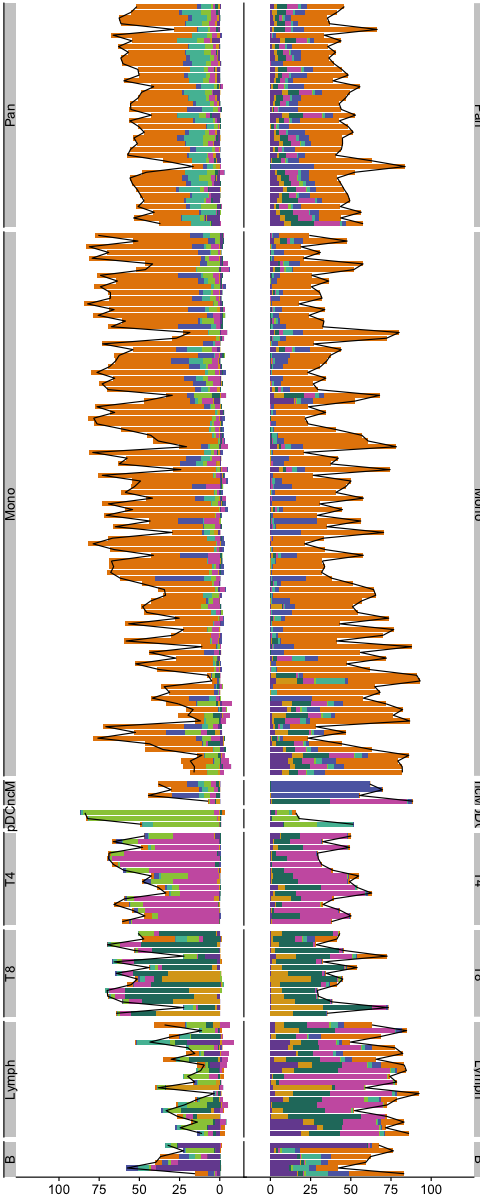

Warning message:
“Removed 1 rows containing missing values (position_stack).”

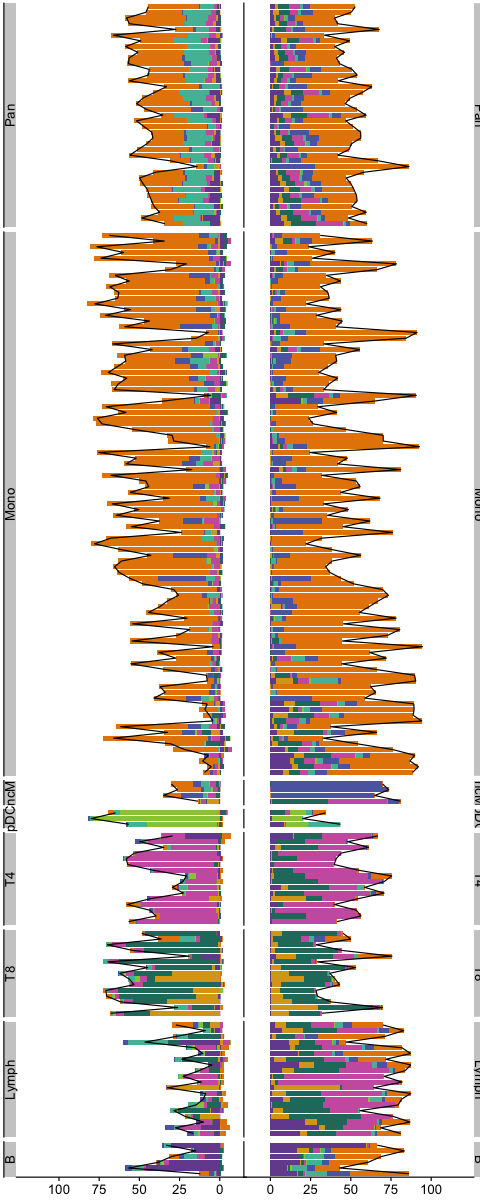

Saving 3 x 7 in image


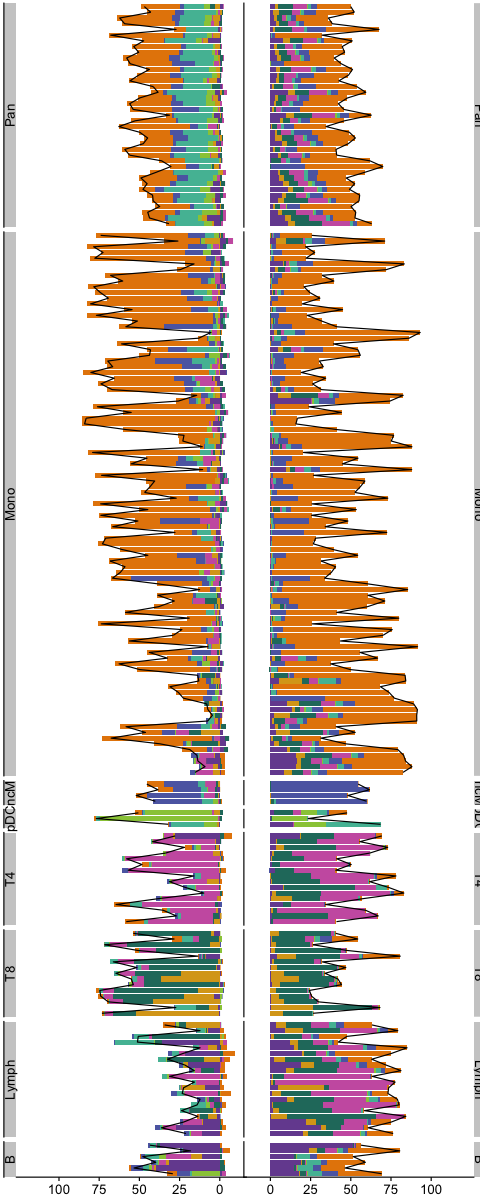

Saving 3 x 7 in image
Warning message:
“Removed 12 rows containing missing values (position_stack).”Warning message:
“Removed 21 rows containing missing values (geom_bar).”

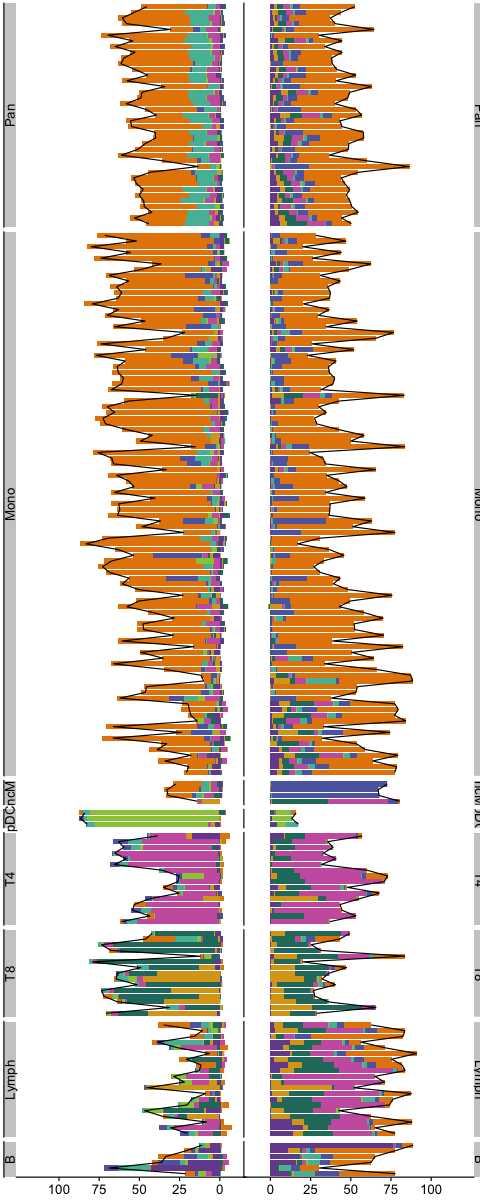

Warning message:
“Removed 1 rows containing missing values (position_stack).”Warning message:
“Removed 1 rows containing missing values (geom_bar).”

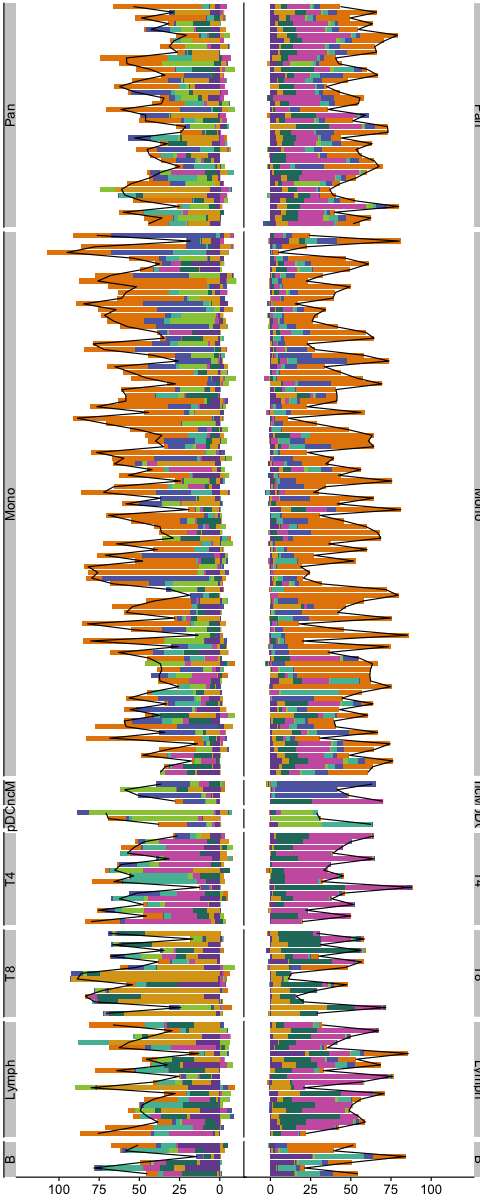

Saving 3 x 7 in image


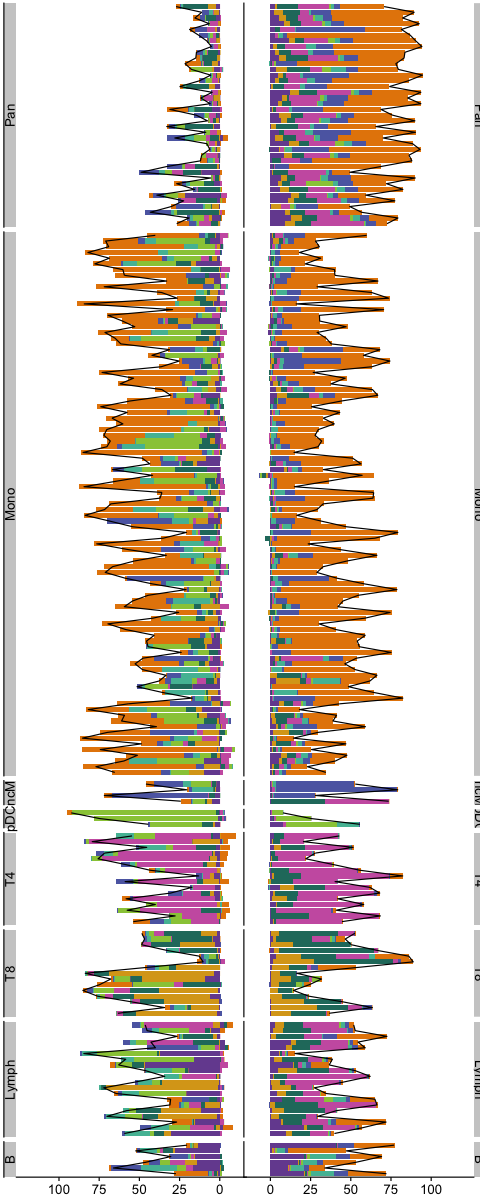

In [533]:
source("helper_functions.R")

a <- plot_bar_chart(output_prop_noint, output_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
b <- plot_bar_chart(output_sle_prop_noint, output_sle_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
c <- plot_bar_chart(output_sle_asian_prop_noint, output_sle_asian_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(c, file="sle_asian_partitioned.png",width=3)
d <- plot_bar_chart(output_sle_white_prop_noint, output_sle_white_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(d, file="sle_white_partitioned.png",width=3);
e <- plot_bar_chart(output_ucsf_healthy_prop_noint, output_ucsf_healthy_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
f <- plot_bar_chart(output_broad_healthy_prop_noint, output_broad_healthy_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(f, file="broad_white_partitioned.png",width=3);


Warning message:
“Removed 1 rows containing missing values (position_stack).”Saving 3 x 7 in image


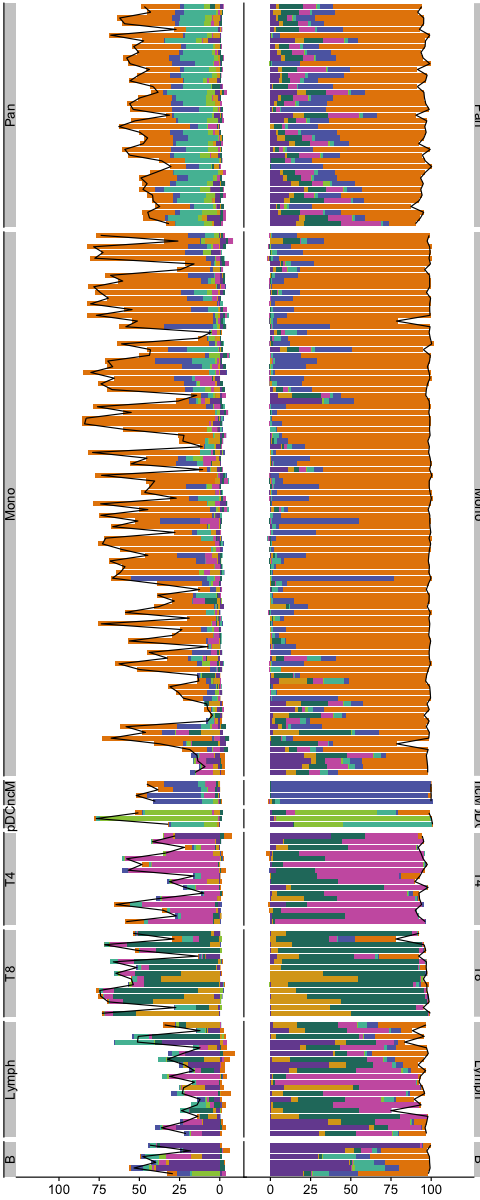

Saving 3 x 7 in image
Warning message:
“Removed 1 rows containing missing values (position_stack).”Warning message:
“Removed 1 rows containing missing values (geom_bar).”Warning message:
“Removed 3 rows containing missing values (geom_bar).”

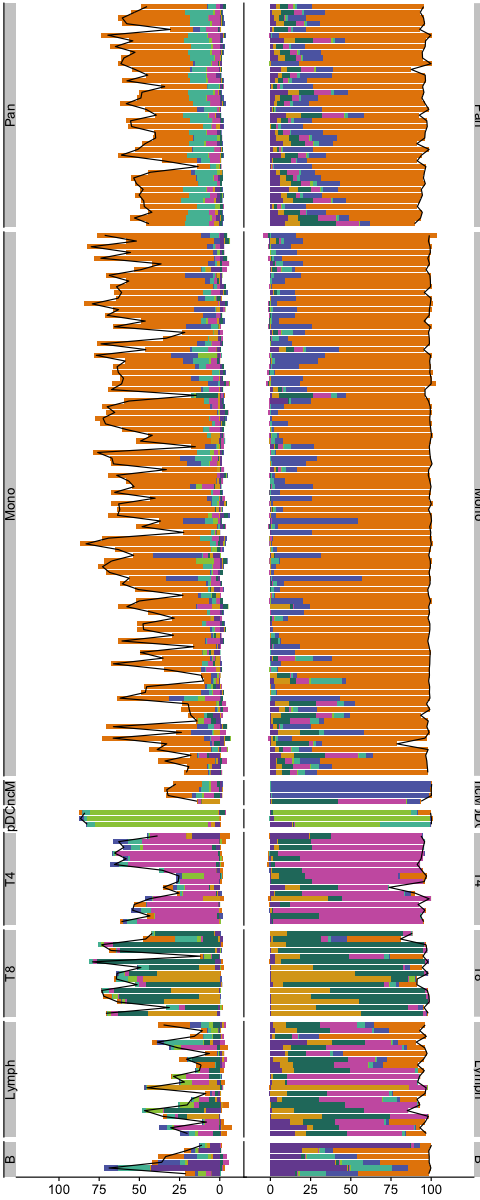

Saving 3 x 7 in image


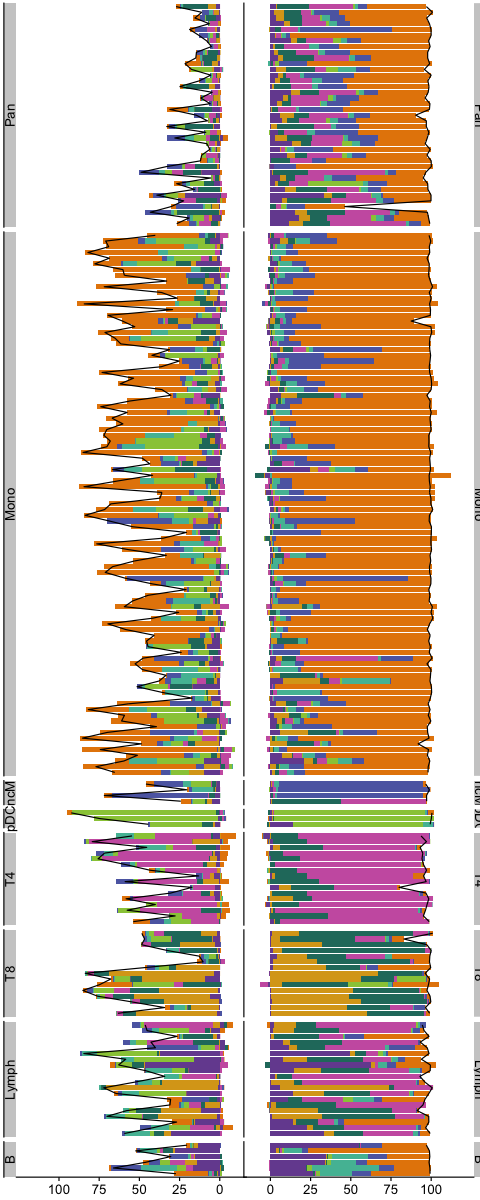

In [534]:
c <- plot_bar_chart(output_sle_asian_prop_noint, output_sle_asian_expr_pbmc_count_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(c, file="sle_asian_partitioned_pbmc_counts.png",width=3)
d <- plot_bar_chart(output_sle_white_prop_noint, output_sle_white_expr_pbmc_count_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(d, file="sle_white_partitioned_pbmc_counts.png",width=3);
f <- plot_bar_chart(output_broad_healthy_prop_noint, output_broad_healthy_expr_pbmc_count_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(f, file="broad_white_partitioned_pbmc_counts.png",width=3);


In [535]:
t(output_sle_prop_noint["C1QA",])
t(output_broad_healthy_prop_noint["C1QA",])
t(output_sle_expr_noint["C1QA",])
t(output_broad_healthy_expr_noint["C1QA",])

cM       Th       B           NK         ncM      Tc       cDC     
[1,] 11.11606 4.514163 -0.08676543 -0.0764201 13.67716 2.633154 2.603424
     pDC       total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 0.5732279 34.954   29.99811 99.86198           92.23242

cM       Th        B        NK          ncM      Tc       cDC      
[1,] 5.267998 0.3207484 3.018465 -0.07216381 59.60493 3.777213 -0.176562
     pDC        total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 0.04115487 71.78178 59.90043 99.80983           57.6245

cM        Th         B          NK         ncM      Tc        cDC      
[1,] 0.5999959 0.03810029 0.05112008 0.01174522 63.71243 0.2417576 0.2604036
     pDC          total r2 adj r2  total prop_expr r2 adj prop_expr r2
[1,] -0.007570361 64.90798 62.2343 99.86198           92.23242

cM      Th        B         NK        ncM      Tc        cDC      
[1,] 0.46058 0.4572713 0.3147223 0.2806184 25.27014 0.2653409 0.4117861
     pDC       total r2 adj r2    total prop_expr r2 adj prop_expr r2
[1,] 0.5675883 28.02805 -2.275927 99.80983           57.6245

In [536]:
t(output_sle_prop_noint["IL6",])
t(output_broad_healthy_prop_noint["IL6",])
t(output_sle_expr_noint["IL6",])
t(output_broad_healthy_expr_noint["IL6",])

cM       Th         B        NK         ncM      Tc        cDC     
[1,] -2.02805 -0.3453052 30.03475 -0.2199892 1.276323 0.2377561 4.423484
     pDC         total r2 adj r2  total prop_expr r2 adj prop_expr r2
[1,] -0.03975605 33.33922 28.2603 99.7347            92.09544

cM       Th         B        NK       ncM        Tc        cDC      
[1,] 2.757179 -0.1134685 13.27337 3.395166 -0.5972188 0.2860441 0.9460415
     pDC       total r2 adj r2    total prop_expr r2 adj prop_expr r2
[1,] 0.4347098 20.38182 -13.14162 97.34157           54.11697

cM       Th        B        NK        ncM       Tc        cDC       
[1,] 4.182746 0.9921599 59.71287 0.0943189 0.9624569 0.3666488 0.06987237
     pDC        total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 0.01441683 66.39549 63.83514 99.7347            92.09544

cM       Th        B        NK         ncM      Tc        cDC      
[1,] 25.00675 0.3897344 40.52578 -0.2332726 9.989931 0.9123195 0.2502308
     pDC       total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 0.1182764 76.95975 67.25859 97.34157           54.11697

In [537]:
t(output_sle_prop_noint["IFNG",])
t(output_broad_healthy_prop_noint["IFNG",])
t(output_sle_expr_noint["IFNG",])
t(output_broad_healthy_expr_noint["IFNG",])

cM        Th        B        NK        ncM       Tc       cDC      
[1,] 0.5409153 0.4321601 2.303233 0.1916367 0.2218482 43.96523 0.5996427
     pDC       total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 0.2719673 48.52664 44.60486 93.64606           85.5429

cM       Th       B        NK     ncM      Tc       cDC      pDC     
[1,] 2.180068 6.441569 1.685921 9.9019 0.625759 23.00756 1.535843 3.084895
     total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 48.46352 26.76394 101.0128           59.33391

cM        Th      B         NK       ncM       Tc       cDC      
[1,] 0.6439547 2.70745 0.1689126 6.954854 0.1744048 34.25818 0.2116141
     pDC          total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 5.337511e-05 45.11942 40.93804 93.64606           85.5429

cM        Th       B         NK       ncM       Tc       cDC        
[1,] 0.6413855 9.961375 0.2954155 4.911863 0.5785957 36.58651 0.009525956
     pDC        total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] -0.4354338 52.54923 32.56996 101.0128           59.33391

In [538]:
t(output_sle_asian_prop_noint["CCR7",])
t(output_sle_white_prop_noint["CCR7",])
t(output_sle_prop_noint["CCR7",])
t(output_broad_healthy_prop_noint["CCR7",])
t(output_prop_noint["CCR7",])

cM         Th       B        NK        ncM       Tc         cDC      
[1,] 0.01750447 39.03093 2.387467 0.3832484 -0.102583 -0.7093449 0.7643071
     pDC       total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 0.1279175 41.89945 32.78564 97.55603           81.48639

cM        Th       B         NK        ncM      Tc        cDC     
[1,] -2.704911 47.60301 0.3520805 0.1614779 9.385418 0.1303025 9.066456
     pDC       total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] -1.109899 62.88393 56.28552 98.56171           80.52824

cM        Th       B        NK         ncM      Tc         cDC     
[1,] -2.152368 43.48894 1.232166 -0.2851295 3.952578 -0.4163634 4.341618
     pDC        total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] -0.2661055 49.89533 46.07783 97.94799           90.1726

cM        Th       B        NK       ncM      Tc        cDC       
[1,] -3.318711 64.18748 -1.13882 17.19749 1.308445 0.2179506 -0.7586315
     pDC      total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 1.643113 79.33832 70.63867 99.87484           57.71688

cM       Th       B         NK         ncM      Tc         cDC      
[1,] 2.218605 50.78029 0.1911001 0.04497469 3.503444 -0.6304585 0.5904187
     pDC      total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 9.501391 66.19977 64.45524 98.76232           93.53715

In [539]:
t(output_sle_asian_prop_noint["CD8B",])
t(output_sle_white_prop_noint["CD8B",])
t(output_broad_healthy_prop_noint["CD8B",])

cM        Th       B         NK       ncM      Tc       cDC       
[1,] -3.860349 2.689733 -2.784913 2.417997 1.223542 50.69671 -0.1923907
     pDC      total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 4.042011 54.23234 47.05309 94.85072           78.35672

cM      Th       B          NK        ncM        Tc       cDC      
[1,] -1.6321 1.175251 -0.3564988 -1.053966 0.01927166 63.90406 0.1282128
     pDC      total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 2.667428 64.85166 58.60306 98.31869           80.24201

cM        Th       B          NK       ncM      Tc       cDC       
[1,] -3.921705 8.466556 -0.7092249 2.265508 16.05595 42.10047 -0.4732289
     pDC      total r2 adj r2   total prop_expr r2 adj prop_expr r2
[1,] 4.204432 67.98876 54.51034 97.64305           54.54538

In [540]:
t(output_sle_asian_expr_noint["CD3E",])
t(output_sle_white_expr_noint["CD3E",])
t(output_broad_healthy_expr_noint["CD3E",])

cM        Th       B         NK       ncM        Tc       cDC       
[1,] 0.1319166 7.329531 0.7220061 1.758421 0.07262773 8.013746 0.04984764
     pDC         total r2 adj r2  total prop_expr r2 adj prop_expr r2
[1,] -0.09048806 17.98761 5.12292 98.51677           82.59783

cM        Th       B         NK        ncM        Tc       cDC      
[1,] 0.2073966 4.637966 0.0622543 0.9849505 0.08130945 3.722235 0.1049743
     pDC       total r2 adj r2    total prop_expr r2 adj prop_expr r2
[1,] 0.0682632 9.86935  -6.153876 99.19521           81.27436

cM       Th       B        NK        ncM       Tc       cDC       pDC     
[1,] 1.305941 13.05061 1.762357 0.8858466 0.6775516 6.765615 0.6128459 0.470411
     total r2 adj r2    total prop_expr r2 adj prop_expr r2
[1,] 25.53118 -5.824116 99.45264           57.11691

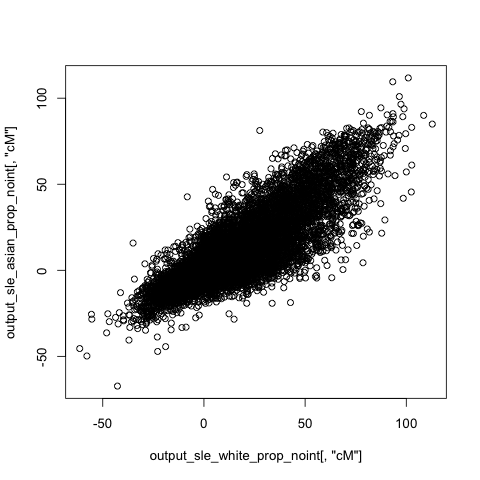

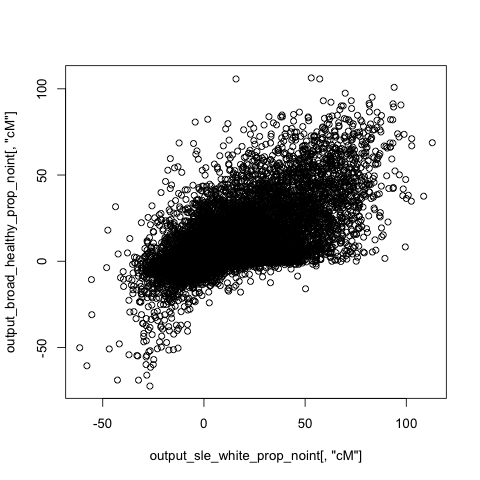

In [541]:
options(repr.plot.width = 6, repr.plot.height = 6);
plot(output_sle_white_prop_noint[,"cM"], output_sle_asian_prop_noint[,"cM"])
plot(output_sle_white_prop_noint[,"cM"], output_broad_healthy_prop_noint[,"cM"])

In [542]:
a <- cbind(rownames(output_sle_white_noint_df)[output_sle_white_noint_df[,"cluster"]=="6"], output_sle_white_noint_df[output_sle_white_noint_df[,"cluster"]=="6","prop"]-output_broad_healthy_noint_df[output_sle_white_noint_df[,"cluster"]=="6","prop"])
a[order(as.numeric(a[,2]),decreasing=T),]

[,1] [,2]

# Let's do the estimation using resampling

We are going to work with counts here. Given the expression of an arbitrary gene $i$ and individual $j$ in PBMCs $P$, and two cell types (B and T) for simplicity. $N_j^B$ and $N_j^T$ are the number of B cells and T cells for individual $j$.

\begin{align*}
P_{ij} &= B_{ij1}+B_{ij2}+...+B_{ijN_b}+T_{ij1}+T_{ij2}+...+T_{ijN_t} \\
P_{ij} &= \sum_k^{N_j^B}B_{ijk} + \sum_k^{N_j^T}T_{ijk} \\
P_{ij} &= N_j^B\times{\bar{B}_{ij}} + N_j^T\times{\bar{T}_{ij}} \\
\bar{P_{ij}} &= {{N_j^B}\over{N_j^{PBMC}}}\times{\bar{B_{ij}}} + {{N_j^T}\over{N_j^{PBMC}}}\times{\bar{T_{ij}}} \\
\bar{P_{ij}} &= {{{\rho}_j^B}\times{\bar{B_{ij}}} + {{\rho}_j^T}\times{\bar{T_{ij}}}}
\end{align*}


$\bar{B}_{ij}$ is the average expression of the gene $i$ in individual $j$ in cell type B. $\bar{T}_{ij}$ is the average expression of the gene $i$ in individual $j$ in cell type T

First, fit proportion

\begin{align*}
\bar{P_{ij}} &= {{\rho}_j^B}\times{\bar{B_{i}}} + {{\rho}_j^T}\times{\bar{T_{i}}}
\end{align*}

When we fit, we will take the average of expression over all individuals. That is $\bar{B_{i}} = {{\sum_j^{J}\bar{B_{ij}}}\over{J}}$

Second, fit expression

\begin{align*}
\bar{P_{ij}} &= {\bar{{\rho}^B}}\times{B_{ij}} + {\bar{{\rho}^T}}\times{T_{ij}}
\end{align*}

When we fit, we will take the average of expression over all individuals. That is $\bar{{\rho}^B} = {{{\sum_j^{J}{\rho_j^B}}}\over{J}}$


## First, let's do all individuals

In [543]:
# ##joined_pivot_filtered <- joined_pivot[match(colnames(pbmc_expr),joined_pivot$ind_cov),]
# # cm_counts_mean <- sweep(exp(cm_expr), 2, joined_pivot_filtered$counts*cm_prop/100, "/")
# # th_counts_mean <- sweep(exp(th_expr), 2, joined_pivot_filtered$counts*th_prop/100, "/")
# # tc_counts_mean <- sweep(exp(tc_expr), 2, joined_pivot_filtered$counts*tc_prop/100, "/")
# # b_counts_mean <- sweep(exp(b_expr), 2, joined_pivot_filtered$counts*b_prop/100, "/")
# # nk_counts_mean <- sweep(exp(nk_expr), 2, joined_pivot_filtered$counts*nk_prop/100, "/")
# # ncm_counts_mean <- sweep(exp(ncm_expr), 2, joined_pivot_filtered$counts*ncm_prop/100, "/")
# # dc_counts_mean <- sweep(exp(dc_expr), 2, joined_pivot_filtered$counts*dc_prop/100, "/")
# # pbmc_counts_mean <- sweep(exp(pbmc_expr), 2, joined_pivot_filtered$counts, "/")

# cm_counts_mean <- exp(cm_expr)
# th_counts_mean <- exp(th_expr)
# tc_counts_mean <- exp(tc_expr)
# b_counts_mean <- exp(b_expr)
# nk_counts_mean <- exp(nk_expr)
# ncm_counts_mean <- exp(ncm_expr)
# dc_counts_mean <- exp(dc_expr)
# pbmc_counts_mean <- exp(pbmc_expr)


# ## some samples do not have b cells or dcs, let's set those means to 0
# b_counts_mean[is.nan(b_counts_mean)] <- 0;
# dc_counts_mean[is.nan(dc_counts_mean)] <- 0;
# b_counts_mean[!is.finite(b_counts_mean)] <- 0;
# dc_counts_mean[!is.finite(dc_counts_mean)] <- 0;

# # cm_counts_global_mean <- rowSums(exp(cm_expr))/sum(joined_pivot_filtered$counts*cm_prop/100, na.rm=T)
# # th_counts_global_mean <- rowSums(exp(th_expr))/sum(joined_pivot_filtered$counts*th_prop/100, na.rm=T)
# # tc_counts_global_mean <- rowSums(exp(tc_expr))/sum(joined_pivot_filtered$counts*tc_prop/100, na.rm=T)
# # b_counts_global_mean <- rowSums(exp(b_expr))/sum(joined_pivot_filtered$counts*b_prop/100, na.rm=T)
# # nk_counts_global_mean <- rowSums(exp(nk_expr))/sum(joined_pivot_filtered$counts*nk_prop/100, na.rm=T)
# # ncm_counts_global_mean <- rowSums(exp(ncm_expr))/sum(joined_pivot_filtered$counts*ncm_prop/100, na.rm=T)
# # dc_counts_global_mean <- rowSums(exp(dc_expr))/sum(joined_pivot_filtered$counts*dc_prop/100, na.rm=T)

# cm_counts_global_mean <- apply(exp(cm_expr),1,mean)
# th_counts_global_mean <- apply(exp(th_expr),1,mean)
# tc_counts_global_mean <- apply(exp(tc_expr),1,mean)
# b_counts_global_mean <- apply(exp(b_expr),1,mean)
# nk_counts_global_mean <- apply(exp(nk_expr),1,mean)
# ncm_counts_global_mean <- apply(exp(ncm_expr),1,mean)
# dc_counts_global_mean <- apply(exp(dc_expr),1,mean)


# a <- cbind(cm_counts_global_mean, th_counts_global_mean, tc_counts_global_mean, b_counts_global_mean, nk_counts_global_mean, ncm_counts_global_mean, dc_counts_global_mean)
# ##sle_counts_means <- cbind(cm_sle_counts_mean, th_sle_counts_mean, tc_sle_counts_mean, b_sle_counts_mean, nk_sle_counts_mean, ncm_sle_counts_mean, dc_sle_counts_mean)

# output_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_counts[match(expr_gene_names, counts_gene_names),])) {    
#     predicted <- rowSums(cbind(cm_counts_global_mean[i]*cm_prop/100,
#                                th_counts_global_mean[i]*th_prop/100, 
#                                b_counts_global_mean[i]*b_prop/100, 
#                                nk_counts_global_mean[i]*nk_prop/100, 
#                                ncm_counts_global_mean[i]*ncm_prop/100, 
#                                tc_counts_global_mean[i]*tc_prop/100,##), na.rm=T)
#                                dc_counts_global_mean[i]*dc_prop/100), na.rm=T)

#     output_direct_global_prop <- rbind(output_direct_global_prop, c(cor(log(predicted),pbmc_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_expr_std[i,])^2*100))
# }


# rownames(output_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_direct_global_prop) <- c("r2", "res")

# output_direct_global_expr <- NULL;

# cm_prop_global_mean <- sum(joined_pivot_filtered$counts*cm_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# th_prop_global_mean <- sum(joined_pivot_filtered$counts*th_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# tc_prop_global_mean <- sum(joined_pivot_filtered$counts*tc_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# b_prop_global_mean <- sum(joined_pivot_filtered$counts*b_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# nk_prop_global_mean <- sum(joined_pivot_filtered$counts*nk_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# ncm_prop_global_mean <- sum(joined_pivot_filtered$counts*ncm_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# dc_prop_global_mean <- sum(joined_pivot_filtered$counts*dc_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)

# a_prop <- c(cm_prop_global_mean, th_prop_global_mean, tc_prop_global_mean, b_prop_global_mean, nk_prop_global_mean, ncm_prop_global_mean, dc_prop_global_mean);

# for(i in 1:nrow(pbmc_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop_global_mean, 
#                               th_counts_mean[i,]*th_prop_global_mean, 
#                               b_counts_mean[i,]*b_prop_global_mean,
#                               nk_counts_mean[i,]*nk_prop_global_mean, 
#                                ncm_counts_mean[i,]*ncm_prop_global_mean,
#                               tc_counts_mean[i,]*tc_prop_global_mean,##), na.rm=T)
#                               dc_counts_mean[i,]*dc_prop_global_mean), na.rm=T)

#     output_direct_global_expr <- rbind(output_direct_global_expr, c(cor(log(predicted),pbmc_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_expr_std[i,])^2*100))
# }

# rownames(output_direct_global_expr) <- expr_gene_names;
# colnames(output_direct_global_expr) <- c("r2", "res")

In [544]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# i=10
# i=grep("^CD22$",expr_gene_names)[1]
# ##i=grep("ERAP2",expr_gene_names)[1]
# predicted <- rowSums(cbind(cm_counts_global_mean[i]*cm_prop/100,
#                                th_counts_global_mean[i]*th_prop/100,
#                                b_counts_global_mean[i]*b_prop/100,
#                                nk_counts_global_mean[i]*nk_prop/100, 
#                                ncm_counts_global_mean[i]*ncm_prop/100,
#                                tc_counts_global_mean[i]*tc_prop/100,
#                      dc_counts_global_mean[i]*dc_prop/100),na.rm=T)
# plot(log(predicted), log(pbmc_counts_mean[i,]))
# cor(log(predicted), pbmc_expr_std[i,])^2

# predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop_global_mean, 
#                               th_counts_mean[i,]*th_prop_global_mean, 
#                               b_counts_mean[i,]*b_prop_global_mean,
#                               nk_counts_mean[i,]*nk_prop_global_mean, 
#                                ncm_counts_mean[i,]*ncm_prop_global_mean,
#                               tc_counts_mean[i,]*tc_prop_global_mean,
#                           dc_counts_mean[i,]*dc_prop_global_mean), na.rm=T)
# plot(log(predicted), pbmc_expr_std[i,])
# cor(log(predicted), pbmc_expr_std[i,])^2


# predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop, 
#                               th_counts_mean[i,]*th_prop, 
#                               b_counts_mean[i,]*b_prop,
#                               nk_counts_mean[i,]*nk_prop, 
#                                ncm_counts_mean[i,]*ncm_prop,
#                               tc_counts_mean[i,]*tc_prop,
#                           dc_counts_mean[i,]*dc_prop), na.rm=T)
# plot(log(predicted), pbmc_expr_std[i,])
# cor(log(predicted), pbmc_expr_std[i,])^2

## Second, let's do SLE

Mean of means might be a bit unstable, let's calculate a global mean

### All SLE

In [545]:
# # cm_sle_counts_mean <- sweep(exp(cm_sle_expr), 2, joined_pivot_sle$counts*cm_sle_prop/100, "/")
# # th_sle_counts_mean <- sweep(exp(th_sle_expr), 2, joined_pivot_sle$counts*th_sle_prop/100, "/")
# # tc_sle_counts_mean <- sweep(exp(tc_sle_expr), 2, joined_pivot_sle$counts*tc_sle_prop/100, "/")
# # b_sle_counts_mean <- sweep(exp(b_sle_expr), 2, joined_pivot_sle$counts*b_sle_prop/100, "/")
# # nk_sle_counts_mean <- sweep(exp(nk_sle_expr), 2, joined_pivot_sle$counts*nk_sle_prop/100, "/")
# # ncm_sle_counts_mean <- sweep(exp(ncm_sle_expr), 2, joined_pivot_sle$counts*ncm_sle_prop/100, "/")
# # dc_sle_counts_mean <- sweep(exp(dc_sle_expr), 2, joined_pivot_sle$counts*dc_sle_prop/100, "/")
# # pbmc_sle_counts_mean <- sweep(exp(pbmc_sle_expr), 2, joined_pivot_sle$counts, "/")


# cm_sle_counts_mean <- exp(cm_sle_expr);
# th_sle_counts_mean <- exp(th_sle_expr);
# tc_sle_counts_mean <- exp(tc_sle_expr);
# b_sle_counts_mean <- exp(b_sle_expr);
# nk_sle_counts_mean <- exp(nk_sle_expr);
# ncm_sle_counts_mean <- exp(ncm_sle_expr);
# dc_sle_counts_mean <- exp(dc_sle_expr);
# pbmc_sle_counts_mean <- exp(pbmc_sle_expr);

# # cm_sle_counts_global_mean <- rowSums(exp(cm_sle_expr))/sum(joined_pivot_sle$counts*cm_sle_prop/100, na.rm=T)
# # th_sle_counts_global_mean <- rowSums(exp(th_sle_expr))/sum(joined_pivot_sle$counts*th_sle_prop/100, na.rm=T)
# # tc_sle_counts_global_mean <- rowSums(exp(tc_sle_expr))/sum(joined_pivot_sle$counts*tc_sle_prop/100, na.rm=T)
# # b_sle_counts_global_mean <- rowSums(exp(b_sle_expr))/sum(joined_pivot_sle$counts*b_sle_prop/100, na.rm=T)
# # nk_sle_counts_global_mean <- rowSums(exp(nk_sle_expr))/sum(joined_pivot_sle$counts*nk_sle_prop/100, na.rm=T)
# # ncm_sle_counts_global_mean <- rowSums(exp(ncm_sle_expr))/sum(joined_pivot_sle$counts*ncm_sle_prop/100, na.rm=T)
# # dc_sle_counts_global_mean <- rowSums(exp(dc_sle_expr))/sum(joined_pivot_sle$counts*dc_sle_prop/100, na.rm=T)

# cm_sle_counts_global_mean <- apply(exp(cm_sle_expr),1,mean)
# th_sle_counts_global_mean <- apply(exp(th_sle_expr),1,mean)
# tc_sle_counts_global_mean <- apply(exp(tc_sle_expr),1,mean)
# b_sle_counts_global_mean <- apply(exp(b_sle_expr),1,mean)
# nk_sle_counts_global_mean <- apply(exp(nk_sle_expr),1,mean)
# ncm_sle_counts_global_mean <- apply(exp(ncm_sle_expr),1,mean)
# dc_sle_counts_global_mean <- apply(exp(dc_sle_expr),1,mean)


# ## some samples do not have b cells or dcs, let's set those means to 0
# b_sle_counts_mean[is.nan(b_sle_counts_mean)] <- 0;
# dc_sle_counts_mean[is.nan(dc_sle_counts_mean)] <- 0;
# b_sle_counts_mean[!is.finite(b_sle_counts_mean)] <- 0;
# dc_sle_counts_mean[!is.finite(dc_sle_counts_mean)] <- 0;

# ##sle_counts_means <- cbind(cm_sle_counts_mean, th_sle_counts_mean, tc_sle_counts_mean, b_sle_counts_mean, nk_sle_counts_mean, ncm_sle_counts_mean, dc_sle_counts_mean)

# output_sle_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {    
#     predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop/100,
#                                th_sle_counts_global_mean[i]*th_sle_prop/100,
#                                b_sle_counts_global_mean[i]*b_sle_prop/100,
#                                nk_sle_counts_global_mean[i]*nk_sle_prop/100, 
#                                ncm_sle_counts_global_mean[i]*ncm_sle_prop/100,
#                                tc_sle_counts_global_mean[i]*tc_sle_prop/100,##), na.rm=T)
#                                dc_sle_counts_global_mean[i]*dc_sle_prop/100),na.rm=T)

#     output_sle_direct_global_prop <- rbind(output_sle_direct_global_prop, 
#                                                c(cor(log(predicted),pbmc_sle_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,])^2*100))
# }


# rownames(output_sle_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_sle_direct_global_prop) <- c("r2", "res")

# output_sle_direct_global_expr <- NULL;

# cm_sle_prop_global_mean <- sum(joined_pivot_sle$counts*cm_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# th_sle_prop_global_mean <- sum(joined_pivot_sle$counts*th_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# tc_sle_prop_global_mean <- sum(joined_pivot_sle$counts*tc_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# b_sle_prop_global_mean <- sum(joined_pivot_sle$counts*b_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# nk_sle_prop_global_mean <- sum(joined_pivot_sle$counts*nk_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# ncm_sle_prop_global_mean <- sum(joined_pivot_sle$counts*ncm_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# dc_sle_prop_global_mean <- sum(joined_pivot_sle$counts*dc_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop_global_mean,
#                               th_sle_counts_mean[i,]*th_sle_prop_global_mean,
#                               b_sle_counts_mean[i,]*b_sle_prop_global_mean,
#                               nk_sle_counts_mean[i,]*nk_sle_prop_global_mean, 
#                                ncm_sle_counts_mean[i,]*ncm_sle_prop_global_mean,
#                               tc_sle_counts_mean[i,]*tc_sle_prop_global_mean,##), na.rm=T)
#                               dc_sle_counts_mean[i]*dc_sle_prop_global_mean),na.rm=T)

#    ##output_sle_direct_global_expr <- rbind(output_sle_direct_global_expr, c(var(predicted)/var(pbmc_sle_counts_mean[i,],na.rm=T)*100, 100-var(predicted)/var(pbmc_sle_counts_mean[i,],na.rm=T)*100))
#   output_sle_direct_global_expr <- rbind(output_sle_direct_global_expr, 
#                                          c(cor(log(predicted),pbmc_sle_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,])^2*100))
# }

# rownames(output_sle_direct_global_expr) <- expr_gene_names;
# colnames(output_sle_direct_global_expr) <- c("r2", "res")

In [546]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# i=2
# i=grep("^CD22$",expr_gene_names)[1]
# predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop/100,
#                                th_sle_counts_global_mean[i]*th_sle_prop/100,
#                                b_sle_counts_global_mean[i]*b_sle_prop/100,
#                                nk_sle_counts_global_mean[i]*nk_sle_prop/100, 
#                                ncm_sle_counts_global_mean[i]*ncm_sle_prop/100,
#                                tc_sle_counts_global_mean[i]*tc_sle_prop/100,
#                           dc_sle_counts_global_mean[i]*dc_sle_prop/100), na.rm=T)
# plot(log(predicted), log(pbmc_sle_counts_mean[i,]))
# cor(predicted, pbmc_sle_counts_mean[i,])^2
# output_sle_prop_noint[i,"adj r2"]

# predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop_global_mean, 
#                               th_sle_counts_mean[i,]*th_sle_prop_global_mean, 
#                               b_sle_counts_mean[i,]*b_sle_prop_global_mean,
#                               nk_sle_counts_mean[i,]*nk_sle_prop_global_mean, 
#                                ncm_sle_counts_mean[i,]*ncm_sle_prop_global_mean,
#                               tc_sle_counts_mean[i,]*tc_sle_prop_global_mean,##), na.rm=T)
#                           dc_sle_counts_mean[i,]*dc_sle_prop_global_mean), na.rm=T)

# plot(log(predicted), log(pbmc_sle_counts_mean[i,]))
# cor(predicted, pbmc_sle_counts_mean[i,])^2

# predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop, 
#                               th_sle_counts_mean[i,]*th_sle_prop, 
#                               b_sle_counts_mean[i,]*b_sle_prop,
#                               nk_sle_counts_mean[i,]*nk_sle_prop, 
#                                ncm_sle_counts_mean[i,]*ncm_sle_prop,
#                               tc_sle_counts_mean[i,]*tc_sle_prop,
#                           dc_sle_counts_mean[i,]*dc_sle_prop), na.rm=T)
# plot(predicted, pbmc_sle_counts_mean[i,])
# cor(predicted, pbmc_sle_counts_mean[i,])^2



### Now, let's downsample to 46 and redo SLE

In [547]:
# cm_sle_down_counts_global_mean <- apply(exp(cm_sle_expr[,samples]),1,mean)
# th_sle_down_counts_global_mean <- apply(exp(th_sle_expr[,samples]),1,mean)
# tc_sle_down_counts_global_mean <- apply(exp(tc_sle_expr[,samples]),1,mean)
# b_sle_down_counts_global_mean <- apply(exp(b_sle_expr[,samples]),1,mean)
# nk_sle_down_counts_global_mean <- apply(exp(nk_sle_expr[,samples]),1,mean)
# ncm_sle_down_counts_global_mean <- apply(exp(ncm_sle_expr[,samples]),1,mean)
# dc_sle_down_counts_global_mean <- apply(exp(dc_sle_expr[,samples]),1,mean)

# # cm_sle_down_counts_global_mean <- rowSums(exp(cm_sle_expr[,samples]))/sum((joined_pivot_sle$counts*cm_sle_prop/100)[samples])
# # th_sle_down_counts_global_mean <- rowSums(exp(th_sle_expr[,samples]))/sum((joined_pivot_sle$counts*th_sle_prop/100)[samples])
# # tc_sle_down_counts_global_mean <- rowSums(exp(tc_sle_expr[,samples]))/sum((joined_pivot_sle$counts*tc_sle_prop/100)[samples])
# # b_sle_down_counts_global_mean <- rowSums(exp(b_sle_expr[,samples]),na.rm=T)/sum((joined_pivot_sle$counts*b_sle_prop/100)[samples],na.rm=T)
# # nk_sle_down_counts_global_mean <- rowSums(exp(nk_sle_expr[,samples]))/sum((joined_pivot_sle$counts*nk_sle_prop/100)[samples])
# # ncm_sle_down_counts_global_mean <- rowSums(exp(ncm_sle_expr[,samples]))/sum((joined_pivot_sle$counts*ncm_sle_prop/100)[samples])
# # dc_sle_down_counts_global_mean <- rowSums(exp(dc_sle_expr[,samples]),na.rm=T)/sum((joined_pivot_sle$counts*dc_sle_prop/100)[samples],na.rm=T)

# output_sle_down_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),samples])) {    
#     predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop[samples]/100, 
#                                th_sle_counts_global_mean[i]*th_sle_prop[samples]/100, 
#                                b_sle_counts_global_mean[i]*b_sle_prop[samples]/100, 
#                                nk_sle_counts_global_mean[i]*nk_sle_prop[samples]/100, 
#                                ncm_sle_counts_global_mean[i]*ncm_sle_prop[samples]/100, 
#                                tc_sle_counts_global_mean[i]*tc_sle_prop[samples]/100,##), na.rm=T)
#                                dc_sle_counts_global_mean[i]*dc_sle_prop[samples]/100), na.rm=T)

#     output_sle_down_direct_global_prop <- rbind(output_sle_down_direct_global_prop,
#                                                 c(cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100))
# }


# rownames(output_sle_down_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_sle_down_direct_global_prop) <- c("r2", "res")

# output_sle_down_direct_global_expr <- NULL;

# cm_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*cm_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# th_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*th_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# tc_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*tc_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# b_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*b_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples],na.rm=T)
# nk_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*nk_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# ncm_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*ncm_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# dc_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*dc_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples],na.rm=T)

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_sle_counts_mean[i,samples]*cm_sle_down_prop_global_mean,
#                               th_sle_counts_mean[i,samples]*th_sle_down_prop_global_mean, 
#                               b_sle_counts_mean[i,samples]*b_sle_down_prop_global_mean, 
#                               nk_sle_counts_mean[i,samples]*nk_sle_down_prop_global_mean,
#                               ncm_sle_counts_mean[i,samples]*ncm_sle_down_prop_global_mean, 
#                               tc_sle_counts_mean[i,samples]*tc_sle_down_prop_global_mean,##), na.rm=T)
#                               dc_sle_counts_mean[i,samples]*dc_sle_down_prop_global_mean), na.rm=T)

#     output_sle_down_direct_global_expr <- rbind(output_sle_down_direct_global_expr, 
#                                                 c(cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100))
  
# }


## Finally, processed the healthy

In [548]:
# cm_healthy_counts_mean <- exp(cm_healthy_expr)
# th_healthy_counts_mean <- exp(th_healthy_expr)
# tc_healthy_counts_mean <- exp(tc_healthy_expr)
# b_healthy_counts_mean <- exp(b_healthy_expr)
# nk_healthy_counts_mean <- exp(nk_healthy_expr)
# ncm_healthy_counts_mean <- exp(ncm_healthy_expr)
# dc_healthy_counts_mean <- exp(dc_healthy_expr)
# pbmc_healthy_counts_mean <- exp(pbmc_healthy_expr)


# # cm_healthy_counts_mean <- sweep(exp(cm_healthy_expr), 2, joined_pivot_healthy$counts*cm_healthy_prop/100, "/")
# # th_healthy_counts_mean <- sweep(exp(th_healthy_expr), 2, joined_pivot_healthy$counts*th_healthy_prop/100, "/")
# # tc_healthy_counts_mean <- sweep(exp(tc_healthy_expr), 2, joined_pivot_healthy$counts*tc_healthy_prop/100, "/")
# # b_healthy_counts_mean <- sweep(exp(b_healthy_expr), 2, joined_pivot_healthy$counts*b_healthy_prop/100, "/")
# # nk_healthy_counts_mean <- sweep(exp(nk_healthy_expr), 2, joined_pivot_healthy$counts*nk_healthy_prop/100, "/")
# # ncm_healthy_counts_mean <- sweep(exp(ncm_healthy_expr), 2, joined_pivot_healthy$counts*ncm_healthy_prop/100, "/")
# # dc_healthy_counts_mean <- sweep(exp(dc_healthy_expr), 2, joined_pivot_healthy$counts*dc_healthy_prop/100, "/")
# # pbmc_healthy_counts_mean <- sweep(exp(pbmc_healthy_expr), 2, joined_pivot_healthy$counts, "/")

# cm_healthy_counts_global_mean <- apply(exp(cm_healthy_expr),1,mean)
# th_healthy_counts_global_mean <- apply(exp(th_healthy_expr),1,mean)
# tc_healthy_counts_global_mean <- apply(exp(tc_healthy_expr),1,mean)
# b_healthy_counts_global_mean <- apply(exp(b_healthy_expr),1,mean)
# nk_healthy_counts_global_mean <- apply(exp(nk_healthy_expr),1,mean)
# ncm_healthy_counts_global_mean <- apply(exp(ncm_healthy_expr),1,mean)
# dc_healthy_counts_global_mean <- apply(exp(dc_healthy_expr),1,mean)

# # cm_healthy_counts_global_mean <- rowSums(exp(cm_healthy_expr))/sum(joined_pivot_healthy$counts*cm_healthy_prop/100, na.rm=T)
# # th_healthy_counts_global_mean <- rowSums(exp(th_healthy_expr))/sum(joined_pivot_healthy$counts*th_healthy_prop/100, na.rm=T)
# # tc_healthy_counts_global_mean <- rowSums(exp(tc_healthy_expr))/sum(joined_pivot_healthy$counts*tc_healthy_prop/100, na.rm=T)
# # b_healthy_counts_global_mean <- rowSums(exp(b_healthy_expr))/sum(joined_pivot_healthy$counts*b_healthy_prop/100, na.rm=T)
# # nk_healthy_counts_global_mean <- rowSums(exp(nk_healthy_expr))/sum(joined_pivot_healthy$counts*nk_healthy_prop/100, na.rm=T)
# # ncm_healthy_counts_global_mean <- rowSums(exp(ncm_healthy_expr))/sum(joined_pivot_healthy$counts*ncm_healthy_prop/100, na.rm=T)
# # dc_healthy_counts_global_mean <- rowSums(exp(dc_healthy_expr))/sum(joined_pivot_healthy$counts*dc_healthy_prop/100, na.rm=T)

# ##healthy_counts_means <- cbind(cm_healthy_counts_mean, th_healthy_counts_mean, tc_healthy_counts_mean, b_healthy_counts_mean, nk_healthy_counts_mean, ncm_healthy_counts_mean, dc_healthy_counts_mean)

# output_healthy_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_healthy_counts[match(expr_gene_names, counts_gene_names),])) {    
#     predicted <- rowSums(cbind(cm_healthy_counts_global_mean[i]*cm_healthy_prop/100,
#                                th_healthy_counts_global_mean[i]*th_healthy_prop/100,
#                                b_healthy_counts_global_mean[i]*b_healthy_prop/100,
#                                nk_healthy_counts_global_mean[i]*nk_healthy_prop/100, 
#                                ncm_healthy_counts_global_mean[i]*ncm_healthy_prop/100,
#                                tc_healthy_counts_global_mean[i]*tc_healthy_prop/100,##), na.rm=T)
#                                dc_healthy_counts_global_mean[i]*dc_healthy_prop/100),na.rm=T)

#     output_healthy_direct_global_prop <- rbind(output_healthy_direct_global_prop, 
#                                                c(cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100))
# }


# rownames(output_healthy_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_healthy_direct_global_prop) <- c("r2", "res")

# output_healthy_direct_global_expr <- NULL;

# cm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*cm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# th_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*th_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# tc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*tc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# b_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*b_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# nk_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*nk_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# ncm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*ncm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# dc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*dc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)

# for(i in 1:nrow(pbmc_healthy_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean,
#                               th_healthy_counts_mean[i,]*th_healthy_prop_global_mean,
#                               b_healthy_counts_mean[i,]*b_healthy_prop_global_mean,
#                               nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
#                                ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean,
#                               tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean,##), na.rm=T)
#                               dc_healthy_counts_mean[i]*dc_healthy_prop_global_mean),na.rm=T)

#    ##output_healthy_direct_global_expr <- rbind(output_healthy_direct_global_expr, c(var(predicted)/var(pbmc_healthy_counts_mean[i,],na.rm=T)*100, 100-var(predicted)/var(pbmc_healthy_counts_mean[i,],na.rm=T)*100))
#   output_healthy_direct_global_expr <- rbind(output_healthy_direct_global_expr, 
#                                          c(cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100))
# }

# rownames(output_healthy_direct_global_expr) <- expr_gene_names;
# colnames(output_healthy_direct_global_expr) <- c("r2", "res")

In [549]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# i=10
# i=grep("^CD22$",expr_gene_names)[1]
# predicted <- rowSums(cbind(cm_healthy_counts_global_mean[i]*cm_healthy_prop/100,
#                                th_healthy_counts_global_mean[i]*th_healthy_prop/100,
#                                b_healthy_counts_global_mean[i]*b_healthy_prop/100,
#                                nk_healthy_counts_global_mean[i]*nk_healthy_prop/100, 
#                                ncm_healthy_counts_global_mean[i]*ncm_healthy_prop/100,
#                                tc_healthy_counts_global_mean[i]*tc_healthy_prop/100,
#                           dc_healthy_counts_global_mean[i]*dc_healthy_prop/100), na.rm=T)
# plot(log(predicted), log(pbmc_healthy_counts_mean[i,]))
# cor(predicted, pbmc_healthy_counts_mean[i,])^2*100
# output_healthy_prop_noint[i,"adj r2"]

# predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean, 
#                               th_healthy_counts_mean[i,]*th_healthy_prop_global_mean, 
#                               b_healthy_counts_mean[i,]*b_healthy_prop_global_mean,
#                               nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
#                                ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean,
#                               tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean,
#                           dc_healthy_counts_mean[i,]*dc_healthy_prop_global_mean), na.rm=T)
# plot(log(predicted), log(pbmc_healthy_counts_mean[i,]))
# cor(predicted, pbmc_healthy_counts_mean[i,])^2


# predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop, 
#                               th_healthy_counts_mean[i,]*th_healthy_prop, 
#                               b_healthy_counts_mean[i,]*b_healthy_prop,
#                               nk_healthy_counts_mean[i,]*nk_healthy_prop, 
#                                ncm_healthy_counts_mean[i,]*ncm_healthy_prop,
#                               tc_healthy_counts_mean[i,]*tc_healthy_prop,
#                           dc_healthy_counts_mean[i,]*dc_healthy_prop), na.rm=T)
# plot(predicted, pbmc_healthy_counts_mean[i,])
# cor(predicted, pbmc_healthy_counts_mean[i,])^2

## Plotting

In [550]:
# df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]), cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]), cor(output_sle_down_prop_noint[,"adj r2"], output_sle_down_expr_noint[,"adj r2"]), cor(output_healthy_prop_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])),
#       prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"])),
#       expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_expr_noint[,"adj r2"])),
#       sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]+output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"]+output_healthy_expr_noint[,"adj r2"])))
# rownames(df2) <- c("all_noint", "sle_noint", "sle_down_noint", "healthy_noint")

# df2

# df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
#              data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_down_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_down_expr_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_healthy_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_healthy_expr_noint,2,mean,na.rm=T))))

# rownames(df3) <- c("all_noint_prop", "all_noint_expr", "sle_noint_prop", "sle_noint_expr", "sle_down_noint_prop", "sle_down_noint_expr", "healthy_noint_prop", "healthy_noint_expr")

# df3


# output_direct_global_df <- data.frame(prop=output_direct_global_prop[,1], expr=output_direct_global_expr[,1], type="all_direct")
# output_direct_global_df$cluster <- "no_diff";
# output_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_direct_global_df)))] <- cuttree_out[,"cluster"];

# output_sle_direct_global_df <- data.frame(prop=output_sle_direct_global_prop[,1], expr=output_sle_direct_global_expr[,1], type="sle_direct")
# output_sle_direct_global_df$cluster <- "no_diff";
# output_sle_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_sle_direct_global_df)))] <- cuttree_out[,"cluster"];

# output_sle_down_direct_global_df <- data.frame(prop=output_sle_down_direct_global_prop[,1], expr=output_sle_down_direct_global_expr[,1], type="sle_down_direct")
# output_sle_down_direct_global_df$cluster <- "no_diff";
# output_sle_down_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_sle_down_direct_global_df)))] <- cuttree_out[,"cluster"];

# output_healthy_direct_global_df <- data.frame(prop=output_healthy_direct_global_prop[,1], expr=output_healthy_direct_global_expr[,1], type="healthy_direct")
# output_healthy_direct_global_df$cluster <- "no_diff";
# output_healthy_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_healthy_direct_global_df)))] <- cuttree_out[,"cluster"];

# df <- rbind(output_direct_global_df, output_sle_direct_global_df, output_sle_down_direct_global_df, output_healthy_direct_global_df)
# df$cluster <- as.factor(df$cluster)


# options(repr.plot.width = 10, repr.plot.height = 3)
# df_all_ifn <- df;
# df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
# df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "all_ifn")] <- "no_all_ifn";
# df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","no_all_ifn","all_ifn"));
# df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
# ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)


# options(repr.plot.width = 9, repr.plot.height = 3)
# ggplot(aes(prop, expr,color=(cluster=="all_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'all_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="all_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="cM_DC_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_DC_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="cM_DC_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="cM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="cM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="dc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'dc_specific'),
#              aes(x = prop, y = expr, color = (cluster=="dc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="myeloid_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'myeloid_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="myeloid_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="ncM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'ncM_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="ncM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="tc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'tc_specific'),
#              aes(x = prop, y = expr, color = (cluster=="tc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="th_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'th_specific'),
#              aes(x = prop, y = expr, color = (cluster=="th_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)

# df2 <- data.frame(cor=c(cor(output_direct_global_prop[,1], output_direct_global_expr[,1],use='complete.obs'), 
#                         cor(output_sle_direct_global_prop[,1], output_sle_direct_global_expr[,1],use='complete.obs'), 
#                         cor(output_sle_down_direct_global_prop[,1], output_sle_down_direct_global_expr[,1],use='complete.obs'),
#                         cor(output_healthy_direct_global_prop[,1], output_healthy_direct_global_expr[,1])),
#       prop_mean=c(mean(output_direct_global_prop[,1],na.rm=T), mean(output_sle_direct_global_prop[,1],na.rm=T), mean(output_sle_down_direct_global_prop[,1],na.rm=T), mean(output_healthy_direct_global_prop[,1])),
#       expr_mean=c(mean(output_direct_global_expr[,1]), mean(output_sle_direct_global_expr[,1]), mean(output_sle_down_direct_global_expr[,1]), mean(output_healthy_direct_global_expr[,1])),
#       sum_mean = c(mean(output_direct_global_prop[,1]+output_direct_global_expr[,1],na.rm=T), mean(output_sle_direct_global_prop[,1]+output_sle_direct_global_expr[,1],na.rm=T), mean(output_sle_down_direct_global_prop[,1]+output_sle_down_direct_global_expr[,1],na.rm=T), mean(output_healthy_direct_global_prop[,1]+output_healthy_direct_global_expr[,1])))
# rownames(df2) <- c("all_direct", "sle_direct", "sle_down_direct", "healthy_direct")

# df2


## Compare to previous estimates using linear regression

In [551]:
# df <- rbind(data.frame(direct=output_direct_global_prop[,1], regression=output_prop_noint[,"adj r2"], type="all prop"),
#             data.frame(direct=output_direct_global_expr[,1], regression=output_expr_noint[,"adj r2"], type="all expr"),
            
#             data.frame(direct=output_sle_direct_global_prop[,1], regression=output_sle_prop_noint[,"adj r2"], type="sle prop"),
#             data.frame(direct=output_sle_direct_global_expr[,1], regression=output_sle_expr_noint[,"adj r2"], type="sle expr"),
            
#             data.frame(direct=output_sle_down_direct_global_prop[,1], regression=output_sle_down_prop_noint[,"adj r2"], type="sle down prop"),
#             data.frame(direct=output_sle_down_direct_global_expr[,1], regression=output_sle_down_expr_noint[,"adj r2"], type="sle down expr"),
            
#             data.frame(direct=output_healthy_direct_global_prop[,1], regression=output_healthy_prop_noint[,"adj r2"], type="healthy prop"),
#             data.frame(direct=output_healthy_direct_global_expr[,1], regression=output_healthy_expr_noint[,"adj r2"], type="healthy expr"))
  
# options(repr.plot.width = 8, repr.plot.height = 5)
# ggplot(aes(direct, regression), data=df)+geom_point()+facet_wrap(~ type, nrow = 2)+theme_bw()+xlim(0,100)+ylim(0,100)+geom_abline(slope=1, intercept=0,
#   na.rm = FALSE, show.legend = NA)
# ##ggplot(aes(direct, regression), data=df)+geom_point()+facet_wrap(~ type, nrow = 2)+theme_bw()+geom_abline(slope=1, intercept=0,
# ##  na.rm = FALSE, show.legend = NA)


In [552]:
# cor(output_sle_direct_global_prop[,1], output_sle_prop_noint[,"adj r2"],use='complete.obs')
# cor(output_sle_direct_global_expr[,1], output_sle_expr_noint[,"adj r2"])

# cor(output_sle_down_direct_global_prop[,1], output_sle_down_prop_noint[,"adj r2"],use='complete.obs')
# cor(output_sle_down_direct_global_expr[,1], output_sle_down_expr_noint[,"adj r2"])

# cor(output_healthy_direct_global_prop[,1], output_healthy_prop_noint[,"adj r2"])
# cor(output_healthy_direct_global_expr[,1], output_healthy_expr_noint[,"adj r2"])

In [553]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# plot(output_sle_down_direct_global_prop[,1], output_sle_down_prop_noint[,"adj r2"])
# plot(output_sle_down_direct_global_expr[,1], output_sle_down_expr_noint[,"adj r2"])


In [554]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# plot(output_sle_down_direct_global_prop[,1], output_healthy_direct_global_prop[,1])
# plot(output_sle_down_prop_noint[,"adj r2"], output_healthy_prop_noint[,"adj r2"])
# plot(output_sle_down_direct_global_expr[,1], output_healthy_direct_global_expr[,1])
# plot(output_sle_down_expr_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])